In [1]:
import paho.mqtt.client as mqtt
import threading
import os
import re
# import motionlocalizer.settings
import json
# import requests
from shapely.geometry import Polygon
from shapely.ops import cascaded_union
import xml.etree.ElementTree
import pprint
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
import time as pythonTimer
import random
from random import randint
import scipy.stats as stats
from scipy.stats import multivariate_normal
import csv
import datetime
import pandas as pd

simworldname = 'simulationWorld2.xml' #ENVIROMENT
groundtruth = '28jun2.csv' #AGENT'S MOVEMENTS
motion_readings = '28Jun2_motion_events.txt'
# groundtruth = 'AgentDetailedTasksFile.csv' #AGENT'S MOVEMENTS

my_map = [(0.0, 0.0), (0.0, 10.6), (6.6, 10.6), (6.6, 0.0)]
grid_map = np.zeros((int(my_map[2][0]) * 10, int(my_map[2][1]) * 10))
distances = []

oracle = {}
oracle['time'] = []
oracle['location'] = []

analyzer = {}
analyzer['time'] = []
analyzer['gridmap'] = []
 
def start_localizing(event):
    global analyzer
    global oracle
    global grid_map
    run_localization(event)

def run_localization(event):
    global analyzer
    global oracle
    global grid_map
    # print("run_localization")
    Localizer(pythonTimer.time()).run(event)

In [2]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx


# sensor_readings = open(motion_readings, "r")
sensor_readings = open(motion_readings, "r").readlines()

dataset_times = []
dataset_readings = []
for i in range(0,len(sensor_readings)):
    time = sensor_readings[i].split(';')[0]
    sensor_array = sensor_readings[i].split(';')[1]
    dataset_times.append(int(time))
    dataset_readings.append(sensor_array)

dataset = ['time', 'gt(x)', 'gt(y)', 'motion_readings']
with open(groundtruth, 'r') as user_data:
    reader = csv.reader(user_data, delimiter=',', quotechar=',')
    line = 0
    for row in reader:
        new_row = []
        if (reader.line_num != 1):
            ind = find_nearest(dataset_times[1:], int(row[0]))
            dataset = np.vstack((dataset, [float(row[0]), float(row[4]), float(row[5]), dataset_readings[line]]))
            line = line + 1

In [3]:
dataset

array([['time', 'gt(x)', 'gt(y)', 'motion_readings'],
       ['1498670641.0', '1.197742', '5.402001', '0000000000000000000000'],
       ['1498670642.0', '1.198065', '5.401716', '0000000000000000000000'],
       ...,
       ['1498677300.0', '3.4', '3.45', '0000000000000000000000'],
       ['1498677303.0', '3.4', '3.45', '0000000000000000000000'],
       ['1498677318.0', '3.4', '3.45', '0000000000000000000000']],
      dtype='<U32')

In [4]:
dataset

array([['time', 'gt(x)', 'gt(y)', 'motion_readings'],
       ['1498670641.0', '1.197742', '5.402001', '0000000000000000000000'],
       ['1498670642.0', '1.198065', '5.401716', '0000000000000000000000'],
       ...,
       ['1498677300.0', '3.4', '3.45', '0000000000000000000000'],
       ['1498677303.0', '3.4', '3.45', '0000000000000000000000'],
       ['1498677318.0', '3.4', '3.45', '0000000000000000000000']],
      dtype='<U32')

In [5]:
motions_order = [1, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 2, 20, 21, 22, 3, 4, 5, 6, 7, 8, 9]
motion_sensors = [1, 10, 11, 12, 13, 14, 2, 3, 4, 5, 6, 7, 8, 9]
motions_sensor_data = {}

sr_matrix = np.zeros([1, 14])
for i in range(1,len(dataset)):
    sensor_array = dataset[i][3]
    sr_row = []
    for j in range(0,len(sensor_array)):
        if (motions_order[j] <= 14):
            sr_row.append(int(sensor_array[j]))

    sr_matrix = np.vstack((sr_matrix,sr_row))

i = 0
for sensor in motions_order:
    if (sensor <= 14):
        motions_sensor_data[sensor] = []
        motions_sensor_data[sensor] = sr_matrix[:, i]
        i = i + 1
        
for sensor in motion_sensors:
    new_readings = []
    new_readings.append(motions_sensor_data[sensor][0])
    for i in range(1, len(motions_sensor_data[sensor])):
        if (new_readings[len(new_readings) - 1] == motions_sensor_data[sensor][i]):
            new_readings.append(0)
        else:
            new_readings.append(1)

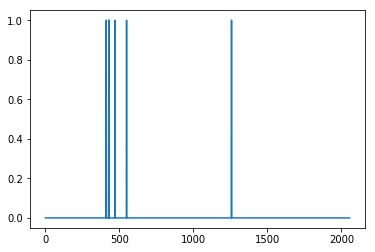

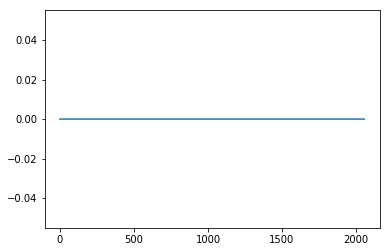

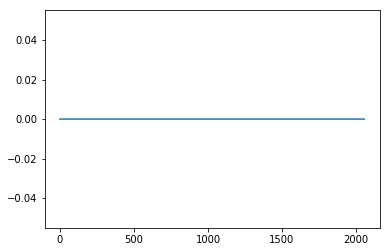

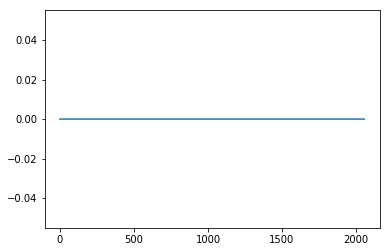

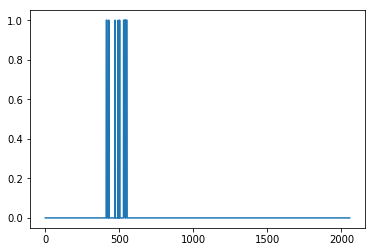

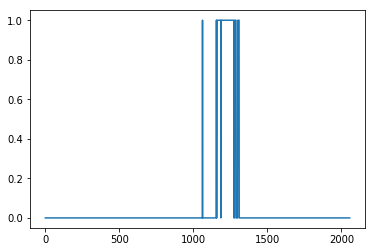

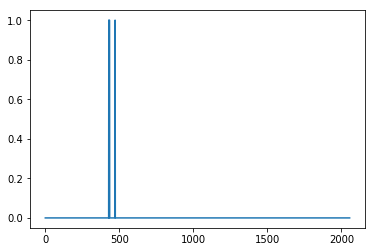

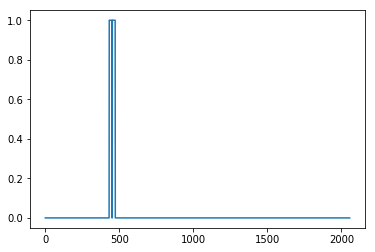

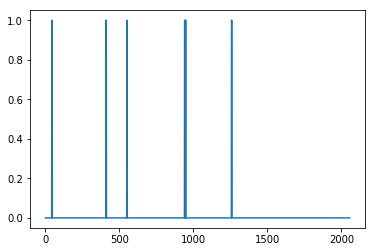

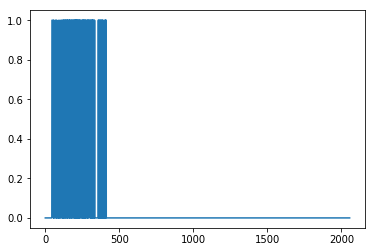

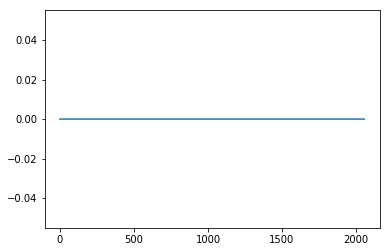

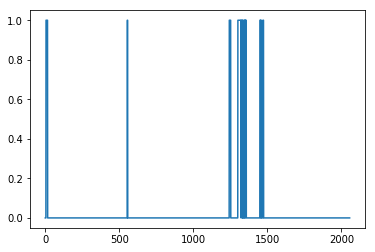

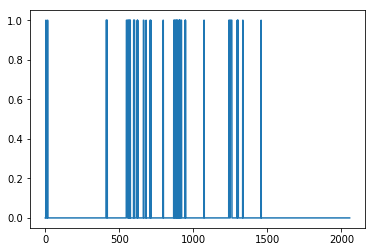

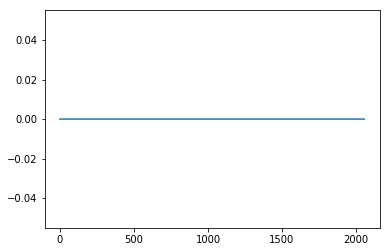

In [6]:
import matplotlib.pyplot as plt

for i in motion_sensors:
    plt.plot(list(range(0,len(motions_sensor_data[i]))), motions_sensor_data[i])
    plt.show()

In [7]:
##################################
####       Sensor Class       ####
##################################

class Sensor:
    sensor_type = ""
    sensor_id = ""
    x = float()
    y = float()
    z = float()

    def __str__(self):
        return 'type: %s,\n id: %s,\n x: %s,\n y: %s\n'%(self.sensor_type, self.sensor_id, self.x, self.y)

    def Initialize(self, element):
        self.x = (str(element.find('point').find('xcoord').text))
        self.y = (str(element.find('point').find('ycoord').text))
        self.sensor_id = (str(element.find('id').text))
        self.sensor_type = (str(element.find('type').text))     
            
        return 0
    
    
    '''
        This fucntion uses an 2D gaussian, that means: X~(x, mean, covarianceMatrix)
        Input:
        x = [xOracle, yOracle] (Actually we don't care about it anymore)
        mean = [xSimulator, ySimulator]
        covarianceMatrix= | r  0 | , where r is the circle radious
                          | 0  r |

        Returns: cdf of the normal distribution
        
    '''
    def GaussianFiredSensor(self, simulated_localization, real_localization):
        import math

        sensor_location = [float(self.x)/10, float(self.y)/10]
        cov = [[self.sensing_area, 0],[0, self.sensing_area]]        
        prob = multivariate_normal(simulated_localization, cov)
        probCdf = prob.cdf(sensor_location)
        
        # print("real: ", real_localization)
        # print("simu: ", simulated_localization)
              
        return probCdf
    
"""
System's sensors
All this classes are childrens from Sensor Class
"""
class MotionSensorBinary(Sensor):
    def __init__(self, element):
        Sensor.Initialize(self, element)
        # self.sensing_area = (str(element.find('radius').text))
        self.sensing_area = (str(100))

class RFID_Reader(Sensor):
    def __init__(self, element):
        Sensor.Initialize(self, element)
        self.sensing_area = (str(element.find('arcSize').text))

class MotionSensorAnalog(Sensor):
    def __init__(self, element):
        Sensor.Initialize(self, element)
        self.sensing_area = (str(element.find('radius').text))
        
class PressureSensorAnalog(Sensor):
    def __init__(self, element):
        Sensor.Initialize(self, element)
        self.sensing_area = (str(element.find('radius').text))
        self.object = str(element.find('object').text)
        
class BeaconSensor(Sensor):
    def __init__(self, element):
        Sensor.Initialize(self, element)
        self.sensing_area = (str(element.find('radius').text))
        self.measuredPower = -69
        self.RSSI = self.sensing_area
        self.N = 2 #Constant related with the air
        self.object = str(element.find('object').text)
        self.accelerometer = str(element.find('accelerometer').text)
        
    # https://iotandelectronics.wordpress.com/2016/10/07/how-to-calculate-distance-from-the-rssi-value-of-the-ble-beacon/
    def rssiToMeters(self):
        u = (float(self.measuredPower) - float(self.RSSI))/(10 * float(self.N))
        dist = 10 ** u
        
        return dist
    
   # def distanceToMeasure(self, dist):
     #   mp = self.RSSI + (10*n*math.log10(dist)
    #    return mp
    

In [8]:
#Event Class
class Event:
    source = ""
    timestamp = float()
    RSSI = 0
    objectAtt = ""
    accelerometer = False
    sensor = Sensor.sensor_id
    sensorType = Sensor.sensor_type
    data = int()
    hash = ""

    def __str__(self):
        return 'time: %s --> sensor: <%s>, sensor type: %s data: %s' % (
        str(self.timestamp), str(self.sensor), str(self.sensorType), str(self.data))

In [9]:
class GridMap:
    map = ""

In [10]:
#Debug function, not working - just forget about it
def checkTypeSensor(sensor):
    if(sensor.sensor_type == 'RFID_Reader'):
        this_sensor = RFID_Reader(sensor) 
        return this_sensor

    if(sensor.sensor_type == 'MotionSensorBinary'):
        this_sensor = MotionSensorBinary(sensor)
        #this_sensor = sensor
        return this_sensor

    if(sensor.sensor_type == 'MotionSensorAnalog'):
        this_sensor = MotionSensorAnalog(sensor)
        return this_sensor

    if(sensor.sensor_type == 'PressureSensorAnalog'):
        this_sensor = PressureSensorAnalog(sensor)
        return this_sensor
    
    return "none"

In [11]:
############################################
####       PARSE SIMULATION WORLD       ####
############################################

root = xml.etree.ElementTree.parse(simworldname).getroot()

grid2 = np.zeros((int(my_map[2][0]) * 1, int(my_map[2][1]) * 1))
grid2 = np.copy(grid_map)

# print(grid2)

sensors_list = []

for element in root:
    if(element.tag == 'sensors'):
        for sensor in element:
            #Choose the kind of sensor we have
            if(str(sensor.find('type').text) == 'RFID_Reader'):
                this_sensor = RFID_Reader(sensor)
                
            if(str(sensor.find('type').text) == 'MotionSensorBinary'):
                this_sensor = MotionSensorBinary(sensor)
                
            if(str(sensor.find('type').text) == 'MotionSensorAnalog'):
                this_sensor = MotionSensorAnalog(sensor)
            
            if(str(sensor.find('type').text) == 'PressureSensorAnalog'):
                this_sensor = PressureSensorAnalog(sensor)
            
            if(str(sensor.find('type').text) == 'BeaconSensor'):
                this_sensor = BeaconSensor(sensor)
                
            sensors_list.append(this_sensor)
            print(this_sensor.sensor_type + " " + this_sensor.x + " " + this_sensor.y + " " + this_sensor.sensor_id)
            
            # print(sensors_list[len(sensors_list) - 1])

BeaconSensor 479 405 sensorBC1
PressureSensorAnalog 479 405 sensorPS1
MotionSensorBinary 455 405 sensor1
MotionSensorBinary 479 284 sensor2
MotionSensorBinary 509 101 sensor3
MotionSensorBinary 183 389 sensor4
MotionSensorBinary 271 225 sensor5
MotionSensorBinary 91 225 sensor6
MotionSensorBinary 466 894 sensor7
MotionSensorBinary 426 626 sensor8
MotionSensorBinary 122 861 sensor9
MotionSensorBinary 244 1003 sensor10
MotionSensorBinary 215 711 sensor11
MotionSensorBinary 183 577 sensor12
MotionSensorBinary 574 527 sensor13
MotionSensorBinary 574 688 sensor14


In [12]:
############################################
####         LOCALIZATION CLASS         ####
############################################
simulated_sensor_readings = []

class Localizer(threading.Thread):
    to_be_localized_queue = []
    localizer_lock = threading.Lock()
    this_grid_map = []
    
    
    def __init__(self, time):
        self.time = time

    def run(self, event):
        global grid_map
        global analyzer
        global oracle
        global distances
        # print("Run")
        Localizer.to_be_localized_queue.append(self.time)
        with Localizer.localizer_lock:
            while len(Localizer.to_be_localized_queue) > 0:
                timestamp = Localizer.to_be_localized_queue[0]
                Localizer.to_be_localized_queue = Localizer.to_be_localized_queue[1:]
                self.localize(timestamp, event)
    
    def localizer_confidence(self):
        return 0.9

    def get_event_period(self):
        return 1.0

    def getLocations(self, time, event):
        global grid_map
        global analyzer
        global oracle
        global distances

        fired_sensors = []
        fired_sensors = self.FindFiredSensor(event, grid_map, event.timestamp)

          
        
        if len(fired_sensors) == 0:
            return
        
        counter = 0
        try:
            m1 = np.min(grid2[np.nonzero(grid2)])
            M1 = np.max(grid2[np.nonzero(grid2)])

            # print("Value in try:", m1)
            # print("Value in try:", M1)
            
        except:
            print("start!")
        
        for i in range(len(grid2[:,1])):
            for j in range(len(grid2[1,:])):
                for sensor in fired_sensors:
                                 
                    #my_sensor = checkTypeSensor(sensor)
                    my_sensor = sensor
                    r = float(my_sensor.sensing_area)/10
                    x = float(my_sensor.x)/10
                    y = float(my_sensor.y)/10
                    
                    circ = Circle((int(int(x)), int(int(y))), int(int(r)))
                    
                    if (circ.contains_point([i, j])):
                        grid2[i][j] += 1
        
        sumofpoints = sum(sum(grid2))/4
        
        if (sumofpoints == 0):
            print("no 1")
        else:
            grid2 = np.true_divide(grid2, sumofpoints)
        
        inferred_location = self.AskLocationFromLocalizer(grid2)
        real_location2 = self.AskLocationFromOracle(time)
   
        return inferred_location, real_location2, fired_sensors
        
    def localize(self, time, event):
                #finds the inferred an real locations, and what sensors were fired
#         inferred_location, real_location, fired_sensors = self.getLocations(event.timestamp, event)    
        
        # k = 0
        # i = len(fired_sensors2)
        
        # if(i > 0):
        #     i -= 1
        
        # while(i >= 0):         
        #     current_sensor = fired_sensors2[i]
            #get the probability from the gaussian filter
        #     probi = current_sensor.GaussianFiredSensor(inferred_location, real_location)
            
            # COMMENTED OUT FOR EXPERIMENTS
            # if(probi < 0.015):
                # del fired_sensors2[i]
        #     i -= 1
            #print(probi)
                
        # fired_sensors = fired_sensors2
        
        
        global grid_map
        global analyzer
        global oracle
        global distances

        fired_sensors = []
        fired_sensors = self.FindFiredSensor(event)
        if len(fired_sensors) == 0:
            return
        

        
        self.SimulateSensorReading(fired_sensors) 
        
        counter = 0
        try:
            m1 = np.min(grid_map[np.nonzero(grid_map)])
            M1 = np.max(grid_map[np.nonzero(grid_map)])

            # print("Value in try:", m1)
            # print("Value in try:", M1)
            
        except:
            print("start!")
        
        #Bruno's code here
        
        for i in range(len(grid_map[:,1])):
            for j in range(len(grid_map[1,:])):
                for sensor in fired_sensors:
                    circ = Circle((int(float(sensor.x)/10), int(float(sensor.y)/10)), int(float(sensor.sensing_area)/10))
                    if (circ.contains_point([i, j])):
                        grid_map[i][j] += 1
        
        sumofpoints = sum(sum(grid_map))/4
          
        if (sumofpoints == 0):
            print("no 2")
        else:
            grid_map = np.true_divide(grid_map, sumofpoints)
            
        analyzer['time'].append(event.timestamp)
        analyzer['gridmap'].append(grid_map)

        # plt.imshow(grid_map, cmap='hot', interpolation='nearest')
        # plt.show()
        
        dist = self.ReportError(event.timestamp, grid_map)
        distances.append(dist)
        
        # print(dist)
    
    def ReportError(self, time, recent_grid):
        global oracle
        
        inferred_location = self.AskLocationFromLocalizer(recent_grid)
        real_location = self.AskLocationFromOracle(time)
        
        print("infered loc:")
        print(inferred_location)
        print("real loc:")
        print(real_location)
        
        xlim=(0, 200)
        ylim=(0, 200)
        
        
        p1 = plt.scatter(real_location[0], real_location[1], marker='+', color='k', s=180, lw=3)
        p2 = plt.scatter(inferred_location[0], inferred_location[1], marker='s', color='r')
        
        plt.legend([p1, p2], ['Real Location', 'Estimated Location'], loc=4, numpoints=1)
        plt.xlim(*xlim)
        plt.ylim(*ylim)
        # print('final position error, variance:\n\t', mu - np.array([iters, iters]), var)
        plt.show()
        
        return np.linalg.norm(inferred_location - real_location)
        
    def SimulateSensorReading(self, fs):
        sensor_bins = [0] * 14
        
        for sensor in fs:
            if (sensor.sensor_type == 'MotionSensorBinary'):
                snum = int(sensor.sensor_id.replace('sensor',''))
                sensor_bins[motion_sensors.index(snum)] = 1
                
        simulated_sensor_readings.append(sensor_bins)
        print(len(simulated_sensor_readings))
    
    def AskLocationFromLocalizer(self, recent_grid):
        return np.mean(list(zip(*np.where(recent_grid == np.max(recent_grid)))), axis = 0)
    
    def AskLocationFromOracle(self, time):  
        point = np.mean(np.asarray(oracle['location'])[np.where(np.asarray(oracle['time']) == int(time))], axis = 0)
        #print("ponto: ", point, "time: ", time)
        return point
    
    """
    I'm implementing a randomic action fiture for the sensors, causing false-positive events. Basically, 
    to choose WHICH sensor will be deployed, I get an random number between [0 - (X - 1)], where X is the length 
    of the sensor list. To choose WHEN the sensor is deployed, I'll define a variable called "control = 123", and
    create a list of random 10 numbers between [0 - 150], everytime the list contains whe variable control, we
    switch to the random event.
    """
    def FindFiredSensor(self, event):
        fired_sensors2 = []
        firedsensor = event.sensor
        
        # COMMENTED OUT FOR EXPERIMENTS
        # listControl = random.sample(range(0, 150), 10)
        # control = 123
        
        # if(control in listControl):  
        #     rand = randint(0, len(sensors_list) - 1)
        #     current_sensor = sensors_list[rand]
        #     fired_sensors2.append(current_sensor)
        
        for i in range(len(sensors_list)):
            current_sensor = Sensor()
            current_sensor = sensors_list[i]
            if current_sensor.sensor_id == firedsensor:
                fired_sensors2.append(current_sensor)  
                
        return fired_sensors2


    def extract_fired_sensors(self, start, end):
        sensors = sensors_list
        fired_sensors = []
        for s in sensors:
            if Event.objects.filter(timestamp__gt=start, timestamp__lt=end, sensor=s).exists():
                fired_sensors.append(s)
                continue
            if Event.objects.filter(sensor=s).exists():
                last_event = Event.objects.filter(sensor=s).latest(field_name='timestamp')
                if int(last_event.data) == 1:
                    # print('latest is 1')
                    # print(s)
                    fired_sensors.append(s)

        return fired_sensors


In [13]:
#temporary:
# my_map = [(0.0, 0.0), (0.0, 5.7), (7.05, 5.7), (7.05, 0.0)]
# grid_map = np.zeros((int(my_map[2][0]) * 10, int(my_map[2][1]) * 10))



# print(np.max(grid_map))
# print("first input")
# result = "casiSimulator/sensor_readings/MotionSensorBinary/MotionSensorBinary-288.3-495.0 1538687434000,MotionSensorBinary,MotionSensorBinary-288.3-495.0,TRUE,TRUE1"
# event = ParseResult(result)
# start_localizing()
# print(np.max(grid_map[np.nonzero(grid_map)]))
# print(np.min(grid_map[np.nonzero(grid_map)]))
# plt.imshow(grid_map, cmap='hot', interpolation='nearest')
# plt.show()

# print('---------------------------')

# print(np.max(grid_map))
# print("second input")
# result1 = "casiSimulator/sensor_readings/MotionSensorBinary/MotionSensorBinary-511.6-343.6 1538687449000,MotionSensorBinary,MotionSensorBinary-511.6-343.6,TRUE,TRUE1"
# event = ParseResult(result1)
# start_localizing()
# print(np.max(grid_map[np.nonzero(grid_map)]))
# print(np.min(grid_map[np.nonzero(grid_map)]))
# plt.imshow(grid_map, cmap='hot', interpolation='nearest')
# plt.show()



In [14]:
#Debug function, sees what kind of activity we have
def typeAction(type):
    if(type == "Sleep"):
        print(type + "ENTREI")

    if(type == "walk"):
        print(type + "ENTREI")
        
    if(type == "Water"):
        print(type + "ENTREI")
        
    if(type == "Wash"):
        print(type + "ENTREI")
        
    if(type == "Entertainment"):
        print(type + "ENTREI")
        
    if(type == "Exercise"):
        print(type + "ENTREI")

    if(type == "Clean"):
        print(type + "ENTREI")
        
    if(type == "Eat"):
        print(type + "ENTREI")
        
    if(type == "Sit"):
        print(type + "ENTREI")

In [15]:
"""
Function to read the path in the csv file and turn it on an event.
The event is composed of: (sensor Id, data, hash, source, time)
Everytime that a sensor finds
"""
def readFileCSV():             
    for i in range(1, len(dataset)):
        no_event_flag = 1
        xtrace = float(dataset[i][1])
        ytrace = float(dataset[i][2])
        x = abs(float(xtrace)) * 10
        y = abs(float(ytrace)) * 10
        loc = [x, y]
        timetoadd = int(round(float(dataset[i][0])))
        
        if loc not in oracle['location'] and timetoadd not in oracle['time']:

            oracle['location'].append(loc)
            oracle['time'].append(timetoadd) 
        
        for sensor in sensors_list:
            # print(sensor.sensor_type)
            # if(sensor.sensor_type == "BeaconSensor"):
                # no_event_flag = 0
                # event = Event()
                # event.RSSI = sensor.RSSI #RSSI, just for beacons
                # event.accelerometer = sensor.accelerometer #if it's moving or not - jsut for beacon
                # event.objectAtt = sensor.object #Object where the sensor is
                
                # event.RSSI = 0 #RSSI, just for beacons
                # event.objectAtt = "" #Object where the sensor is
                # event.accelerometer = False #if it's moving or not - jsut for beacon
                # continue
                
            # elif(sensor.sensor_type == "PressureSensorAnalog"):
                # continue
                # no_event_flag = 0
                # event.objectAtt = sensor.object #Object where the sensor is
            
            if (sensor.sensor_type == "MotionSensorBinary"):    
                circ = Circle((int(int(sensor.x) / 10), int(int(sensor.y) / 10)), int(int(sensor.sensing_area) / 10))
                if (circ.contains_point([x, y])):
                    no_event_flag = 0
                    event = Event()
                    event.sensor = sensor.sensor_id #SensorId that created the event
                    event.data = "TRUE"  #data
                    event.hash = "|hash|" #hash
                    event.source = "xmlFile" #where is coming from
                    event.timestamp = int(round(float(dataset[i][0]))) #timestamp
                    event.sensorType = sensor.sensor_type #type of sensor

                    run_localization(event)
                    
            # else:
                # sensor_bins = [0] * 14
                # simulated_sensor_readings.append(sensor_bins)    
            
        if (no_event_flag == 1):
            sensor_bins = [0] * 14
            simulated_sensor_readings.append(sensor_bins)
        no_event_flag = 0
        
        

        

1
start!
infered loc:
[18.         57.03246753]
real loc:
[11.97742 54.02001]


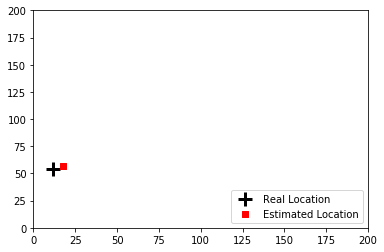

2
infered loc:
[18.         57.03246753]
real loc:
[11.98065 54.01716]


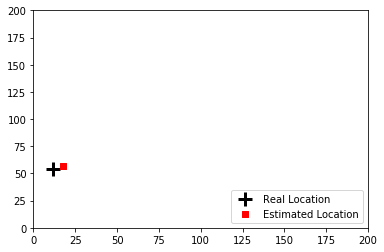

3
infered loc:
[18.         57.03246753]
real loc:
[11.98387 54.0143 ]


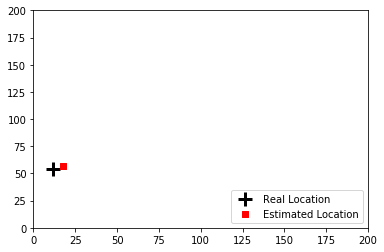

4
infered loc:
[18.         57.03246753]
real loc:
[11.9871  54.01144]


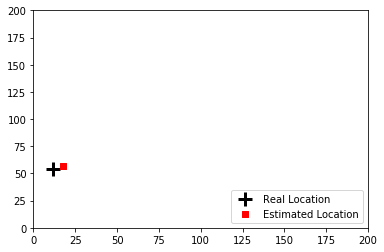

5
infered loc:
[18.         57.03246753]
real loc:
[11.99032 54.00858]


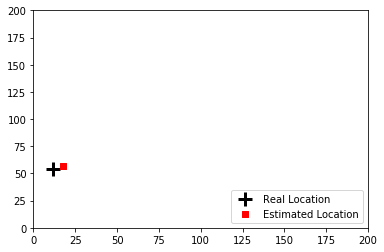

6
infered loc:
[18.         57.03246753]
real loc:
[11.99355 54.00572]


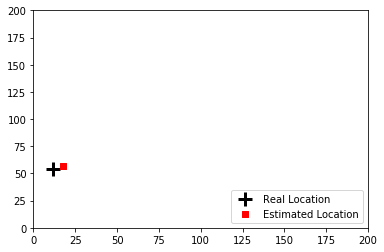

7
infered loc:
[18.         57.03246753]
real loc:
[12. 54.]


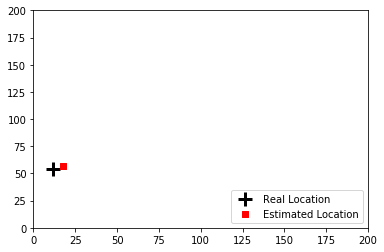

8
infered loc:
[18.         57.03246753]
real loc:
[nan nan]


C:\Users\shada\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\shada\Anaconda3\lib\site-packages\numpy\core\_methods.py:73: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


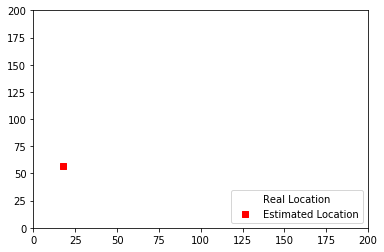

9
infered loc:
[18.         57.03246753]
real loc:
[nan nan]


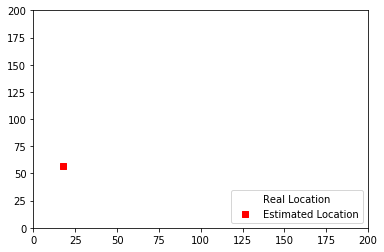

10
infered loc:
[18.         57.03246753]
real loc:
[nan nan]


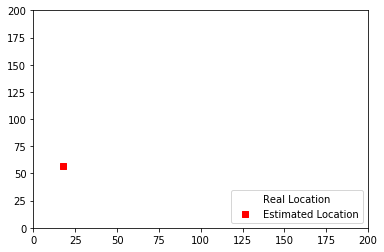

11
infered loc:
[18.         57.03246753]
real loc:
[nan nan]


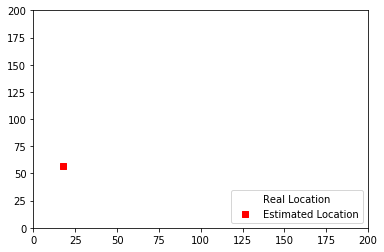

12
infered loc:
[18.         57.03246753]
real loc:
[nan nan]


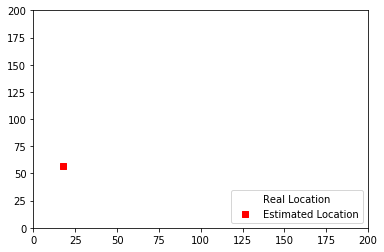

13
infered loc:
[18.         57.03246753]
real loc:
[nan nan]


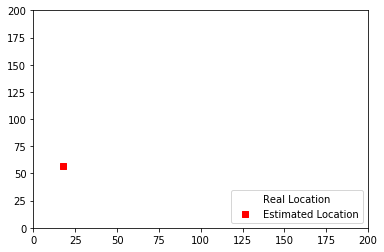

14
infered loc:
[18.         57.03246753]
real loc:
[nan nan]


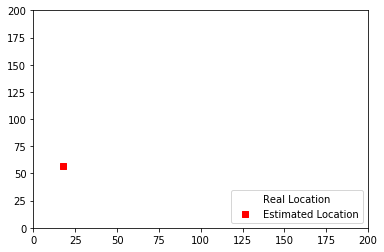

15
infered loc:
[18.         57.03246753]
real loc:
[nan nan]


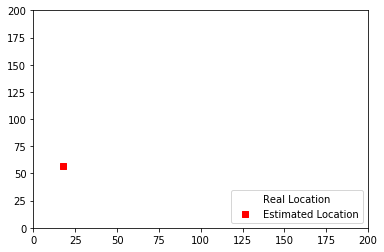

16
infered loc:
[18.         57.03246753]
real loc:
[nan nan]


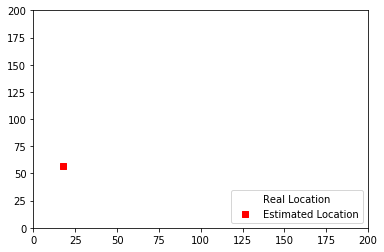

17
infered loc:
[18.         57.03246753]
real loc:
[nan nan]


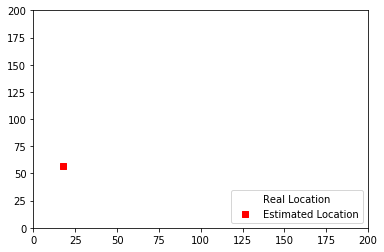

18
infered loc:
[18.         57.03246753]
real loc:
[15.66667 50.5    ]


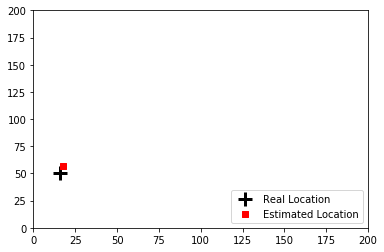

19
infered loc:
[18. 48.]
real loc:
[26.66667 40.     ]


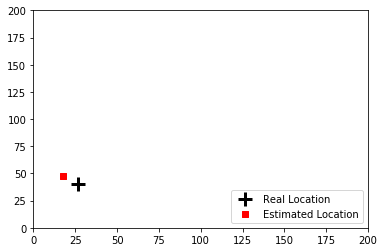

289
infered loc:
[45.         40.03246753]
real loc:
[41.8 42.6]


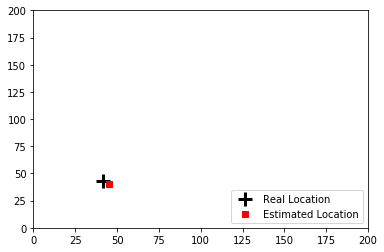

290
infered loc:
[51. 46.]
real loc:
[49.6 52.2]


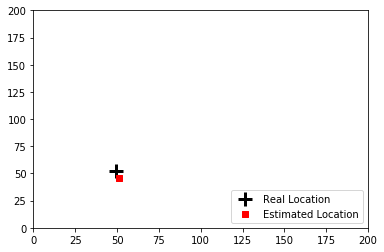

291
infered loc:
[55.86956522 60.08695652]
real loc:
[60. 65.]


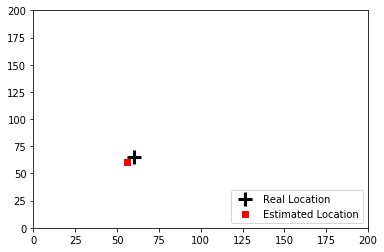

292
infered loc:
[55.86956522 60.08695652]
real loc:
[nan nan]


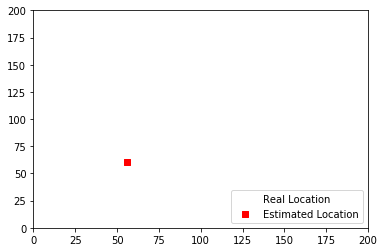

293
infered loc:
[55.86956522 60.08695652]
real loc:
[nan nan]


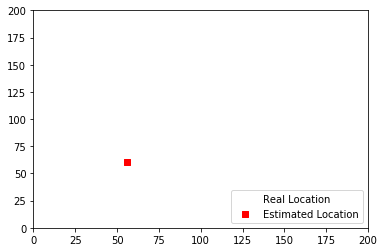

294
infered loc:
[55.86956522 60.08695652]
real loc:
[nan nan]


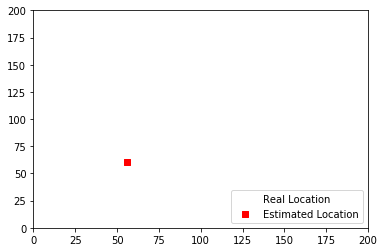

295
infered loc:
[55.86956522 60.08695652]
real loc:
[nan nan]


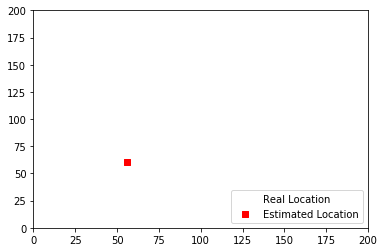

296
infered loc:
[55.86956522 60.08695652]
real loc:
[nan nan]


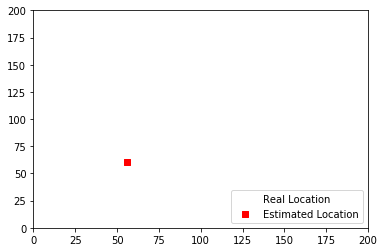

297
infered loc:
[55.86956522 60.08695652]
real loc:
[nan nan]


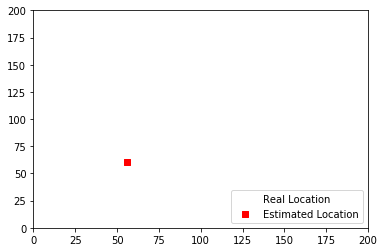

298
infered loc:
[55.86956522 60.08695652]
real loc:
[nan nan]


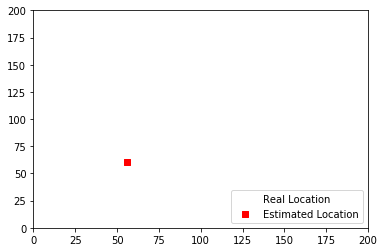

299
infered loc:
[55.86956522 60.08695652]
real loc:
[nan nan]


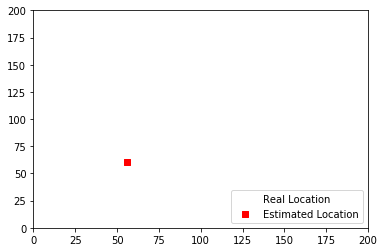

300
infered loc:
[54.06930693 68.04950495]
real loc:
[nan nan]


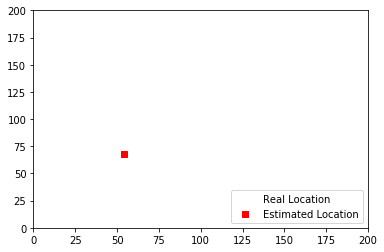

301
infered loc:
[49.96742671 10.03257329]
real loc:
[42.  5.]


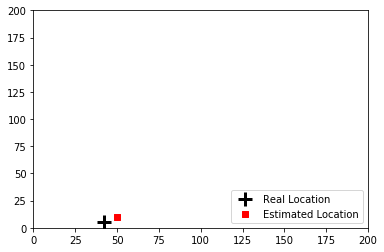

302
infered loc:
[49.96742671 10.03257329]
real loc:
[nan nan]


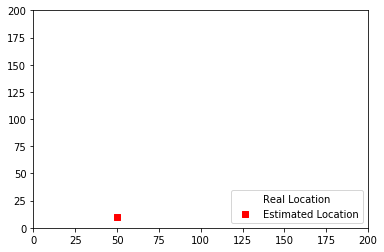

303
infered loc:
[49.96742671 10.03257329]
real loc:
[nan nan]


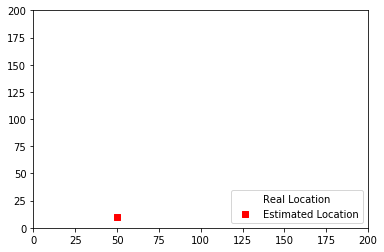

304
infered loc:
[49.96742671 10.03257329]
real loc:
[nan nan]


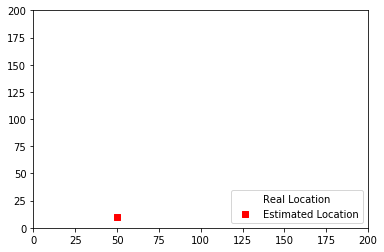

305
infered loc:
[49.96742671 10.03257329]
real loc:
[nan nan]


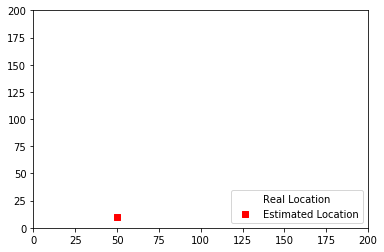

306
infered loc:
[49.96742671 10.03257329]
real loc:
[nan nan]


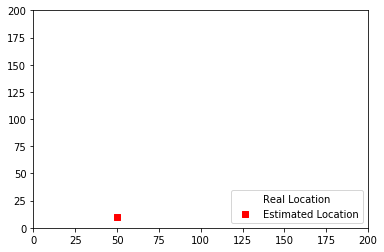

307
infered loc:
[49.96742671 10.03257329]
real loc:
[nan nan]


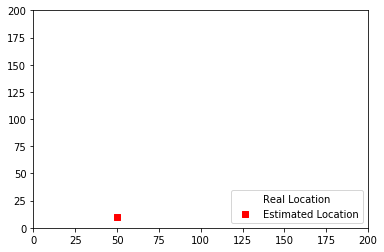

308
infered loc:
[49.96742671 10.03257329]
real loc:
[nan nan]


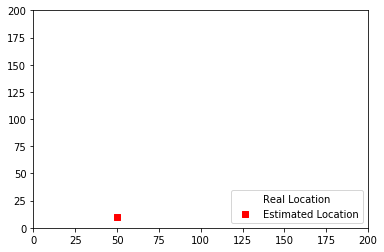

309
infered loc:
[49.96742671 10.03257329]
real loc:
[nan nan]


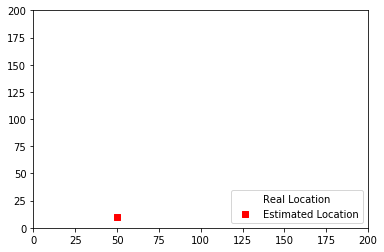

310
infered loc:
[49.96742671 10.03257329]
real loc:
[nan nan]


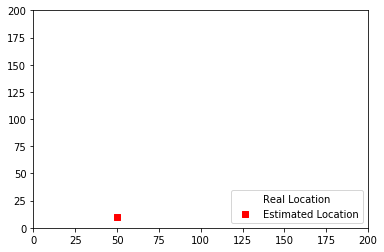

311
infered loc:
[49.96742671 10.03257329]
real loc:
[nan nan]


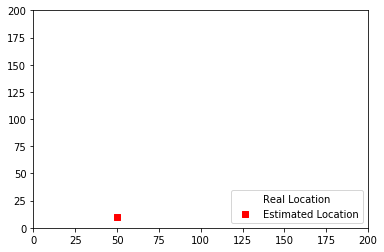

312
infered loc:
[49.96742671 10.03257329]
real loc:
[nan nan]


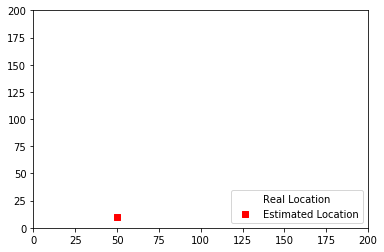

313
infered loc:
[49.96742671 10.03257329]
real loc:
[nan nan]


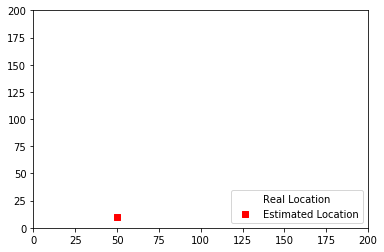

314
infered loc:
[54.06930693 68.04950495]
real loc:
[nan nan]


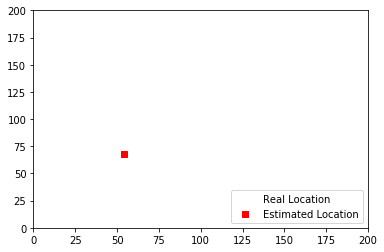

315
infered loc:
[54.06930693 68.04950495]
real loc:
[nan nan]


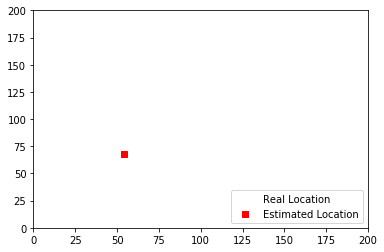

316
infered loc:
[54.06930693 68.04950495]
real loc:
[nan nan]


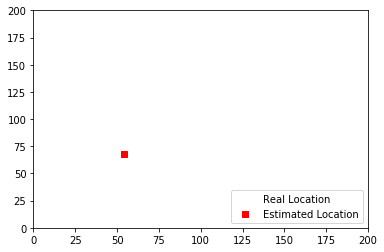

317
infered loc:
[54.06930693 68.04950495]
real loc:
[nan nan]


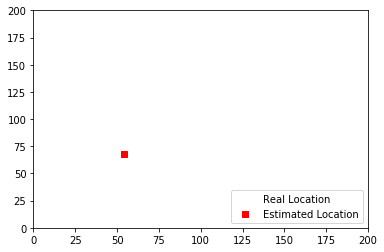

318
infered loc:
[54.06930693 68.04950495]
real loc:
[nan nan]


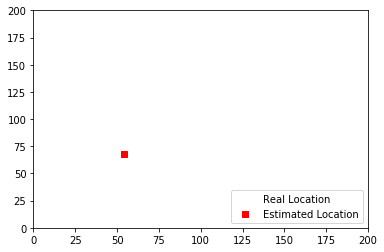

319
infered loc:
[54.06930693 68.04950495]
real loc:
[nan nan]


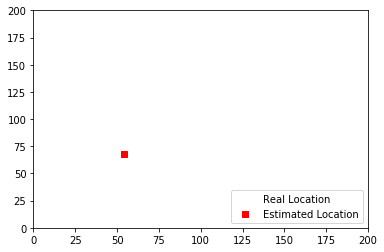

320
infered loc:
[54.06930693 68.04950495]
real loc:
[nan nan]


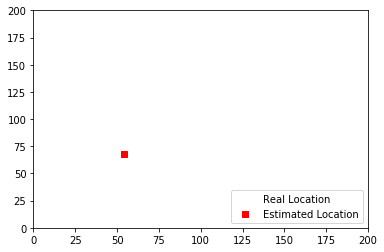

321
infered loc:
[54.06930693 68.04950495]
real loc:
[nan nan]


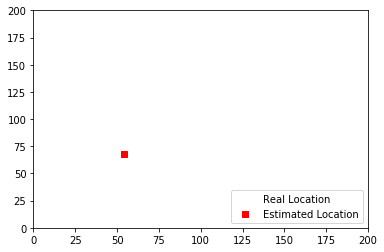

322
infered loc:
[54.06930693 68.04950495]
real loc:
[nan nan]


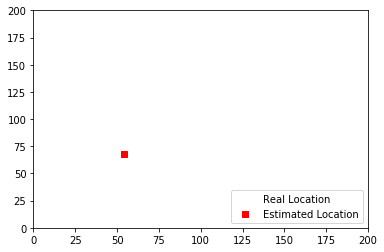

323
infered loc:
[54.06930693 68.04950495]
real loc:
[nan nan]


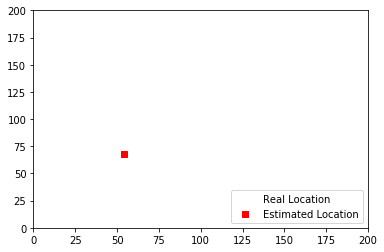

324
infered loc:
[54.06930693 68.04950495]
real loc:
[nan nan]


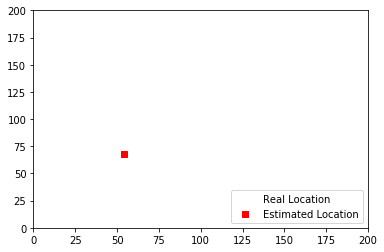

325
infered loc:
[54.06930693 68.04950495]
real loc:
[nan nan]


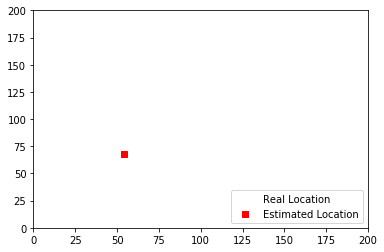

326
infered loc:
[54.06930693 68.04950495]
real loc:
[nan nan]


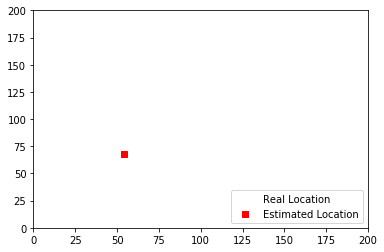

327
infered loc:
[54.06930693 68.04950495]
real loc:
[nan nan]


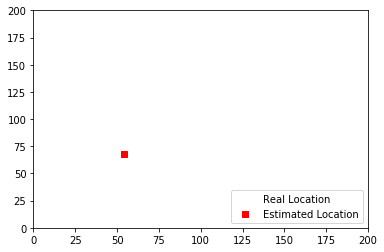

328
infered loc:
[54.06930693 68.04950495]
real loc:
[nan nan]


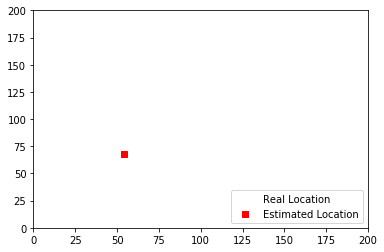

329
infered loc:
[54.06930693 68.04950495]
real loc:
[nan nan]


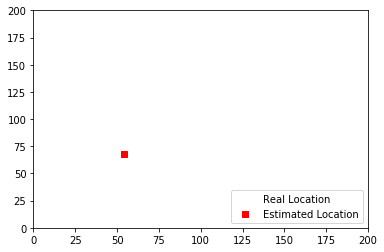

330
infered loc:
[54.06930693 68.04950495]
real loc:
[nan nan]


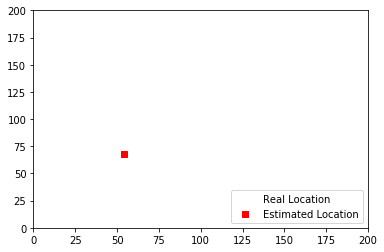

331
infered loc:
[54.06930693 68.04950495]
real loc:
[nan nan]


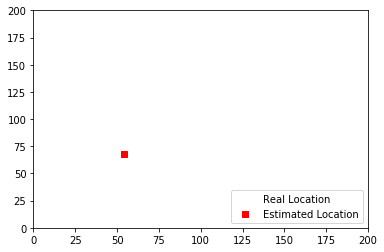

332
infered loc:
[54.06930693 68.04950495]
real loc:
[nan nan]


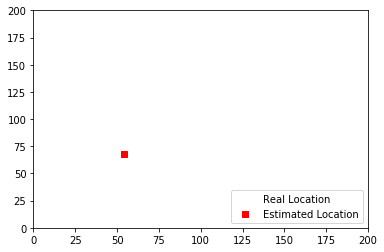

333
infered loc:
[54.06930693 68.04950495]
real loc:
[nan nan]


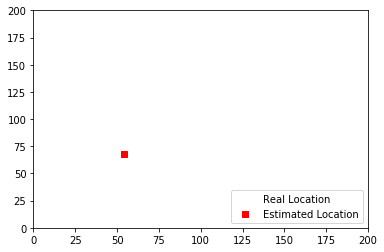

334
infered loc:
[54.06930693 68.04950495]
real loc:
[nan nan]


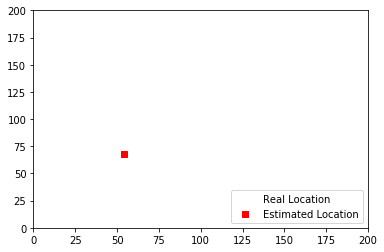

335
infered loc:
[54.06930693 68.04950495]
real loc:
[nan nan]


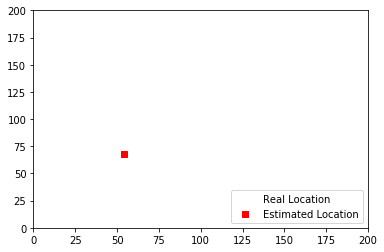

336
infered loc:
[54.06930693 68.04950495]
real loc:
[nan nan]


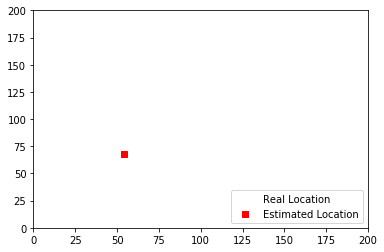

337
infered loc:
[54.06930693 68.04950495]
real loc:
[nan nan]


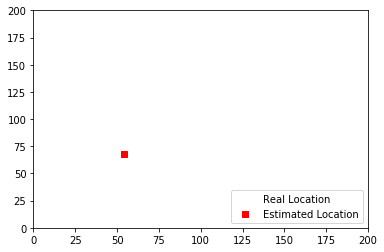

338
infered loc:
[54.06930693 68.04950495]
real loc:
[nan nan]


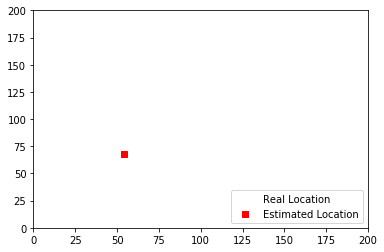

339
infered loc:
[54.06930693 68.04950495]
real loc:
[nan nan]


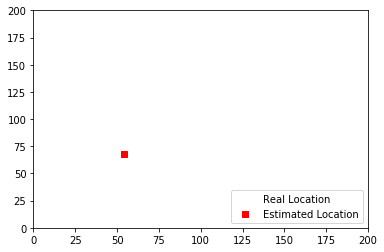

340
infered loc:
[54.06930693 68.04950495]
real loc:
[nan nan]


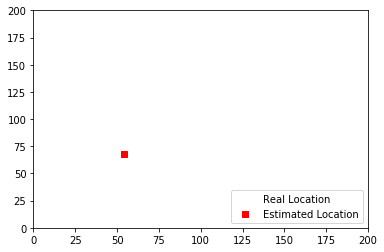

341
infered loc:
[54.06930693 68.04950495]
real loc:
[nan nan]


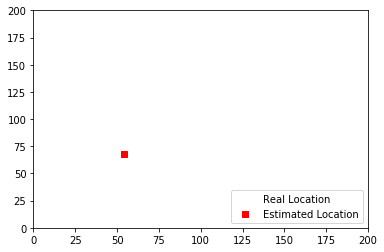

342
infered loc:
[54.06930693 68.04950495]
real loc:
[nan nan]


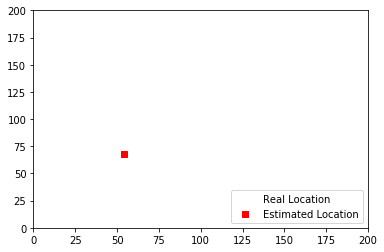

343
infered loc:
[54.06930693 68.04950495]
real loc:
[nan nan]


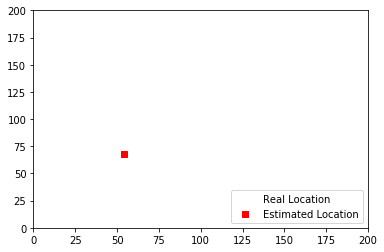

344
infered loc:
[54.06930693 68.04950495]
real loc:
[nan nan]


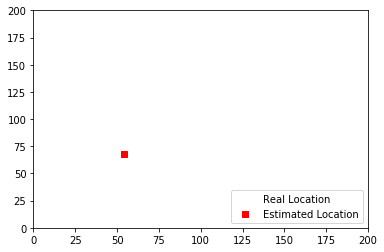

345
infered loc:
[54.06930693 68.04950495]
real loc:
[nan nan]


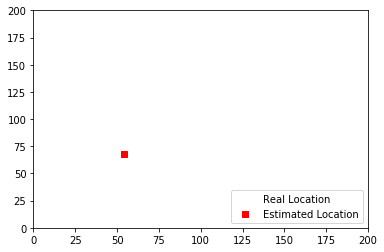

346
infered loc:
[54.06930693 68.04950495]
real loc:
[nan nan]


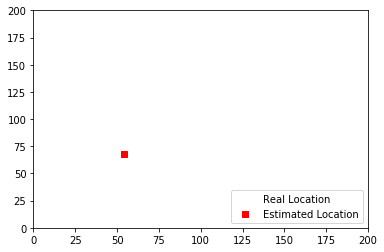

347
infered loc:
[54.06930693 68.04950495]
real loc:
[nan nan]


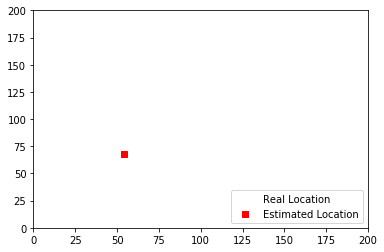

348
infered loc:
[54.06930693 68.04950495]
real loc:
[61.33333 68.     ]


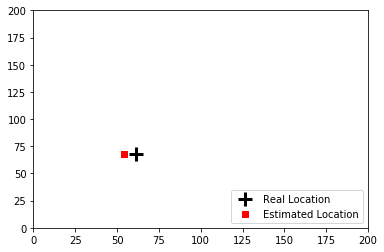

349
infered loc:
[54.06930693 68.04950495]
real loc:
[64. 74.]


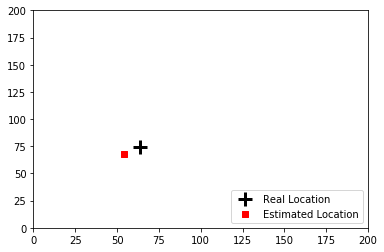

350
infered loc:
[54.06930693 68.04950495]
real loc:
[nan nan]


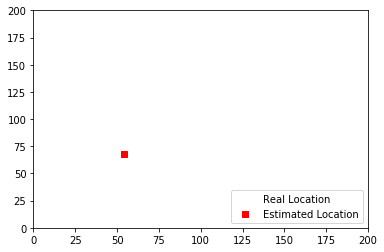

351
infered loc:
[54.06930693 68.04950495]
real loc:
[nan nan]


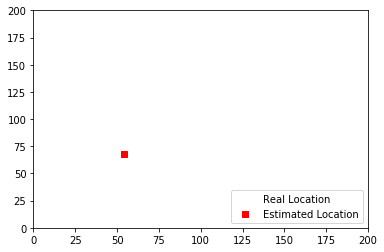

352
infered loc:
[54.06930693 68.04950495]
real loc:
[nan nan]


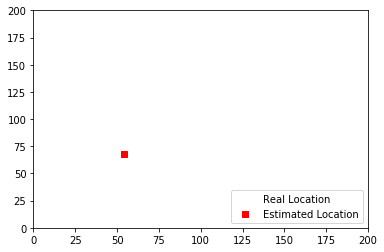

353
infered loc:
[54.06930693 68.04950495]
real loc:
[nan nan]


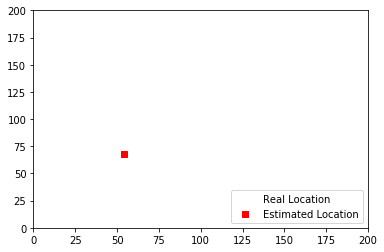

354
infered loc:
[54.06930693 68.04950495]
real loc:
[nan nan]


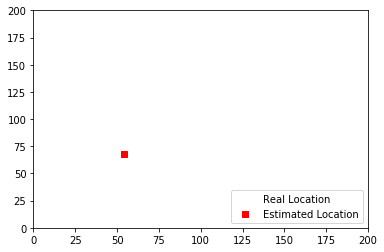

355
infered loc:
[54.06930693 68.04950495]
real loc:
[nan nan]


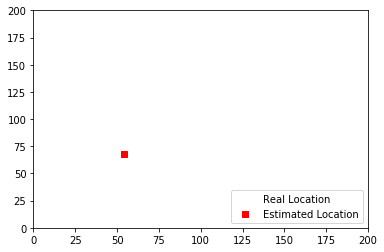

356
infered loc:
[54.06930693 68.04950495]
real loc:
[nan nan]


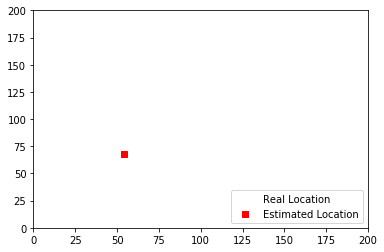

357
infered loc:
[54.06930693 68.04950495]
real loc:
[nan nan]


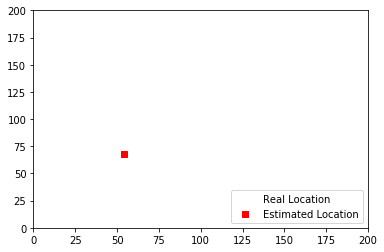

358
infered loc:
[54.06930693 68.04950495]
real loc:
[nan nan]


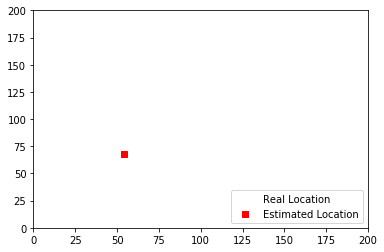

359
infered loc:
[54.06930693 68.04950495]
real loc:
[nan nan]


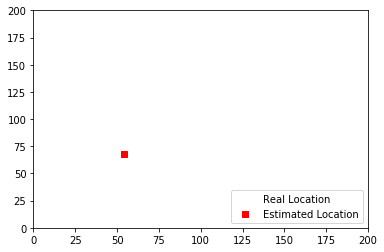

360
infered loc:
[54.06930693 68.04950495]
real loc:
[nan nan]


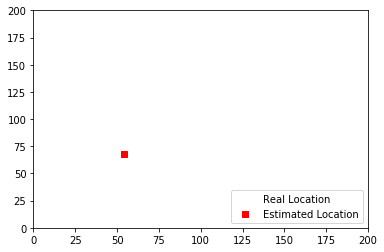

361
infered loc:
[54.06930693 68.04950495]
real loc:
[nan nan]


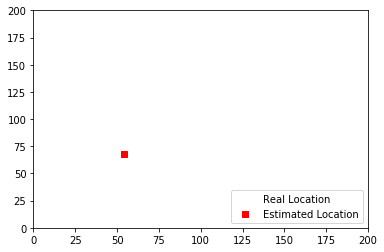

362
infered loc:
[54.06930693 68.04950495]
real loc:
[nan nan]


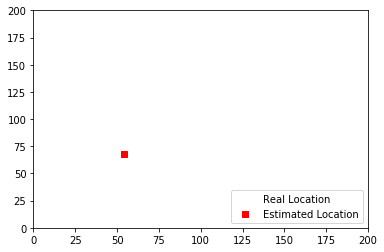

363
infered loc:
[55.86956522 60.08695652]
real loc:
[60. 49.]


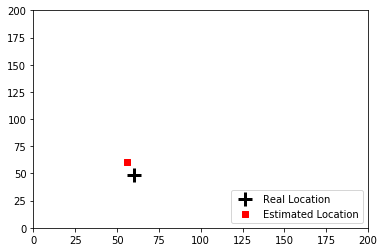

364
infered loc:
[55.86956522 60.08695652]
real loc:
[52.5     57.66667]


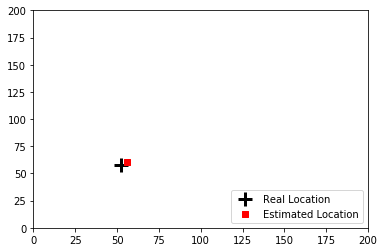

365
infered loc:
[49.5 57. ]
real loc:
[45.      66.33333]


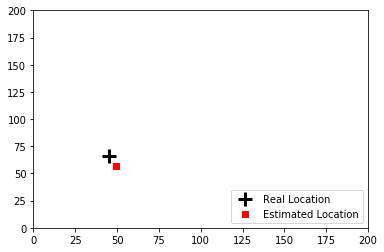

374
infered loc:
[49.5 57. ]
real loc:
[41.18182 70.74545]


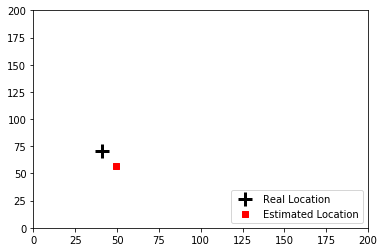

375
infered loc:
[49.5 57. ]
real loc:
[42.40909 69.32727]


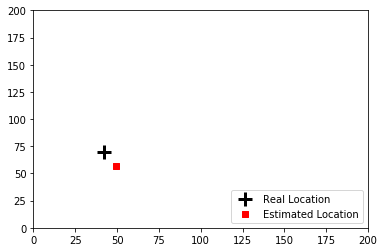

376
infered loc:
[49.5 57. ]
real loc:
[43.63636 67.90909]


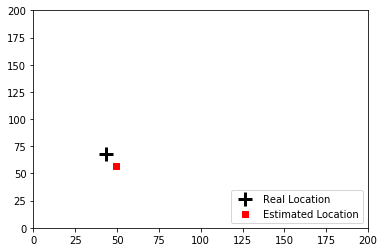

377
infered loc:
[49.5 57. ]
real loc:
[44.86364 66.49091]


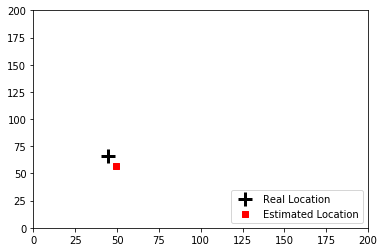

378
infered loc:
[49.5 57. ]
real loc:
[45.27273 66.01818]


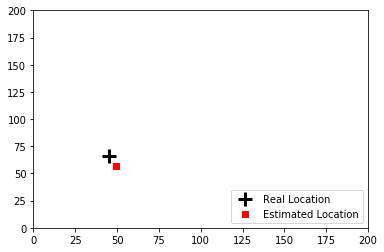

379
infered loc:
[49.5 57. ]
real loc:
[45.68182 65.54545]


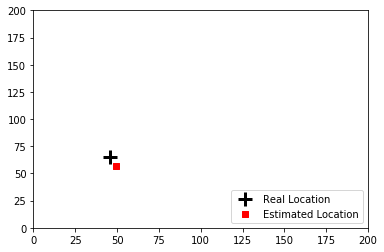

380
infered loc:
[49.5 57. ]
real loc:
[46.09091 65.07273]


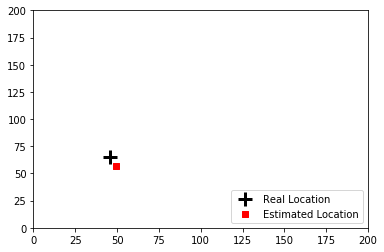

381
infered loc:
[49.5 57. ]
real loc:
[46.5 64.6]


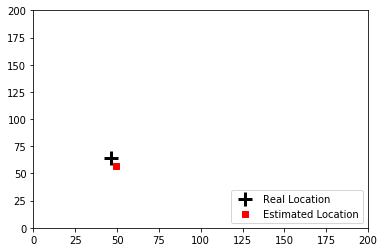

382
infered loc:
[49.5 57. ]
real loc:
[46.90909 64.12727]


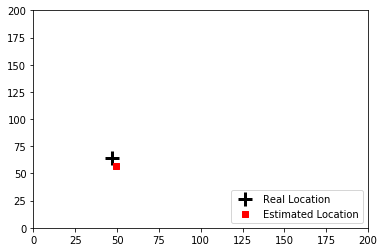

383
infered loc:
[49.5 57. ]
real loc:
[47.31818 63.65455]


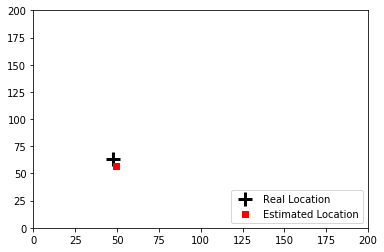

384
infered loc:
[49.5 57. ]
real loc:
[48.54545 62.23636]


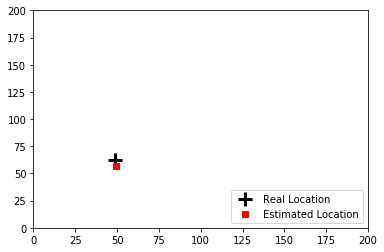

385
infered loc:
[49.5 57. ]
real loc:
[49.77273 60.81818]


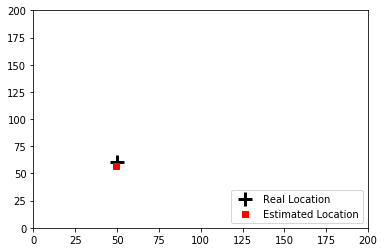

386
infered loc:
[49.5 57. ]
real loc:
[50.18182 60.34545]


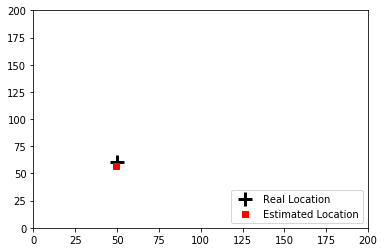

387
infered loc:
[49.5 57. ]
real loc:
[50.59091 59.87273]


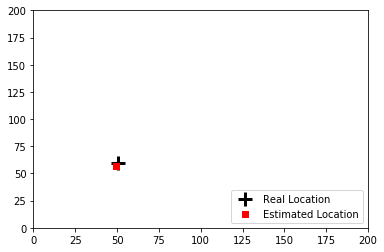

388
infered loc:
[49.5 57. ]
real loc:
[51.  59.4]


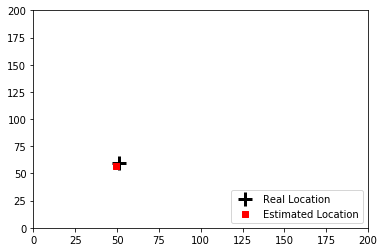

389
infered loc:
[49.5 57. ]
real loc:
[51.  59.4]


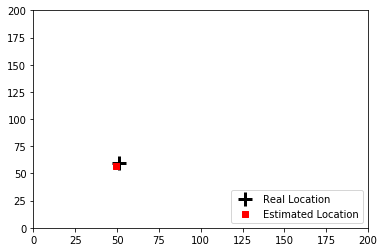

390
infered loc:
[49.5 57. ]
real loc:
[51.40909 58.92727]


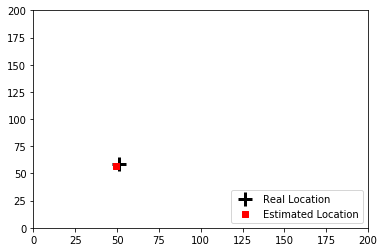

391
infered loc:
[49.5 57. ]
real loc:
[51.40909 58.92727]


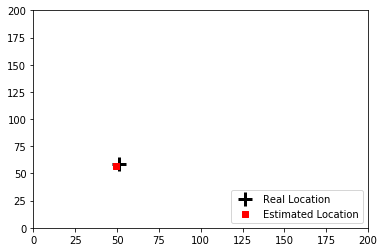

392
infered loc:
[49.5 57. ]
real loc:
[51.81818 58.45455]


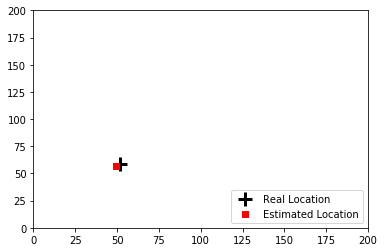

393
infered loc:
[49.5 57. ]
real loc:
[52.22727 57.98182]


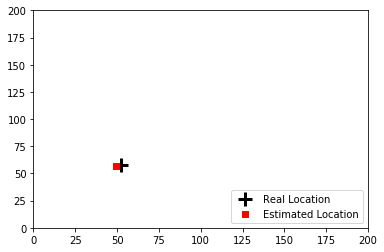

394
infered loc:
[49.5 57. ]
real loc:
[52.63636 57.50909]


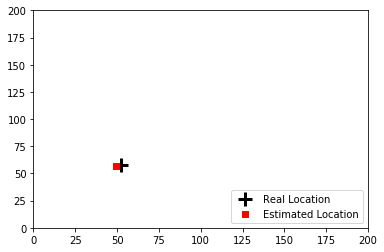

395
infered loc:
[49.5 57. ]
real loc:
[55.5 54.2]


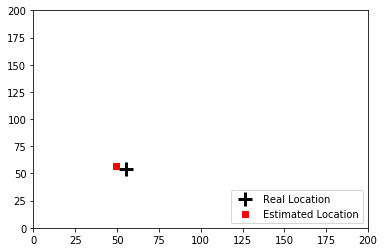

396
infered loc:
[49.5 57. ]
real loc:
[55.90909 53.72727]


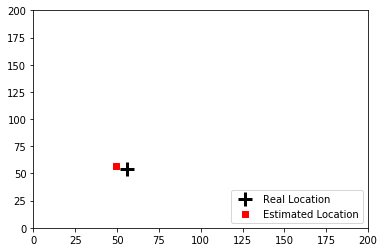

397
infered loc:
[49.5 57. ]
real loc:
[56.31818 53.25455]


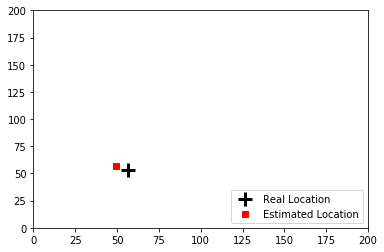

398
infered loc:
[49.5 57. ]
real loc:
[56.72727 52.78182]


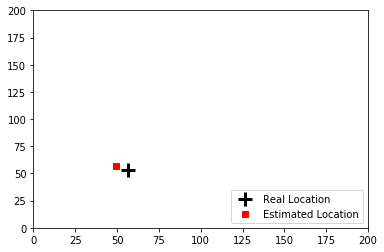

399
infered loc:
[49.5 57. ]
real loc:
[57.13636 52.30909]


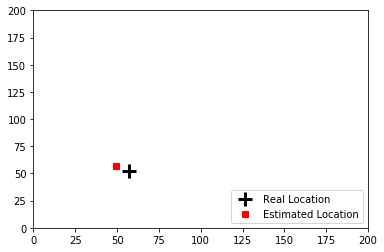

400
infered loc:
[54.06930693 52.04950495]
real loc:
[57.54545 51.83636]


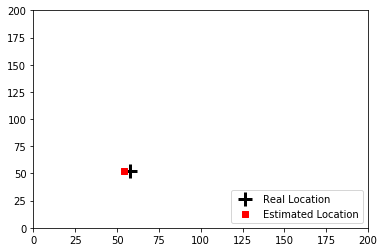

401
infered loc:
[54.06930693 52.04950495]
real loc:
[57.95455 51.36364]


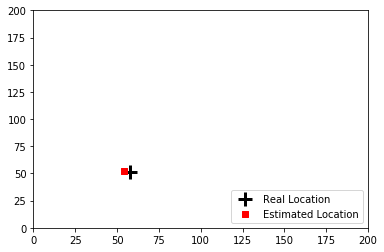

402
infered loc:
[54.06930693 52.04950495]
real loc:
[58.36364 50.89091]


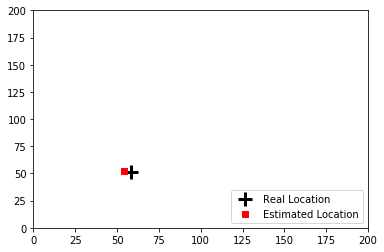

403
infered loc:
[54.06930693 52.04950495]
real loc:
[58.77273 50.41818]


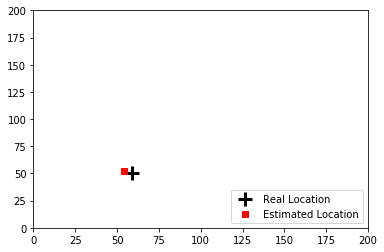

404
infered loc:
[54.06930693 52.04950495]
real loc:
[59.18182 49.94545]


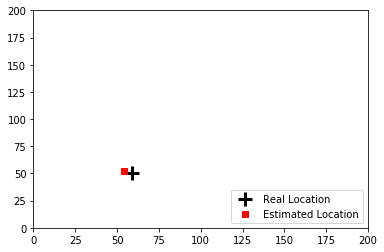

405
infered loc:
[12.         86.03246753]
real loc:
[18.  80.4]


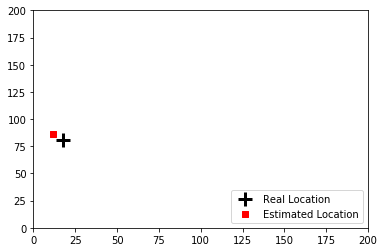

406
infered loc:
[16.5 78.5]
real loc:
[18.  80.4]


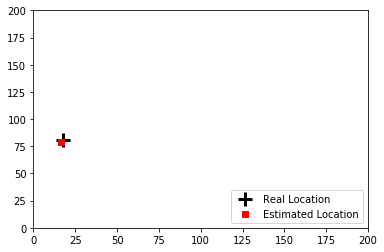

407
infered loc:
[16.5 78.5]
real loc:
[29.5 71. ]


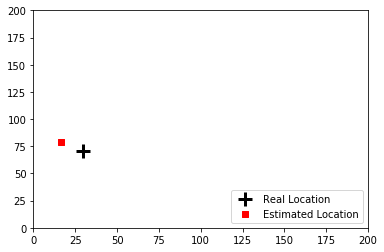

408
infered loc:
[16.5 78.5]
real loc:
[nan nan]


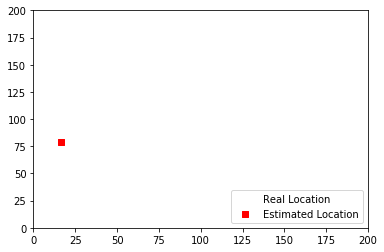

409
infered loc:
[16.5 78.5]
real loc:
[nan nan]


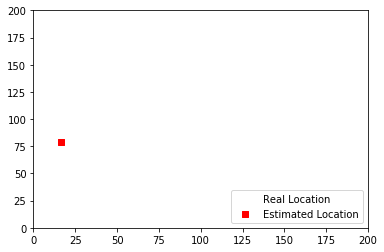

410
infered loc:
[16.5 78.5]
real loc:
[nan nan]


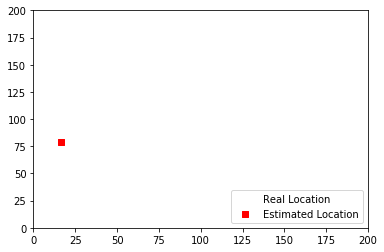

411
infered loc:
[16.5 78.5]
real loc:
[nan nan]


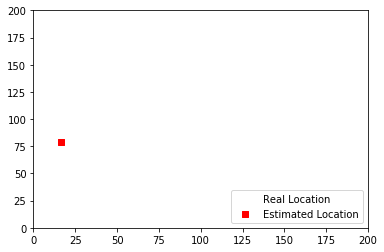

412
infered loc:
[16.5 78.5]
real loc:
[nan nan]


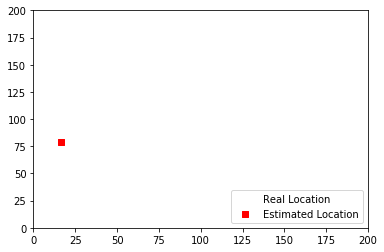

413
infered loc:
[16.5 78.5]
real loc:
[nan nan]


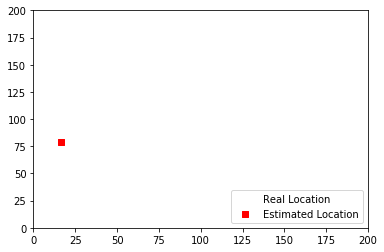

414
infered loc:
[16.5 78.5]
real loc:
[nan nan]


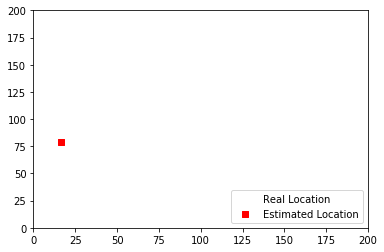

415
infered loc:
[16.5 78.5]
real loc:
[nan nan]


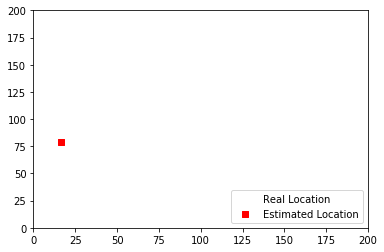

416
infered loc:
[16.5 78.5]
real loc:
[nan nan]


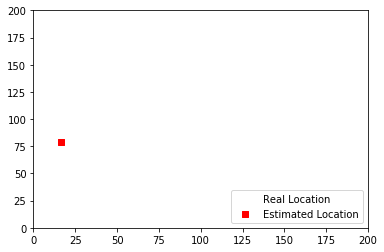

417
infered loc:
[24.         95.53146853]
real loc:
[ 25. 102.]


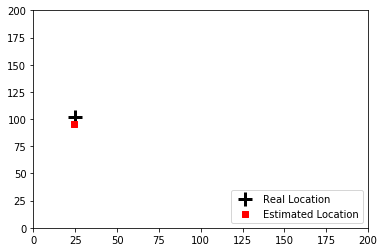

418
infered loc:
[24.         95.53146853]
real loc:
[nan nan]


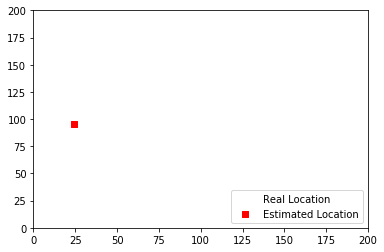

419
infered loc:
[24.         95.53146853]
real loc:
[nan nan]


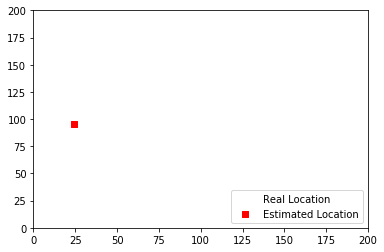

420
infered loc:
[24.         95.53146853]
real loc:
[nan nan]


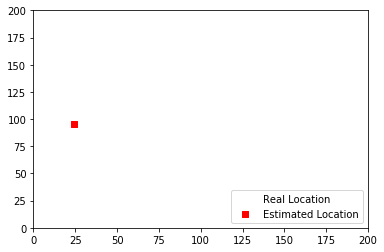

421
infered loc:
[24.         95.53146853]
real loc:
[nan nan]


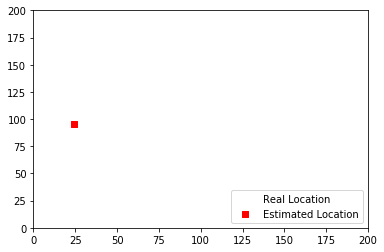

422
infered loc:
[24.         95.53146853]
real loc:
[ 18.5 102. ]


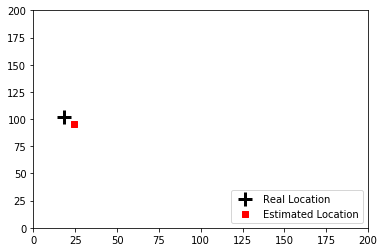

423
infered loc:
[24.         95.53146853]
real loc:
[ 21.75 102.  ]


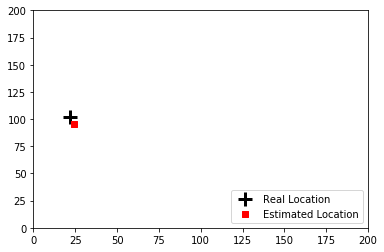

424
infered loc:
[24.         95.53146853]
real loc:
[nan nan]


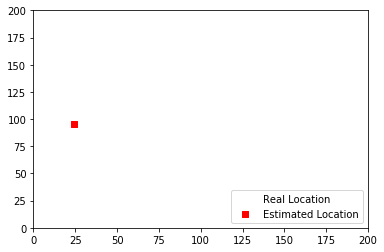

427
infered loc:
[21.         71.03246753]
real loc:
[nan nan]


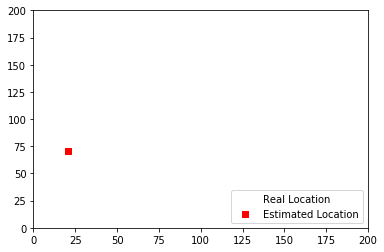

428
infered loc:
[21.         71.03246753]
real loc:
[nan nan]


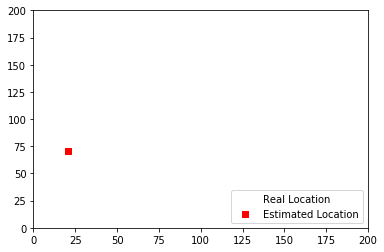

429
infered loc:
[21.         71.03246753]
real loc:
[nan nan]


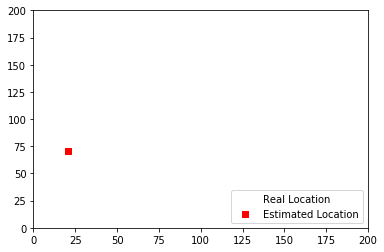

430
infered loc:
[21.         71.03246753]
real loc:
[nan nan]


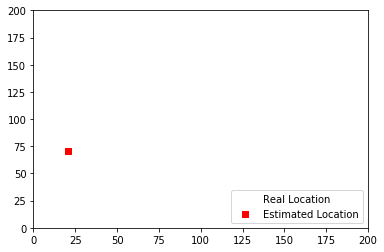

431
infered loc:
[21.         71.03246753]
real loc:
[nan nan]


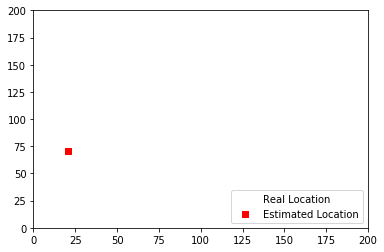

432
infered loc:
[21.         71.03246753]
real loc:
[nan nan]


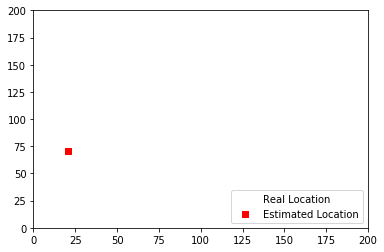

433
infered loc:
[21.         71.03246753]
real loc:
[nan nan]


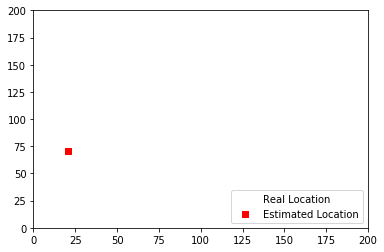

434
infered loc:
[21.         71.03246753]
real loc:
[nan nan]


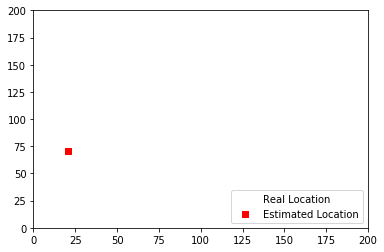

435
infered loc:
[21.         71.03246753]
real loc:
[nan nan]


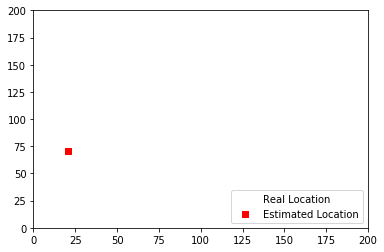

436
infered loc:
[21.         71.03246753]
real loc:
[nan nan]


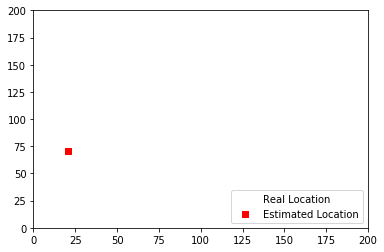

437
infered loc:
[21.         71.03246753]
real loc:
[nan nan]


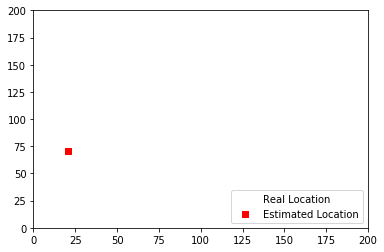

438
infered loc:
[21.         71.03246753]
real loc:
[nan nan]


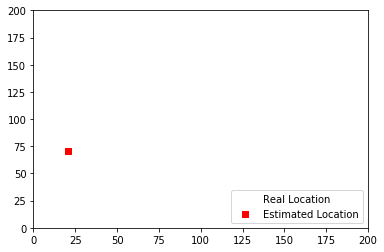

439
infered loc:
[21.         71.03246753]
real loc:
[nan nan]


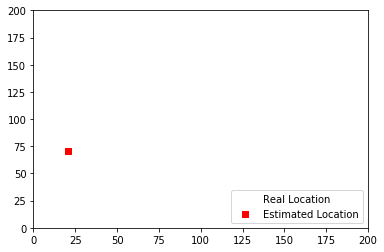

440
infered loc:
[21.         71.03246753]
real loc:
[nan nan]


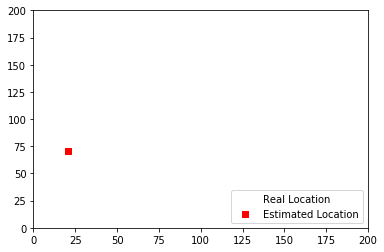

441
infered loc:
[21.         71.03246753]
real loc:
[nan nan]


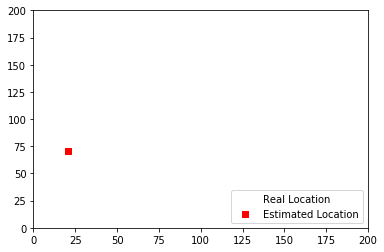

442
infered loc:
[21.         71.03246753]
real loc:
[nan nan]


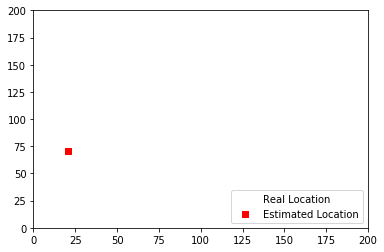

443
infered loc:
[21.         71.03246753]
real loc:
[nan nan]


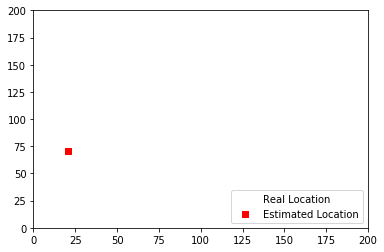

444
infered loc:
[21.         71.03246753]
real loc:
[nan nan]


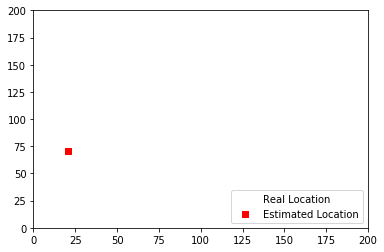

445
infered loc:
[21.         71.03246753]
real loc:
[nan nan]


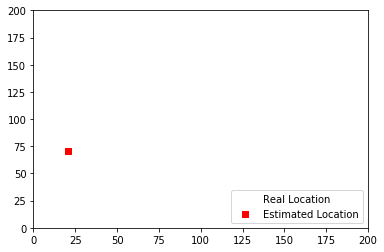

446
infered loc:
[21.         71.03246753]
real loc:
[nan nan]


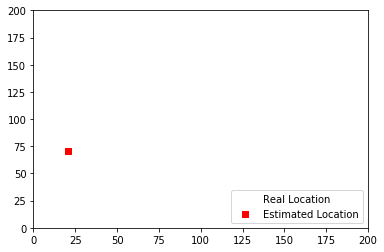

447
infered loc:
[21.         71.03246753]
real loc:
[nan nan]


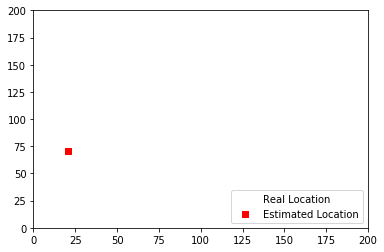

448
infered loc:
[21.         71.03246753]
real loc:
[nan nan]


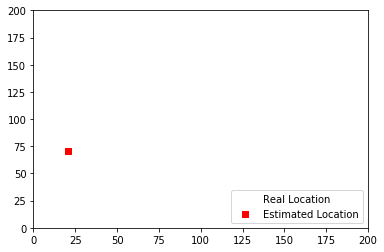

449
infered loc:
[21.         71.03246753]
real loc:
[nan nan]


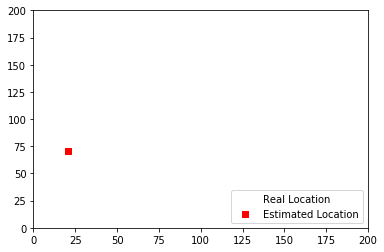

450
infered loc:
[21.         71.03246753]
real loc:
[nan nan]


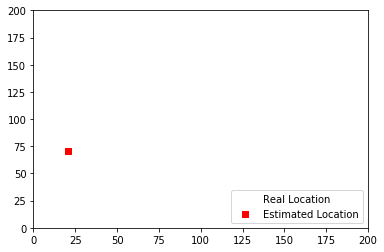

451
infered loc:
[21.         71.03246753]
real loc:
[nan nan]


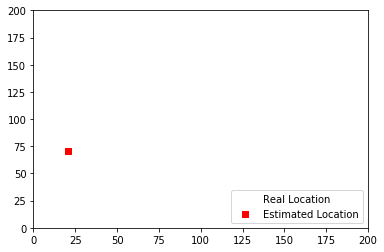

452
infered loc:
[21.         71.03246753]
real loc:
[nan nan]


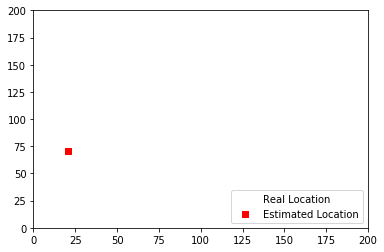

453
infered loc:
[21.         71.03246753]
real loc:
[nan nan]


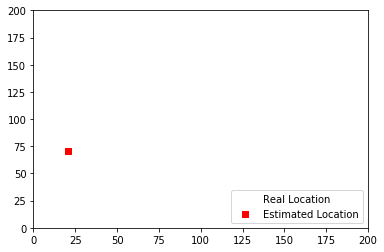

454
infered loc:
[21.         71.03246753]
real loc:
[nan nan]


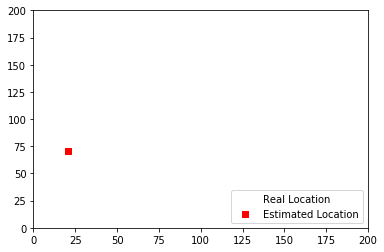

455
infered loc:
[24.         95.53146853]
real loc:
[nan nan]


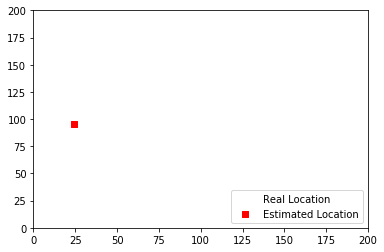

456
infered loc:
[24.         95.53146853]
real loc:
[nan nan]


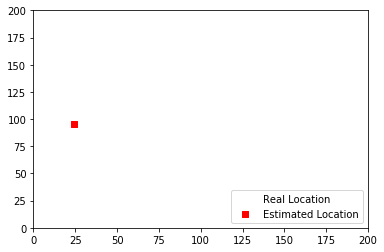

457
infered loc:
[24.         95.53146853]
real loc:
[nan nan]


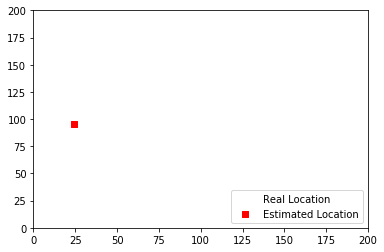

458
infered loc:
[24.         95.53146853]
real loc:
[nan nan]


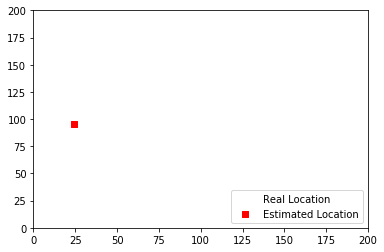

459
infered loc:
[24.         95.53146853]
real loc:
[nan nan]


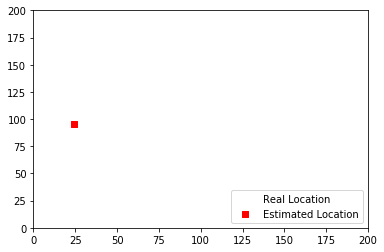

461
infered loc:
[21.         71.03246753]
real loc:
[nan nan]


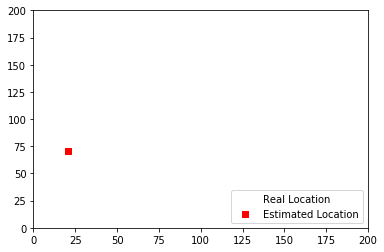

462
infered loc:
[21.         71.03246753]
real loc:
[nan nan]


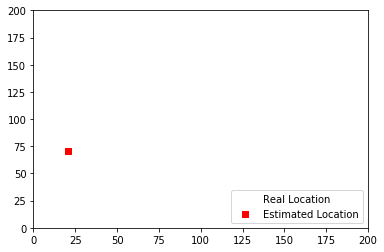

463
infered loc:
[21.         71.03246753]
real loc:
[nan nan]


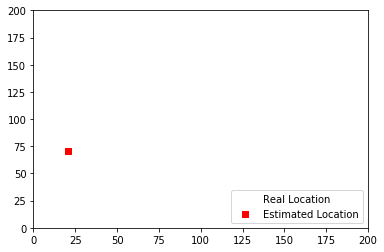

464
infered loc:
[21.         71.03246753]
real loc:
[nan nan]


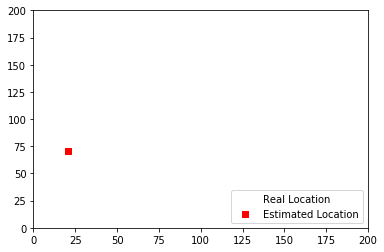

465
infered loc:
[21.         71.03246753]
real loc:
[nan nan]


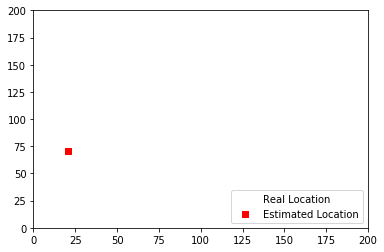

466
infered loc:
[21.         71.03246753]
real loc:
[nan nan]


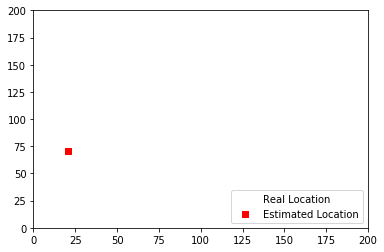

467
infered loc:
[21.         71.03246753]
real loc:
[nan nan]


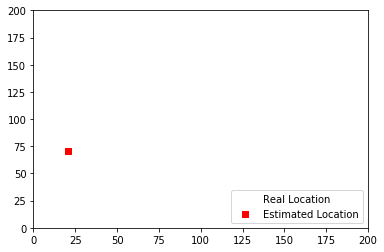

468
infered loc:
[21.         71.03246753]
real loc:
[nan nan]


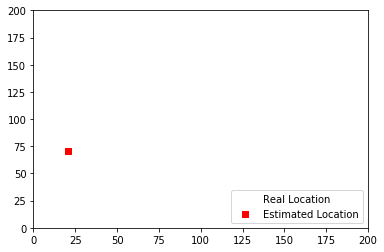

469
infered loc:
[21.         71.03246753]
real loc:
[nan nan]


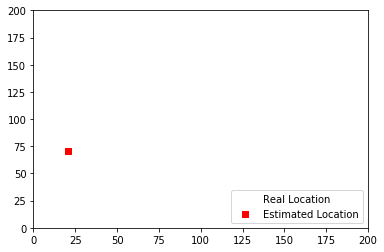

470
infered loc:
[21.         71.03246753]
real loc:
[nan nan]


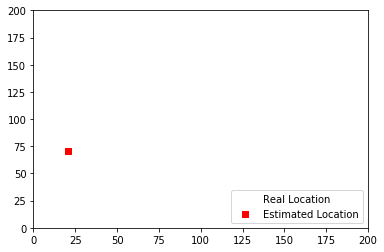

471
infered loc:
[21.         71.03246753]
real loc:
[nan nan]


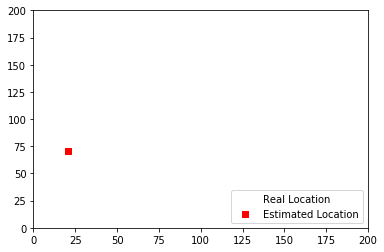

472
infered loc:
[21.         71.03246753]
real loc:
[nan nan]


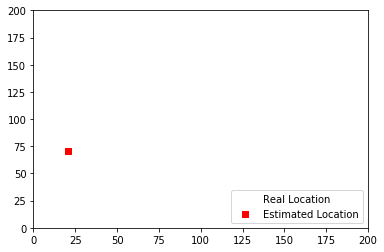

473
infered loc:
[21.         71.03246753]
real loc:
[nan nan]


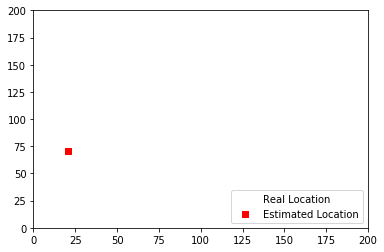

474
infered loc:
[21.         71.03246753]
real loc:
[nan nan]


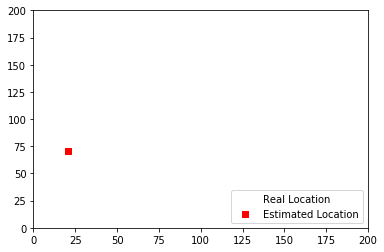

475
infered loc:
[21.         71.03246753]
real loc:
[nan nan]


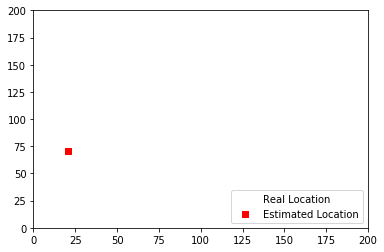

476
infered loc:
[21.         71.03246753]
real loc:
[nan nan]


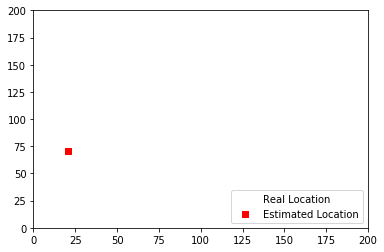

477
infered loc:
[21.         71.03246753]
real loc:
[nan nan]


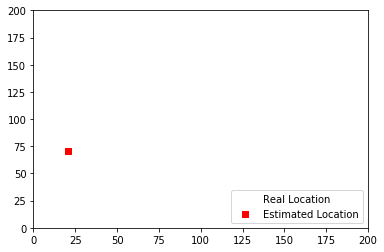

478
infered loc:
[21.         71.03246753]
real loc:
[nan nan]


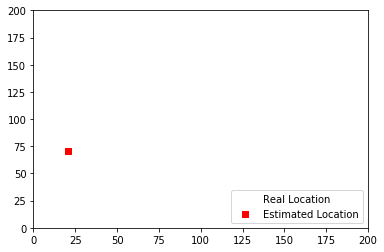

479
infered loc:
[21.         71.03246753]
real loc:
[nan nan]


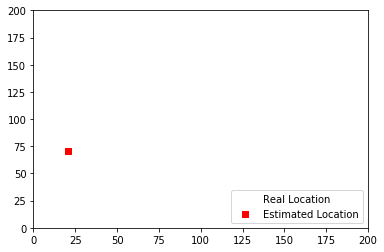

480
infered loc:
[21.         71.03246753]
real loc:
[nan nan]


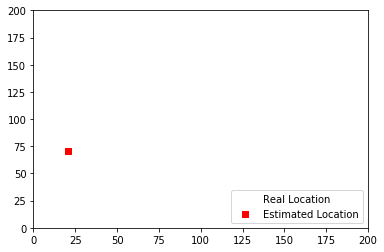

481
infered loc:
[21.         71.03246753]
real loc:
[nan nan]


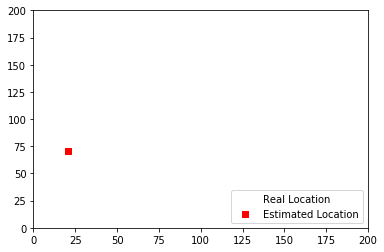

482
infered loc:
[21.         71.03246753]
real loc:
[nan nan]


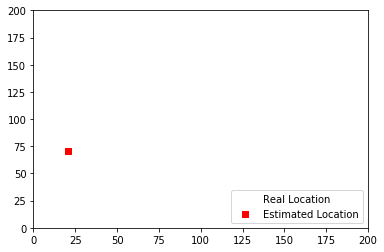

483
infered loc:
[21.         71.03246753]
real loc:
[nan nan]


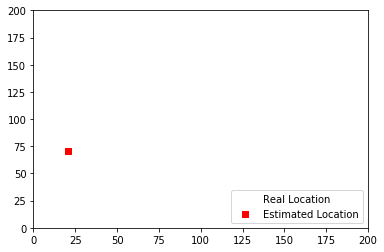

484
infered loc:
[21.         71.03246753]
real loc:
[nan nan]


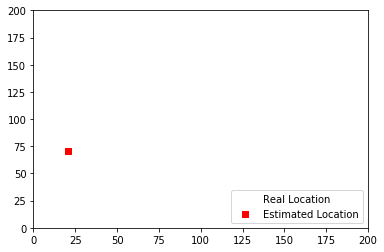

485
infered loc:
[21.         71.03246753]
real loc:
[nan nan]


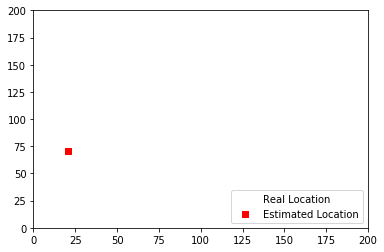

486
infered loc:
[21.         71.03246753]
real loc:
[nan nan]


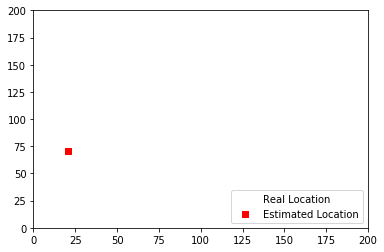

487
infered loc:
[21.         71.03246753]
real loc:
[nan nan]


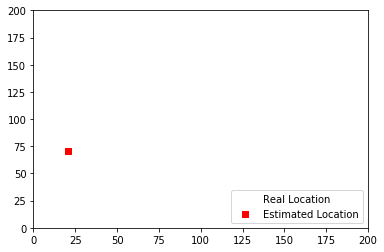

488
infered loc:
[21.         71.03246753]
real loc:
[nan nan]


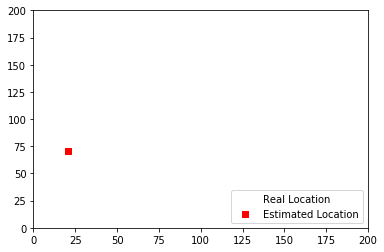

489
infered loc:
[21.         71.03246753]
real loc:
[nan nan]


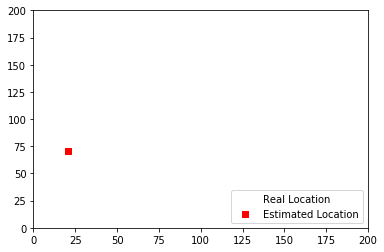

490
infered loc:
[21.         71.03246753]
real loc:
[nan nan]


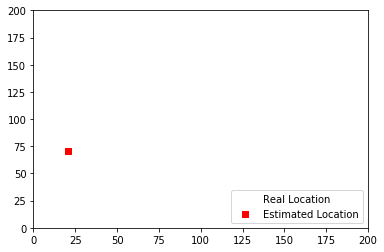

491
infered loc:
[21.         71.03246753]
real loc:
[nan nan]


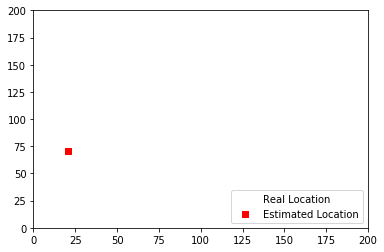

492
infered loc:
[21.         71.03246753]
real loc:
[nan nan]


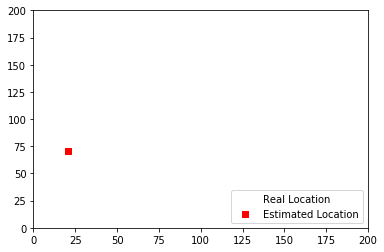

493
infered loc:
[21.         71.03246753]
real loc:
[nan nan]


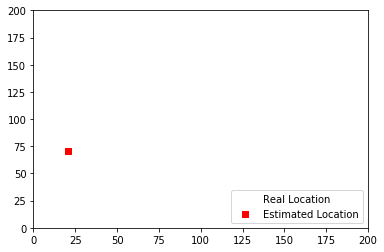

494
infered loc:
[21.         71.03246753]
real loc:
[nan nan]


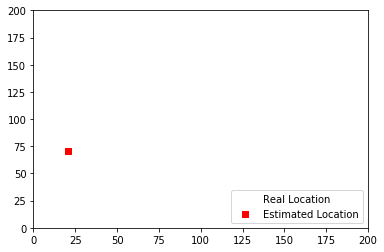

495
infered loc:
[21.         71.03246753]
real loc:
[nan nan]


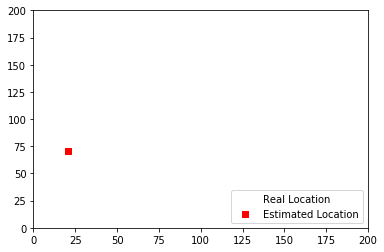

496
infered loc:
[21.         71.03246753]
real loc:
[nan nan]


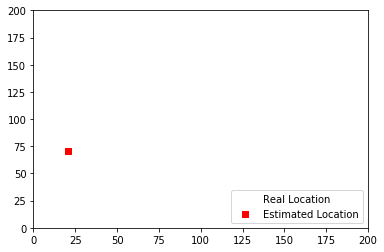

497
infered loc:
[21.         71.03246753]
real loc:
[nan nan]


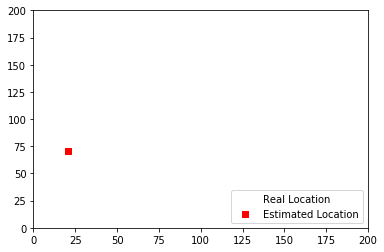

498
infered loc:
[21.         71.03246753]
real loc:
[nan nan]


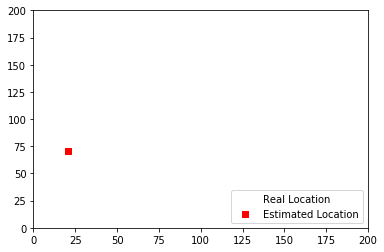

499
infered loc:
[21.         71.03246753]
real loc:
[nan nan]


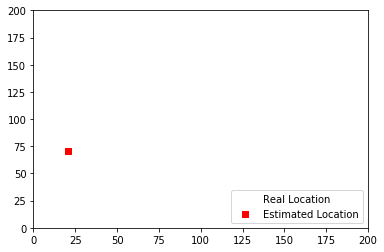

500
infered loc:
[21.         71.03246753]
real loc:
[nan nan]


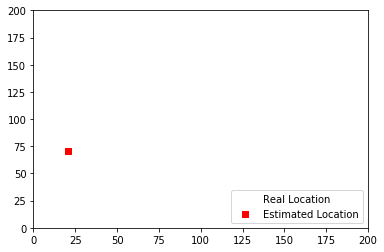

501
infered loc:
[21.         71.03246753]
real loc:
[nan nan]


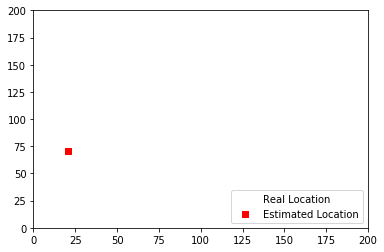

502
infered loc:
[21.         71.03246753]
real loc:
[nan nan]


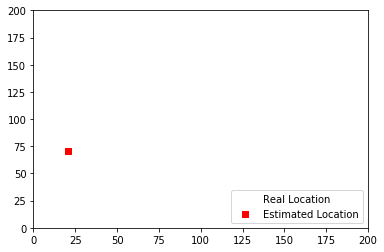

503
infered loc:
[21.         71.03246753]
real loc:
[nan nan]


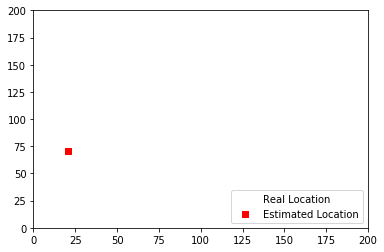

504
infered loc:
[21.         71.03246753]
real loc:
[nan nan]


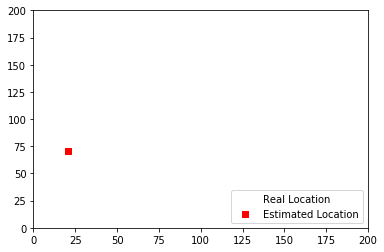

505
infered loc:
[21.         71.03246753]
real loc:
[nan nan]


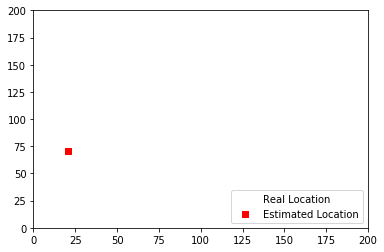

506
infered loc:
[21.         71.03246753]
real loc:
[nan nan]


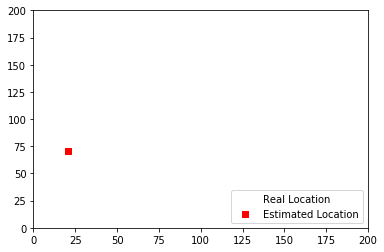

507
infered loc:
[21.         71.03246753]
real loc:
[nan nan]


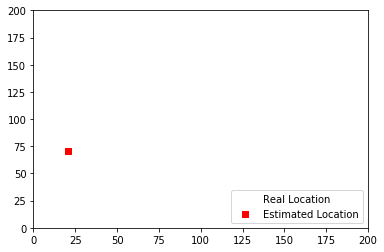

508
infered loc:
[21.         71.03246753]
real loc:
[nan nan]


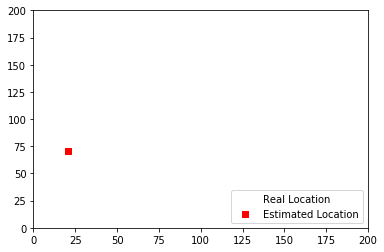

509
infered loc:
[21.         71.03246753]
real loc:
[nan nan]


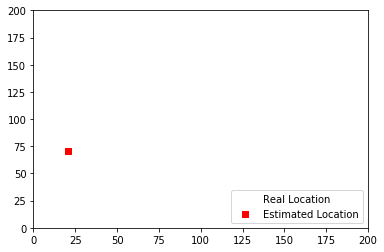

510
infered loc:
[21.         71.03246753]
real loc:
[nan nan]


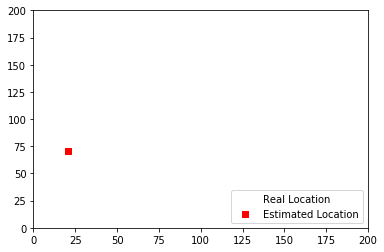

511
infered loc:
[21.         71.03246753]
real loc:
[nan nan]


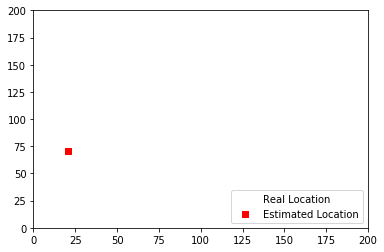

512
infered loc:
[21.         71.03246753]
real loc:
[nan nan]


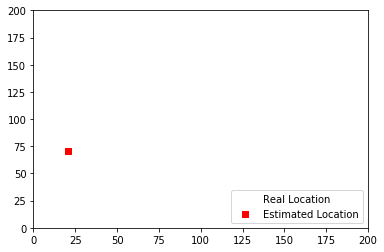

513
infered loc:
[21.         71.03246753]
real loc:
[nan nan]


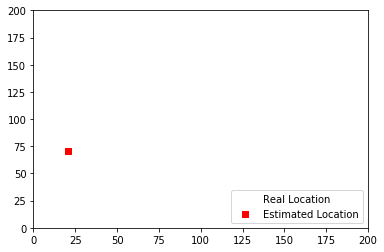

514
infered loc:
[21.         71.03246753]
real loc:
[nan nan]


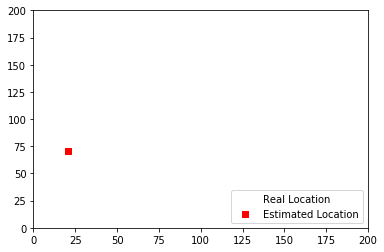

515
infered loc:
[21.         71.03246753]
real loc:
[nan nan]


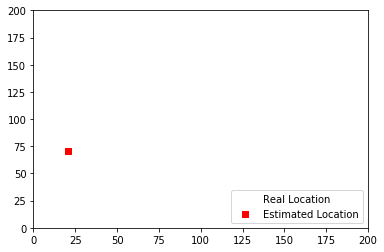

516
infered loc:
[21.         71.03246753]
real loc:
[nan nan]


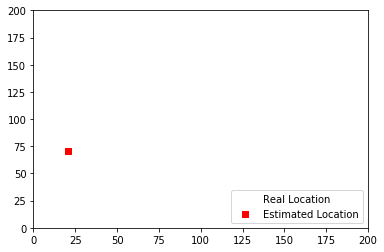

517
infered loc:
[21.         71.03246753]
real loc:
[nan nan]


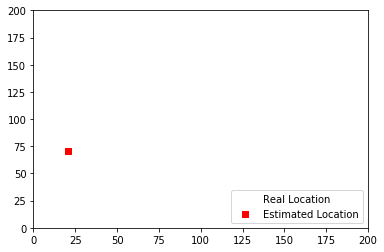

518
infered loc:
[21.         71.03246753]
real loc:
[nan nan]


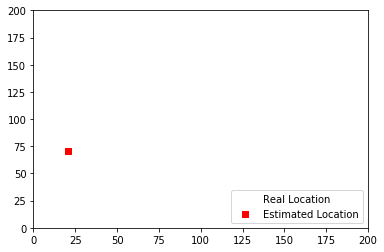

519
infered loc:
[21.         71.03246753]
real loc:
[nan nan]


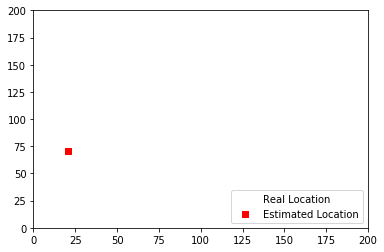

520
infered loc:
[21.         71.03246753]
real loc:
[nan nan]


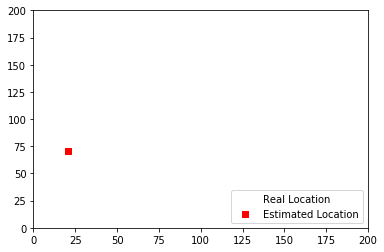

521
infered loc:
[21.         71.03246753]
real loc:
[nan nan]


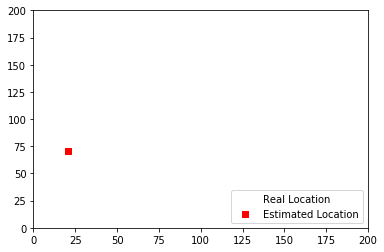

522
infered loc:
[21.         71.03246753]
real loc:
[nan nan]


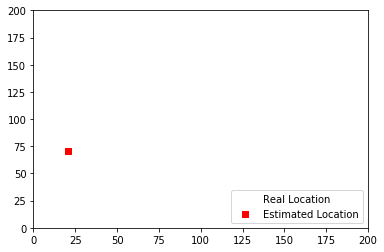

523
infered loc:
[21.         71.03246753]
real loc:
[nan nan]


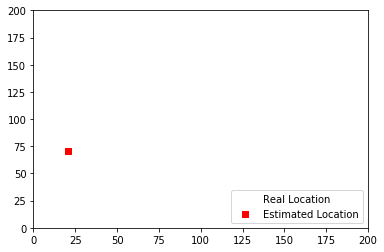

524
infered loc:
[21.         71.03246753]
real loc:
[nan nan]


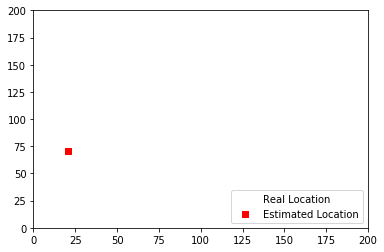

525
infered loc:
[21.         71.03246753]
real loc:
[nan nan]


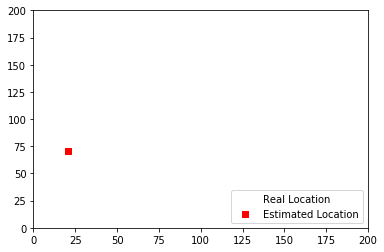

526
infered loc:
[21.         71.03246753]
real loc:
[nan nan]


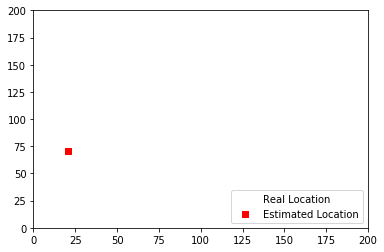

527
infered loc:
[21.         71.03246753]
real loc:
[nan nan]


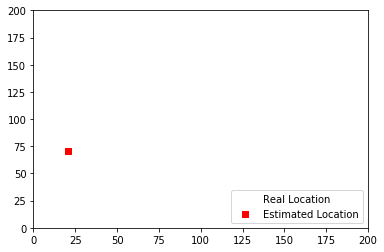

528
infered loc:
[21.         71.03246753]
real loc:
[nan nan]


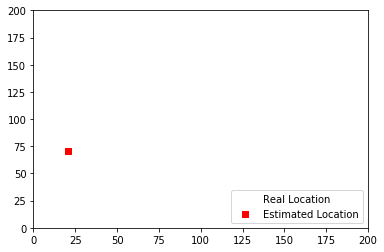

529
infered loc:
[21.         71.03246753]
real loc:
[nan nan]


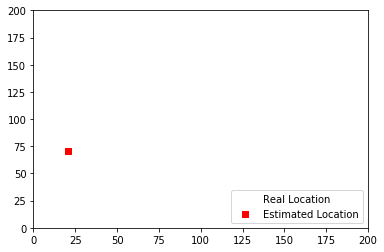

530
infered loc:
[21.         71.03246753]
real loc:
[nan nan]


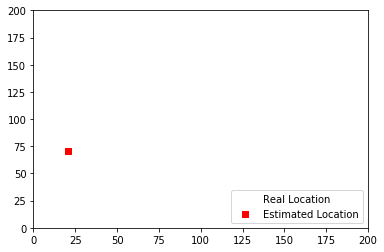

531
infered loc:
[21.         71.03246753]
real loc:
[nan nan]


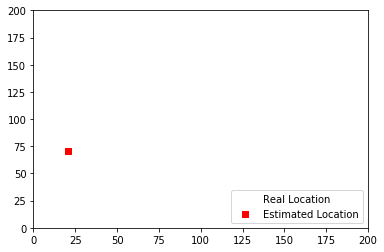

532
infered loc:
[21.         71.03246753]
real loc:
[nan nan]


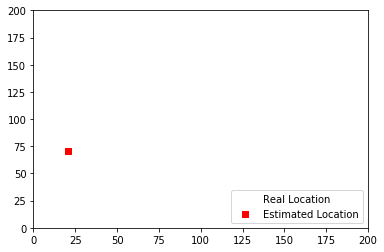

533
infered loc:
[21.         71.03246753]
real loc:
[nan nan]


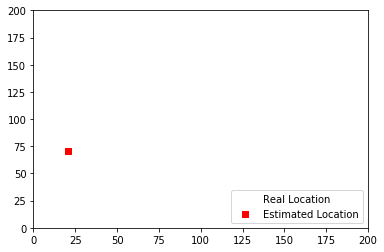

534
infered loc:
[21.         71.03246753]
real loc:
[nan nan]


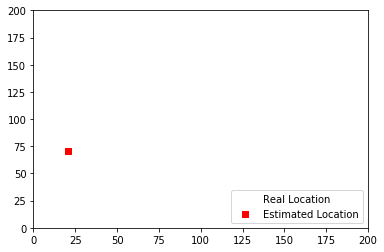

535
infered loc:
[21.         71.03246753]
real loc:
[nan nan]


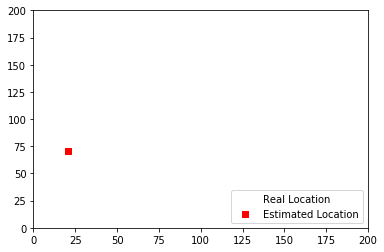

536
infered loc:
[21.         71.03246753]
real loc:
[nan nan]


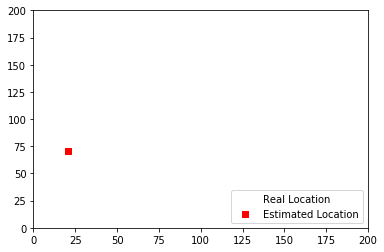

537
infered loc:
[21.         71.03246753]
real loc:
[nan nan]


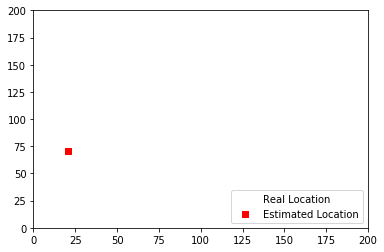

538
infered loc:
[21.         71.03246753]
real loc:
[nan nan]


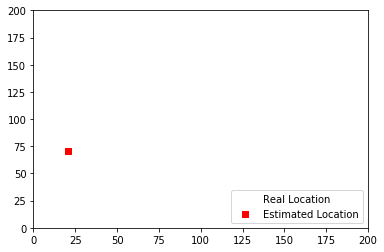

539
infered loc:
[21.         71.03246753]
real loc:
[nan nan]


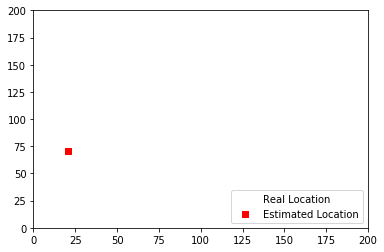

540
infered loc:
[21.         71.03246753]
real loc:
[28.4 74.1]


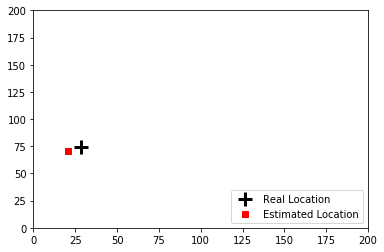

541
infered loc:
[21.         71.03246753]
real loc:
[27.3 77.2]


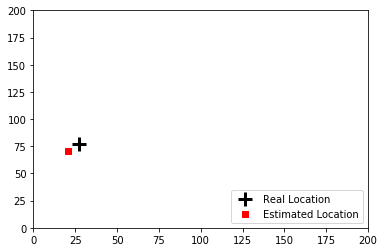

544
infered loc:
[24.         95.53146853]
real loc:
[21.8 92.7]


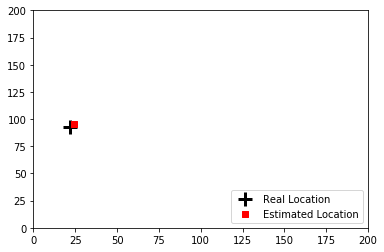

545
infered loc:
[24.         95.53146853]
real loc:
[nan nan]


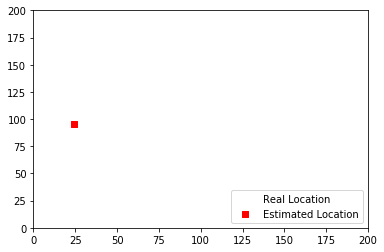

546
infered loc:
[24.         95.53146853]
real loc:
[nan nan]


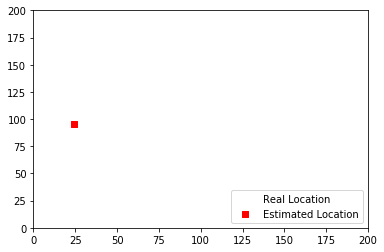

547
infered loc:
[24.         95.53146853]
real loc:
[nan nan]


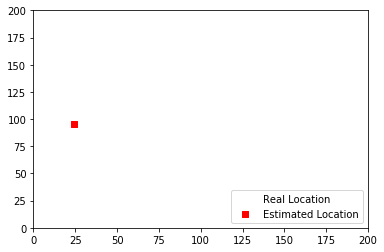

548
infered loc:
[24.         95.53146853]
real loc:
[nan nan]


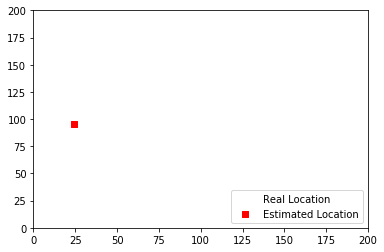

549
infered loc:
[24.         95.53146853]
real loc:
[20.7 95.8]


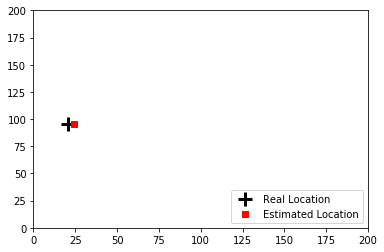

550
infered loc:
[21.         71.03246753]
real loc:
[nan nan]


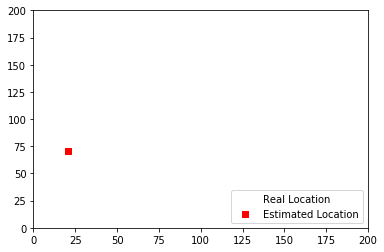

551
infered loc:
[21.         71.03246753]
real loc:
[13.16667 67.66667]


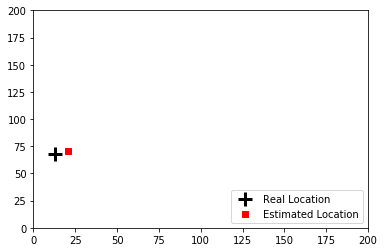

554
infered loc:
[21.         71.03246753]
real loc:
[nan nan]


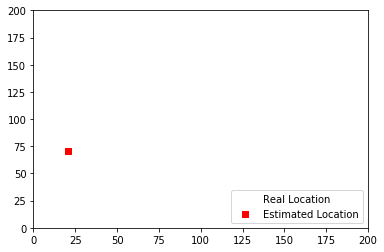

555
infered loc:
[21.         71.03246753]
real loc:
[nan nan]


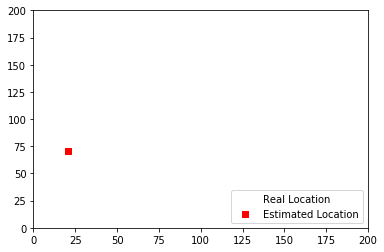

556
infered loc:
[21.         71.03246753]
real loc:
[nan nan]


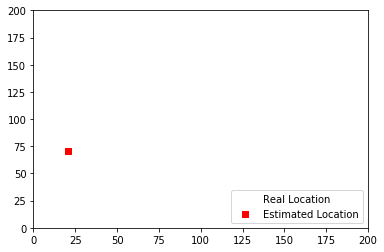

557
infered loc:
[21.         71.03246753]
real loc:
[nan nan]


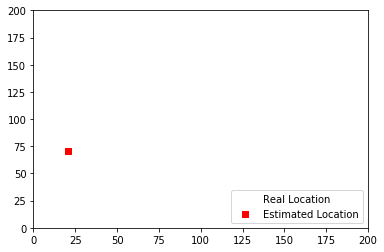

558
infered loc:
[21.         71.03246753]
real loc:
[nan nan]


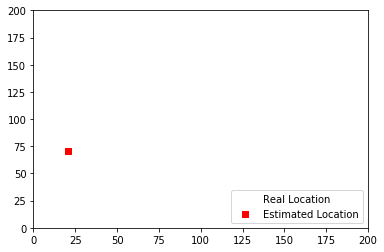

559
infered loc:
[21.         71.03246753]
real loc:
[nan nan]


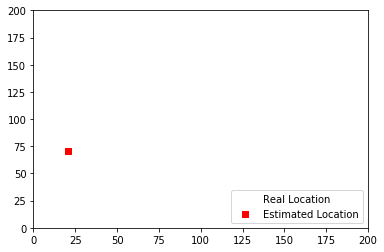

560
infered loc:
[21.         71.03246753]
real loc:
[nan nan]


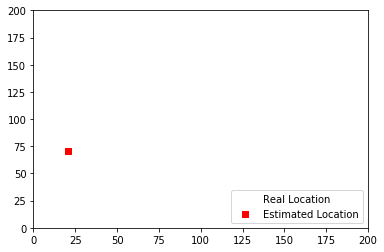

561
infered loc:
[21.         71.03246753]
real loc:
[nan nan]


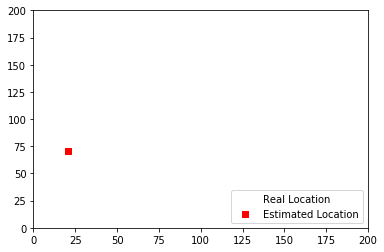

562
infered loc:
[21.         71.03246753]
real loc:
[nan nan]


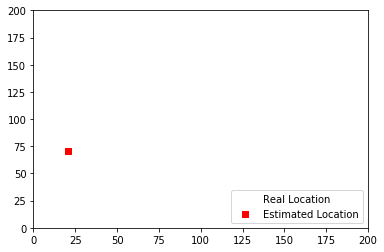

563
infered loc:
[21.         71.03246753]
real loc:
[nan nan]


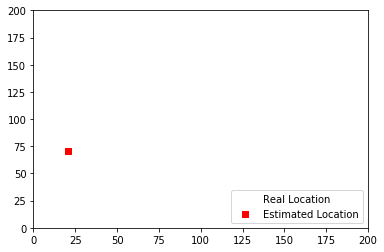

564
infered loc:
[21.         71.03246753]
real loc:
[nan nan]


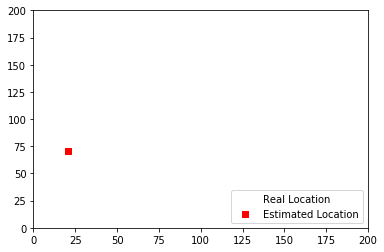

565
infered loc:
[21.         71.03246753]
real loc:
[nan nan]


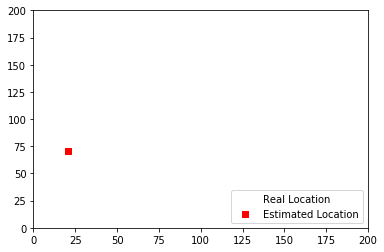

566
infered loc:
[21.         71.03246753]
real loc:
[nan nan]


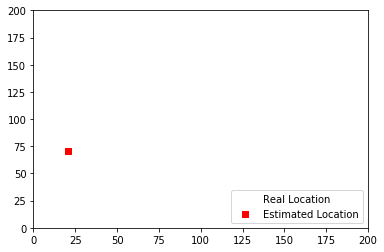

567
infered loc:
[21.         71.03246753]
real loc:
[nan nan]


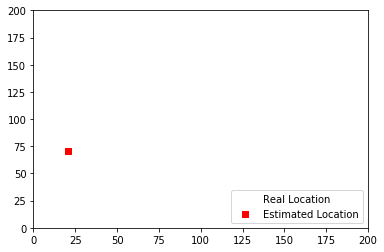

568
infered loc:
[21.         71.03246753]
real loc:
[nan nan]


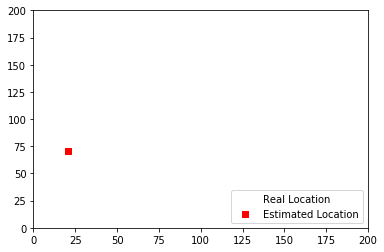

569
infered loc:
[21.         71.03246753]
real loc:
[nan nan]


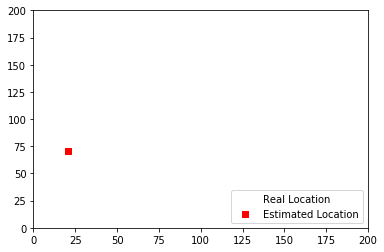

570
infered loc:
[21.         71.03246753]
real loc:
[nan nan]


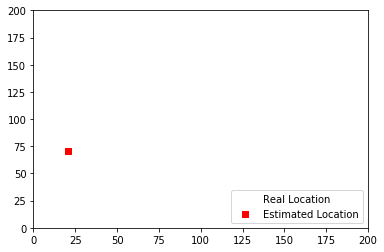

571
infered loc:
[21.         71.03246753]
real loc:
[nan nan]


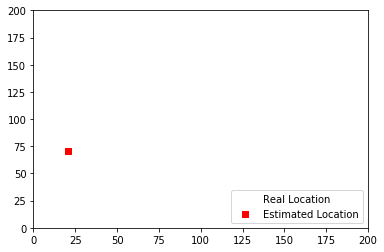

572
infered loc:
[21.         71.03246753]
real loc:
[nan nan]


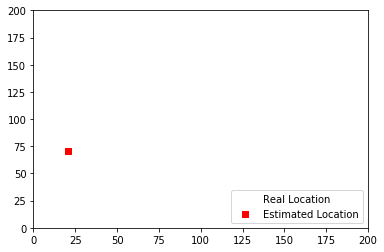

573
infered loc:
[21.         71.03246753]
real loc:
[nan nan]


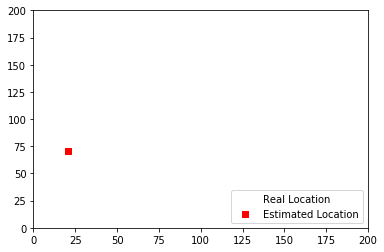

574
infered loc:
[21.         71.03246753]
real loc:
[nan nan]


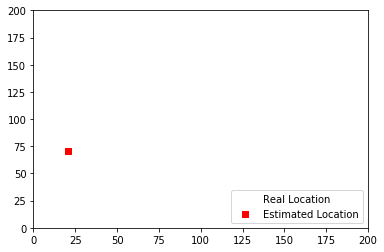

575
infered loc:
[21.         71.03246753]
real loc:
[nan nan]


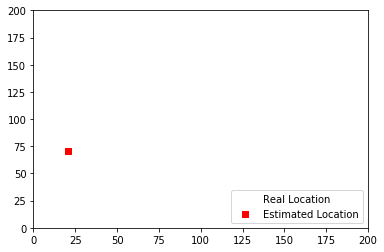

576
infered loc:
[21.         71.03246753]
real loc:
[nan nan]


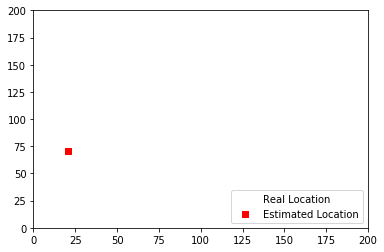

577
infered loc:
[21.         71.03246753]
real loc:
[nan nan]


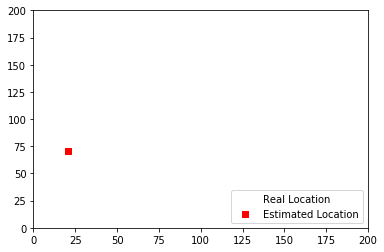

578
infered loc:
[21.         71.03246753]
real loc:
[nan nan]


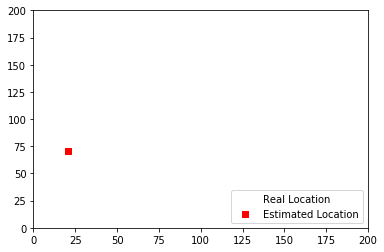

579
infered loc:
[21.         71.03246753]
real loc:
[nan nan]


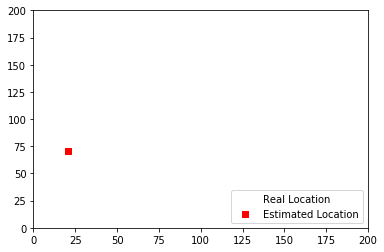

580
infered loc:
[21.         71.03246753]
real loc:
[nan nan]


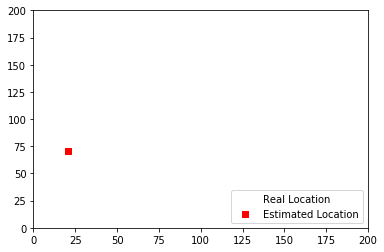

581
infered loc:
[21.         71.03246753]
real loc:
[nan nan]


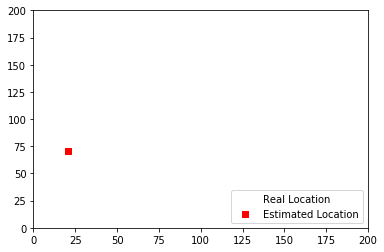

582
infered loc:
[21.         71.03246753]
real loc:
[nan nan]


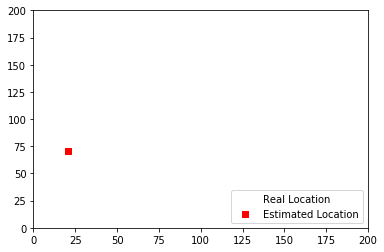

583
infered loc:
[21.         71.03246753]
real loc:
[nan nan]


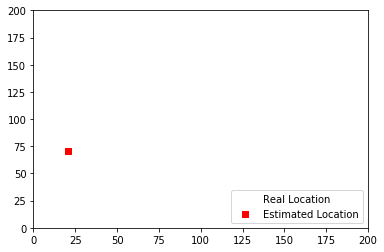

584
infered loc:
[21.         71.03246753]
real loc:
[nan nan]


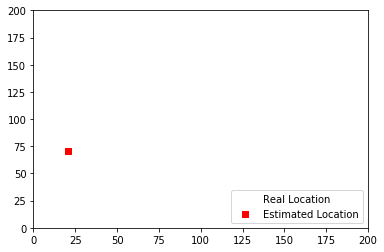

585
infered loc:
[21.         71.03246753]
real loc:
[nan nan]


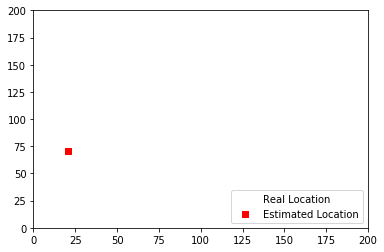

586
infered loc:
[21.         71.03246753]
real loc:
[nan nan]


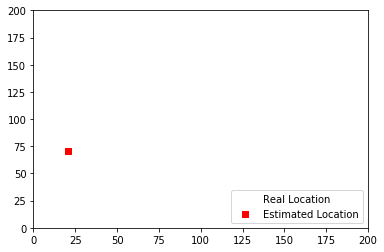

587
infered loc:
[21.         71.03246753]
real loc:
[nan nan]


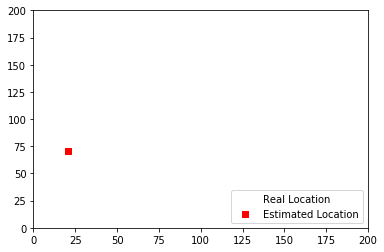

588
infered loc:
[21.         71.03246753]
real loc:
[nan nan]


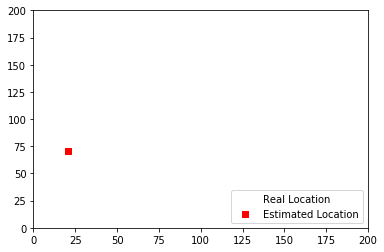

589
infered loc:
[21.         71.03246753]
real loc:
[nan nan]


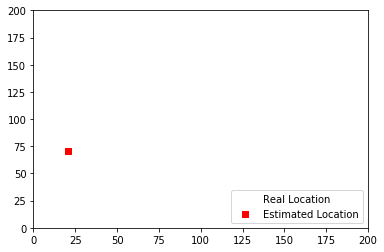

590
infered loc:
[21.         71.03246753]
real loc:
[nan nan]


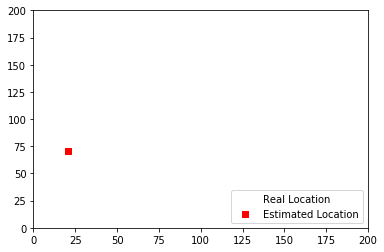

591
infered loc:
[21.         71.03246753]
real loc:
[nan nan]


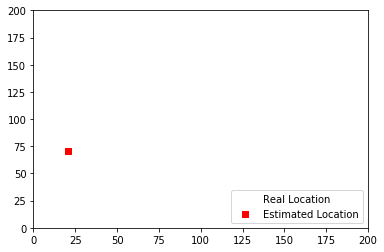

592
infered loc:
[21.         71.03246753]
real loc:
[nan nan]


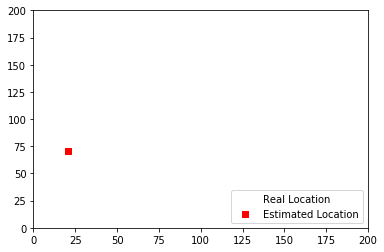

593
infered loc:
[21.         71.03246753]
real loc:
[nan nan]


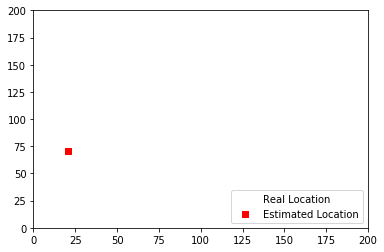

594
infered loc:
[21.         71.03246753]
real loc:
[nan nan]


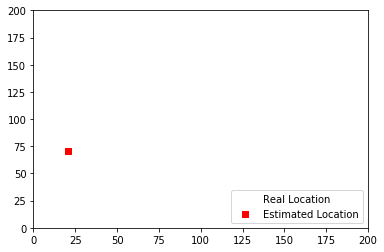

595
infered loc:
[21.         71.03246753]
real loc:
[nan nan]


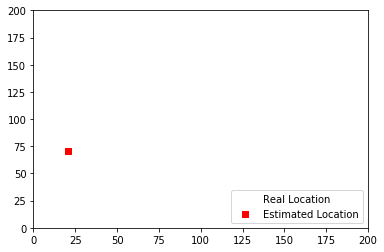

596
infered loc:
[21.         71.03246753]
real loc:
[nan nan]


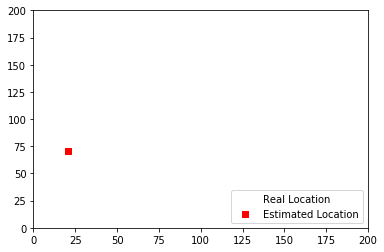

597
infered loc:
[21.         71.03246753]
real loc:
[nan nan]


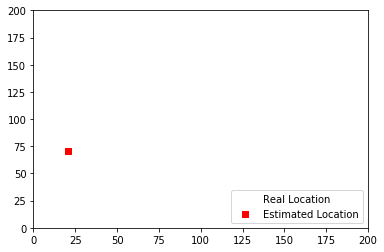

598
infered loc:
[21.         71.03246753]
real loc:
[nan nan]


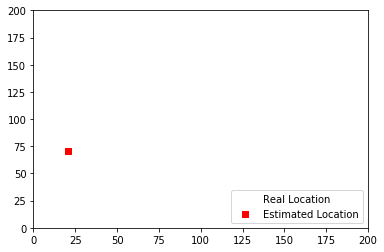

599
infered loc:
[21.         71.03246753]
real loc:
[nan nan]


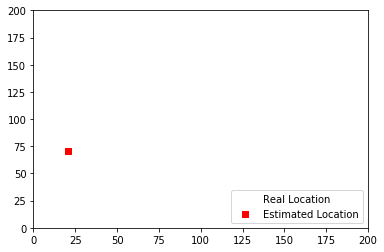

600
infered loc:
[21.         71.03246753]
real loc:
[nan nan]


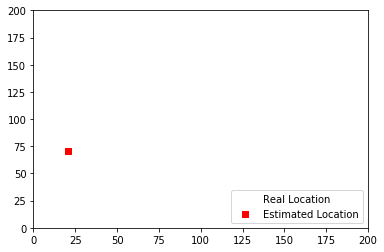

601
infered loc:
[21.         71.03246753]
real loc:
[nan nan]


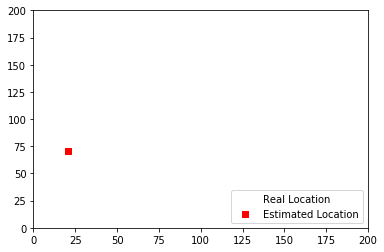

602
infered loc:
[21.         71.03246753]
real loc:
[nan nan]


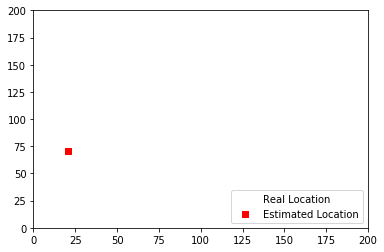

603
infered loc:
[21.         71.03246753]
real loc:
[nan nan]


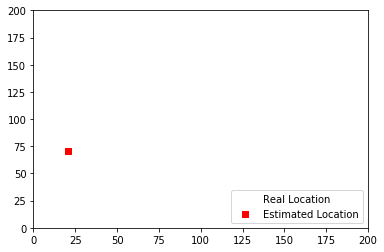

604
infered loc:
[21.         71.03246753]
real loc:
[nan nan]


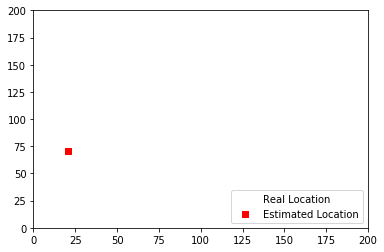

605
infered loc:
[21.         71.03246753]
real loc:
[nan nan]


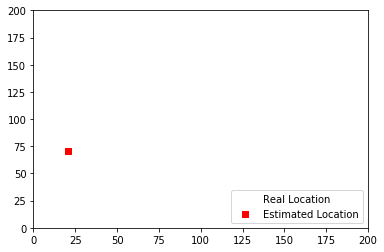

606
infered loc:
[21.         71.03246753]
real loc:
[nan nan]


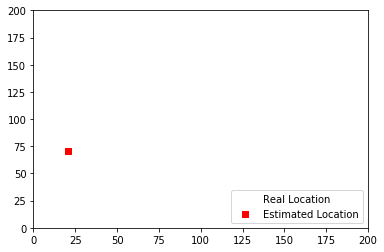

607
infered loc:
[21.         71.03246753]
real loc:
[nan nan]


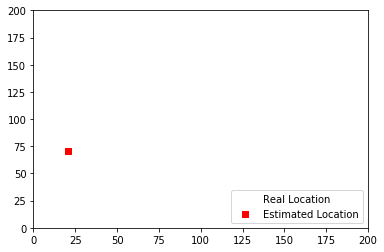

608
infered loc:
[21.         71.03246753]
real loc:
[nan nan]


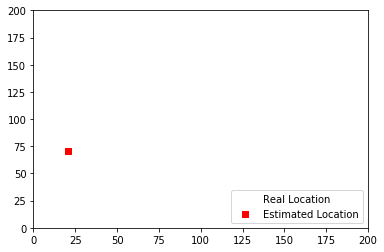

609
infered loc:
[21.         71.03246753]
real loc:
[nan nan]


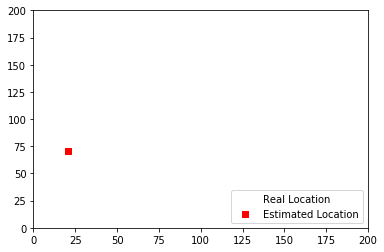

610
infered loc:
[21.         71.03246753]
real loc:
[nan nan]


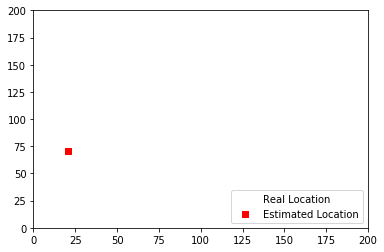

611
infered loc:
[21.         71.03246753]
real loc:
[nan nan]


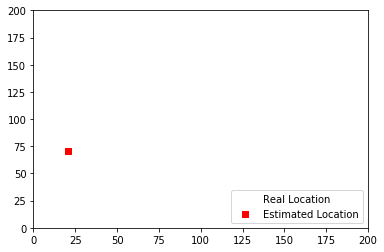

612
infered loc:
[21.         71.03246753]
real loc:
[nan nan]


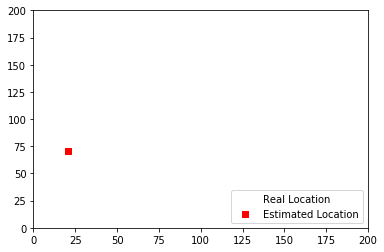

613
infered loc:
[21.         71.03246753]
real loc:
[nan nan]


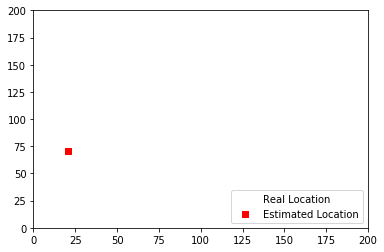

614
infered loc:
[21.         71.03246753]
real loc:
[nan nan]


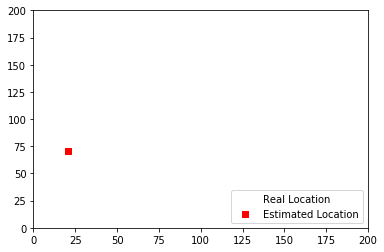

615
infered loc:
[21.         71.03246753]
real loc:
[nan nan]


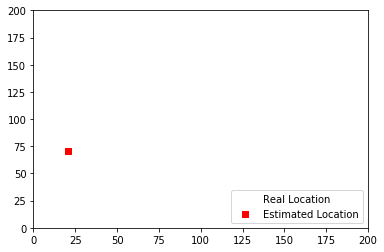

616
infered loc:
[21.         71.03246753]
real loc:
[nan nan]


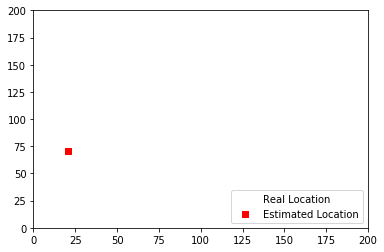

617
infered loc:
[21.         71.03246753]
real loc:
[nan nan]


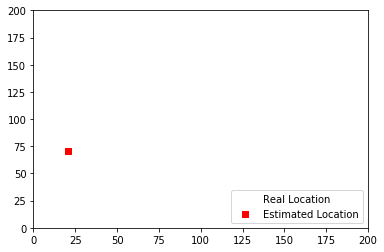

618
infered loc:
[21.         71.03246753]
real loc:
[nan nan]


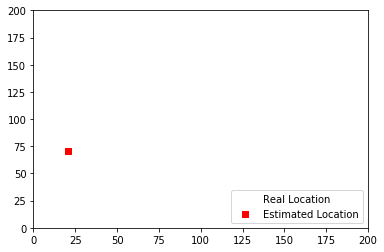

619
infered loc:
[21.         71.03246753]
real loc:
[nan nan]


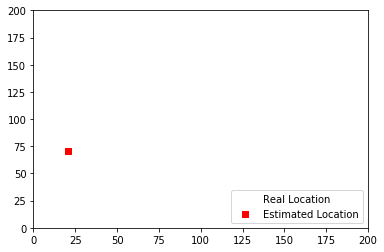

620
infered loc:
[21.         71.03246753]
real loc:
[nan nan]


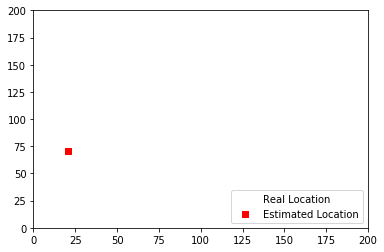

621
infered loc:
[21.         71.03246753]
real loc:
[nan nan]


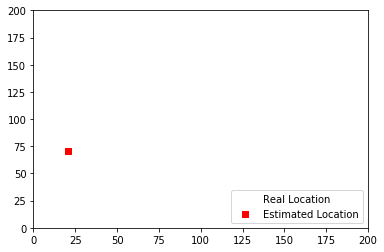

622
infered loc:
[21.         71.03246753]
real loc:
[nan nan]


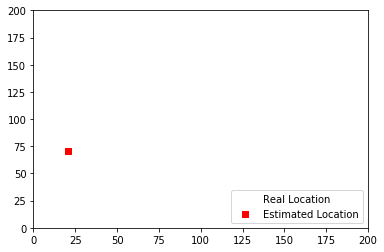

623
infered loc:
[21.         71.03246753]
real loc:
[nan nan]


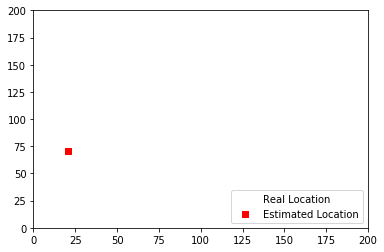

624
infered loc:
[21.         71.03246753]
real loc:
[nan nan]


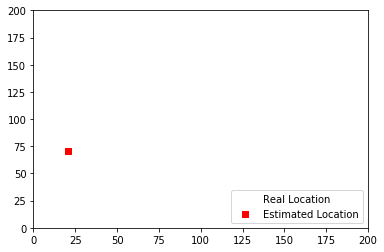

625
infered loc:
[21.         71.03246753]
real loc:
[nan nan]


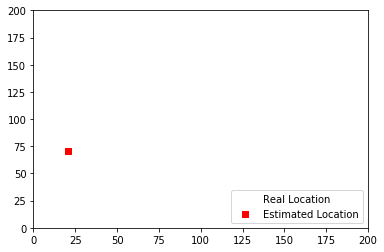

626
infered loc:
[21.         71.03246753]
real loc:
[nan nan]


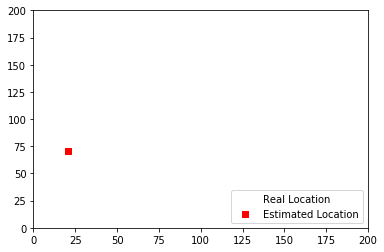

627
infered loc:
[21.         71.03246753]
real loc:
[nan nan]


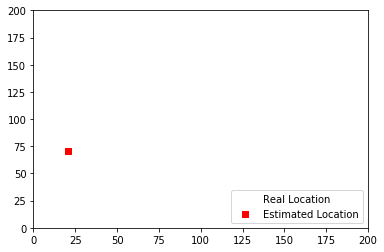

628
infered loc:
[21.         71.03246753]
real loc:
[21.33333 69.33333]


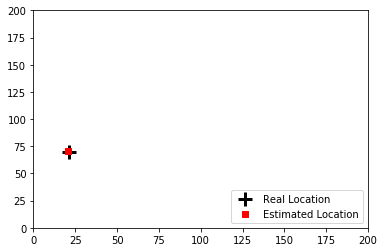

633
infered loc:
[24.         95.53146853]
real loc:
[21.  94.8]


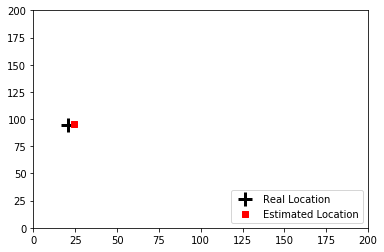

636
infered loc:
[18. 93.]
real loc:
[13.16667 79.66667]


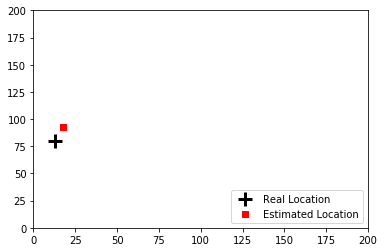

637
infered loc:
[16.5 78.5]
real loc:
[nan nan]


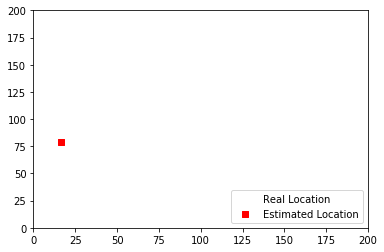

638
infered loc:
[16.5 78.5]
real loc:
[nan nan]


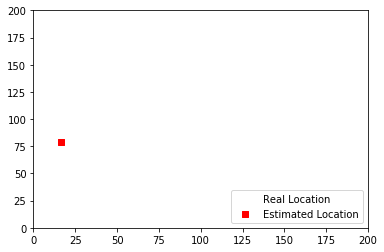

639
infered loc:
[16.5 78.5]
real loc:
[28.75    76.16667]


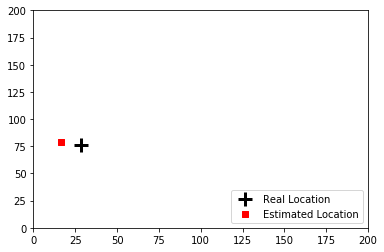

642
infered loc:
[16.5 78.5]
real loc:
[nan nan]


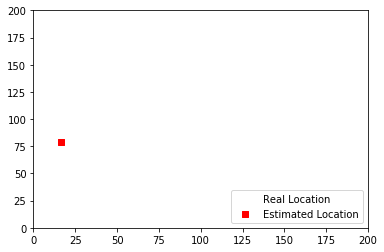

643
infered loc:
[16.5 78.5]
real loc:
[nan nan]


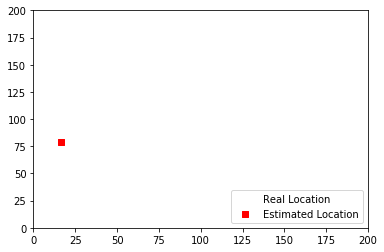

644
infered loc:
[16.5 78.5]
real loc:
[nan nan]


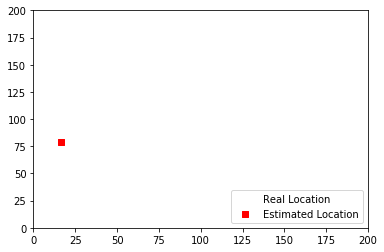

645
infered loc:
[16.5 78.5]
real loc:
[nan nan]


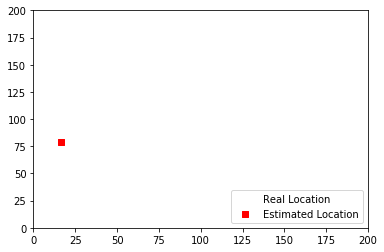

646
infered loc:
[16.5 78.5]
real loc:
[nan nan]


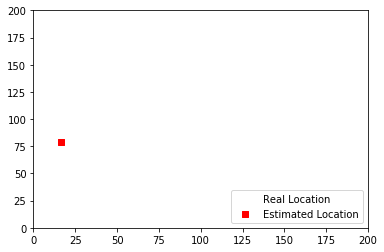

647
infered loc:
[16.5 78.5]
real loc:
[nan nan]


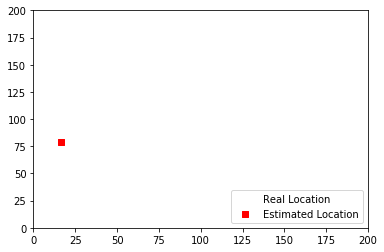

648
infered loc:
[16.5 78.5]
real loc:
[nan nan]


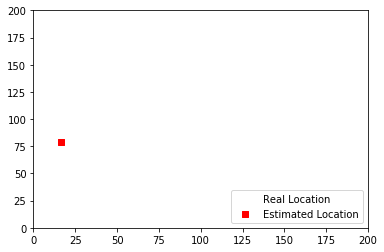

649
infered loc:
[16.5 78.5]
real loc:
[nan nan]


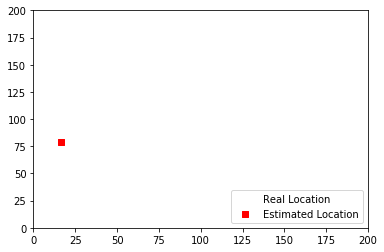

650
infered loc:
[16.5 78.5]
real loc:
[nan nan]


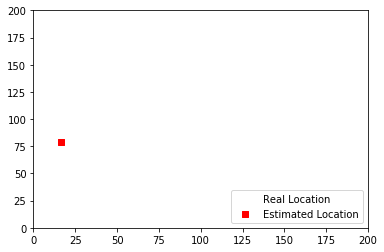

651
infered loc:
[16.5 78.5]
real loc:
[nan nan]


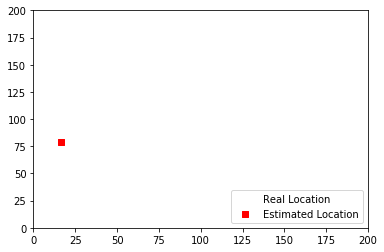

652
infered loc:
[16.5 78.5]
real loc:
[nan nan]


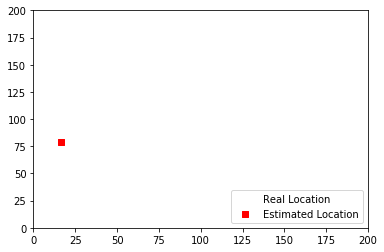

654
infered loc:
[24.         95.53146853]
real loc:
[nan nan]


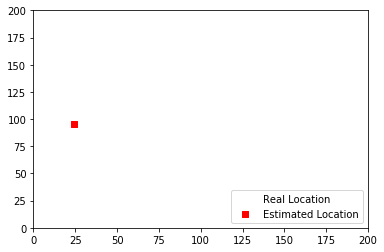

656
infered loc:
[21.         71.03246753]
real loc:
[nan nan]


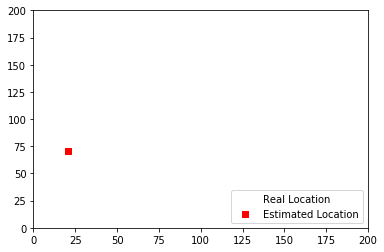

657
infered loc:
[21.         71.03246753]
real loc:
[nan nan]


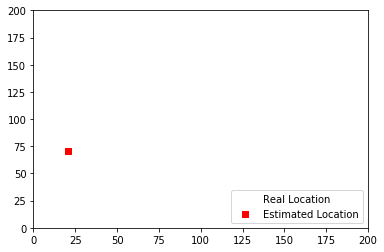

658
infered loc:
[21.         71.03246753]
real loc:
[nan nan]


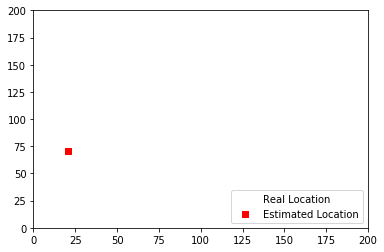

659
infered loc:
[21.         71.03246753]
real loc:
[nan nan]


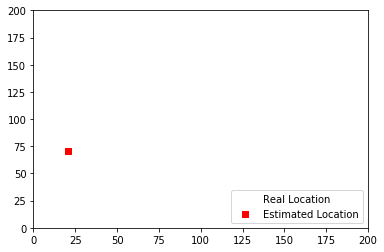

660
infered loc:
[21.         71.03246753]
real loc:
[nan nan]


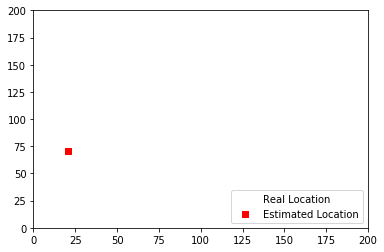

661
infered loc:
[21.         71.03246753]
real loc:
[nan nan]


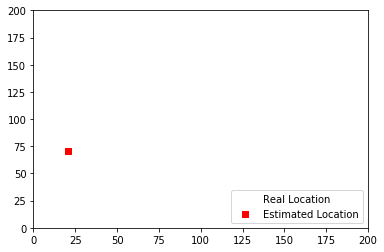

662
infered loc:
[21.         71.03246753]
real loc:
[nan nan]


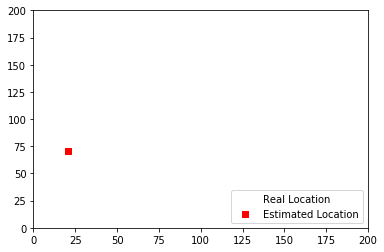

663
infered loc:
[21.         71.03246753]
real loc:
[nan nan]


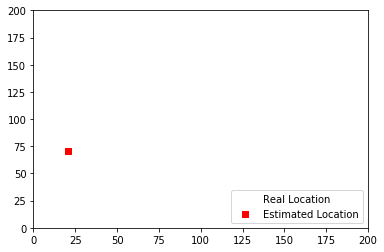

664
infered loc:
[21.         71.03246753]
real loc:
[nan nan]


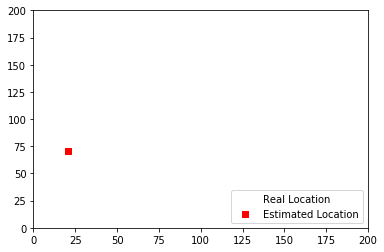

665
infered loc:
[21.         71.03246753]
real loc:
[nan nan]


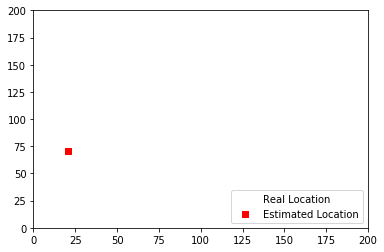

666
infered loc:
[21.         71.03246753]
real loc:
[nan nan]


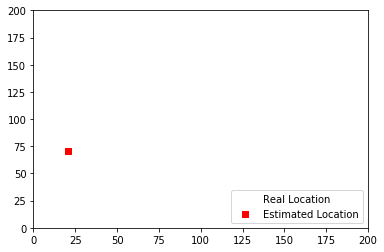

667
infered loc:
[21.         71.03246753]
real loc:
[nan nan]


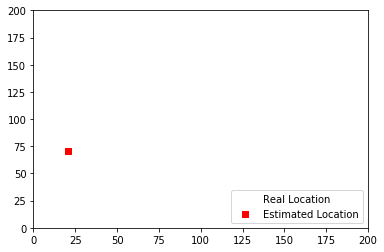

668
infered loc:
[21.         71.03246753]
real loc:
[nan nan]


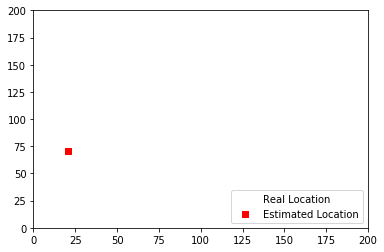

669
infered loc:
[21.         71.03246753]
real loc:
[nan nan]


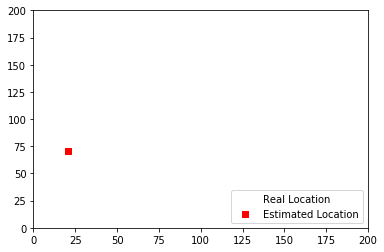

670
infered loc:
[21.         71.03246753]
real loc:
[nan nan]


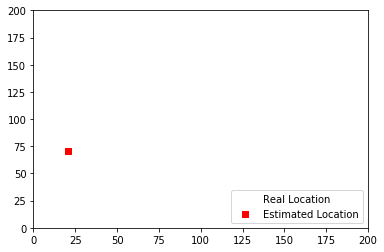

671
infered loc:
[21.         71.03246753]
real loc:
[nan nan]


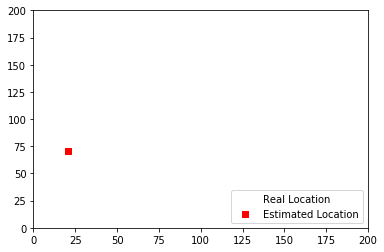

672
infered loc:
[21.         71.03246753]
real loc:
[nan nan]


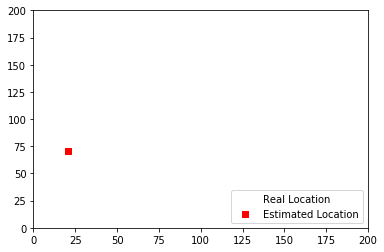

673
infered loc:
[21.         71.03246753]
real loc:
[nan nan]


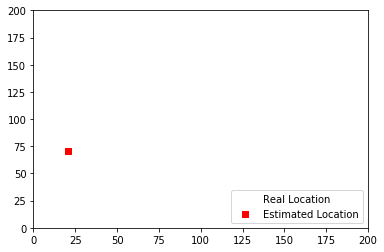

674
infered loc:
[21.         71.03246753]
real loc:
[nan nan]


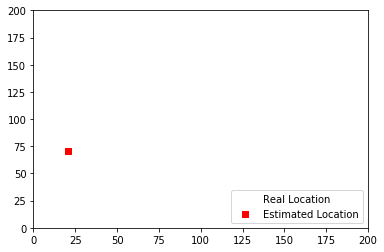

675
infered loc:
[21.         71.03246753]
real loc:
[nan nan]


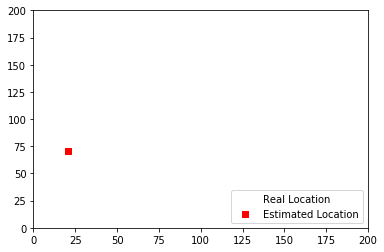

676
infered loc:
[21.         71.03246753]
real loc:
[nan nan]


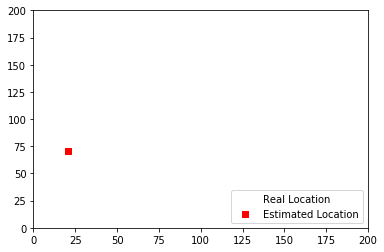

678
infered loc:
[24.         95.53146853]
real loc:
[nan nan]


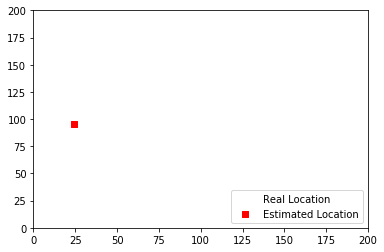

679
infered loc:
[24.         95.53146853]
real loc:
[nan nan]


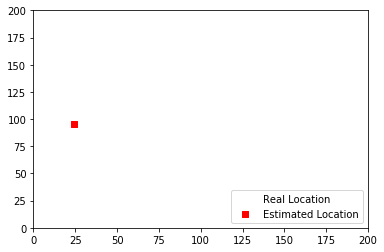

681
infered loc:
[21.         71.03246753]
real loc:
[nan nan]


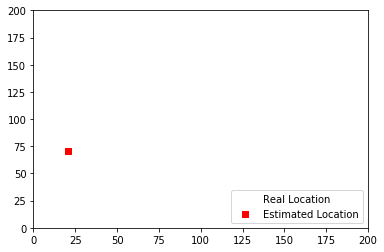

682
infered loc:
[21.         71.03246753]
real loc:
[nan nan]


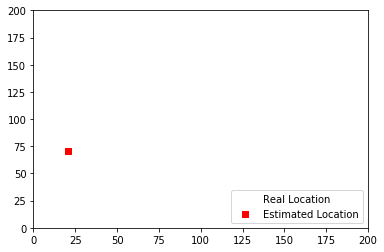

683
infered loc:
[21.         71.03246753]
real loc:
[nan nan]


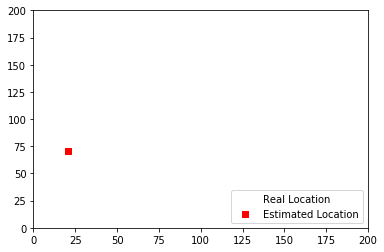

684
infered loc:
[21.         71.03246753]
real loc:
[nan nan]


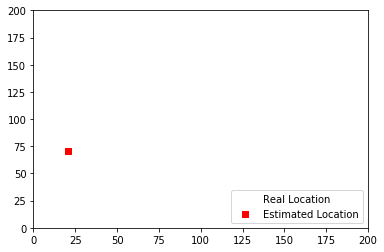

685
infered loc:
[21.         71.03246753]
real loc:
[nan nan]


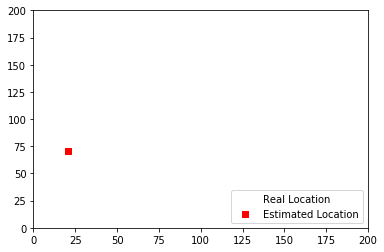

686
infered loc:
[21.         71.03246753]
real loc:
[nan nan]


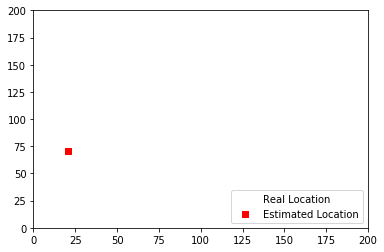

687
infered loc:
[21.         71.03246753]
real loc:
[nan nan]


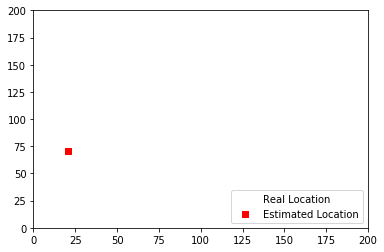

688
infered loc:
[21.         71.03246753]
real loc:
[nan nan]


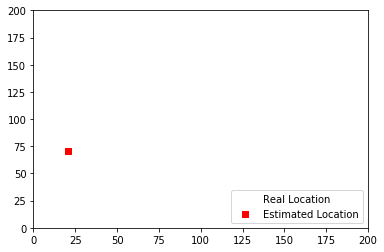

690
infered loc:
[21.         71.03246753]
real loc:
[28.6 77.2]


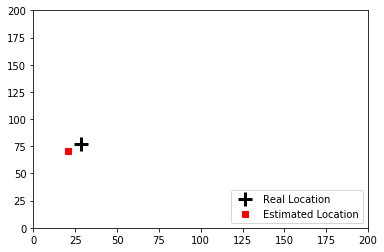

691
infered loc:
[24.         95.53146853]
real loc:
[25.9 95.8]


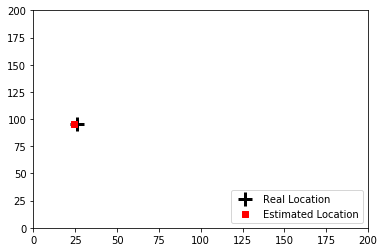

692
infered loc:
[18. 93.]
real loc:
[11.66667 78.     ]


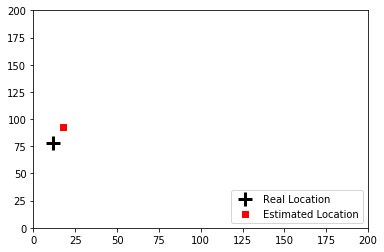

697
infered loc:
[16.5 78.5]
real loc:
[nan nan]


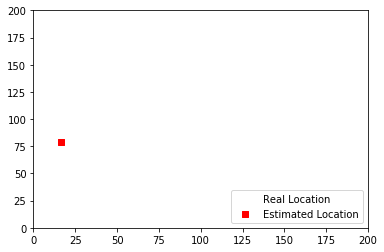

698
infered loc:
[16.5 78.5]
real loc:
[nan nan]


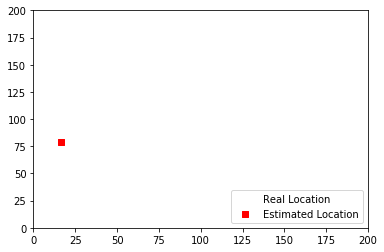

699
infered loc:
[16.5 78.5]
real loc:
[nan nan]


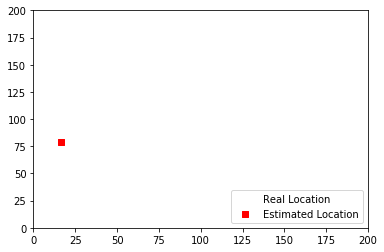

700
infered loc:
[16.5 78.5]
real loc:
[nan nan]


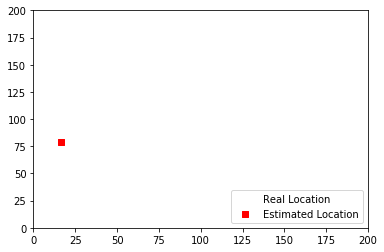

701
infered loc:
[16.5 78.5]
real loc:
[nan nan]


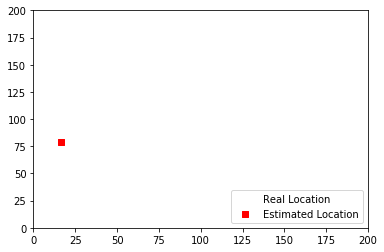

702
infered loc:
[16.5 78.5]
real loc:
[nan nan]


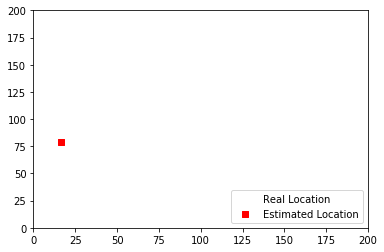

703
infered loc:
[16.5 78.5]
real loc:
[nan nan]


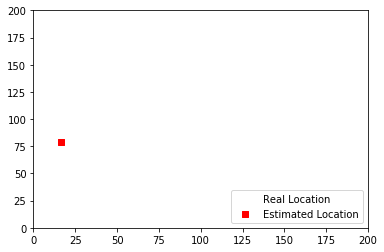

704
infered loc:
[16.5 78.5]
real loc:
[nan nan]


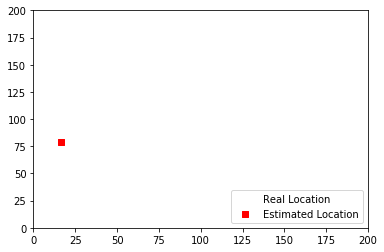

705
infered loc:
[16.5 78.5]
real loc:
[nan nan]


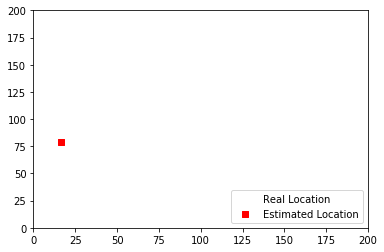

706
infered loc:
[16.5 78.5]
real loc:
[nan nan]


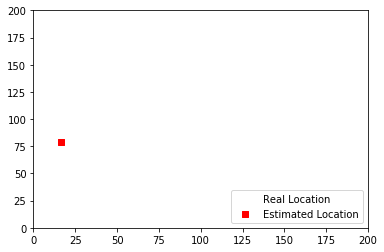

707
infered loc:
[16.5 78.5]
real loc:
[nan nan]


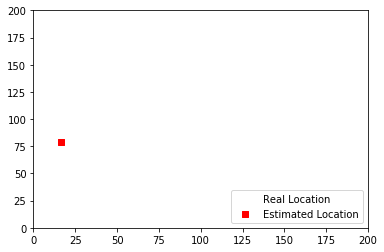

708
infered loc:
[16.5 78.5]
real loc:
[17.25 68.5 ]


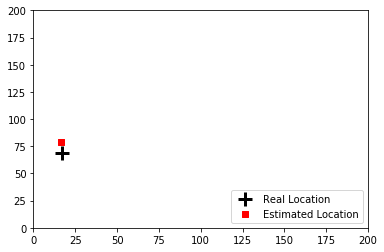

718
infered loc:
[16.5 78.5]
real loc:
[16.08333 68.2619 ]


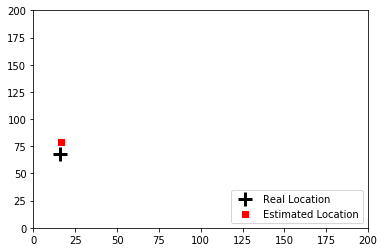

719
infered loc:
[16.5 78.5]
real loc:
[17.83333 68.61905]


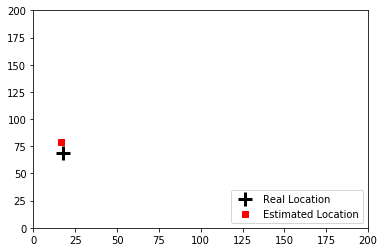

720
infered loc:
[16.5 78.5]
real loc:
[26.58333 70.40476]


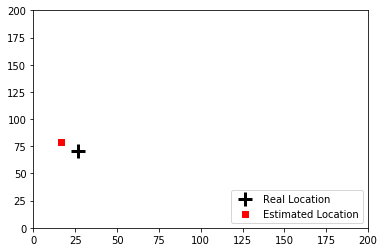

721
infered loc:
[16.5 78.5]
real loc:
[28.33333 70.7619 ]


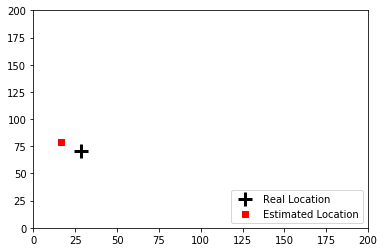

722
infered loc:
[16.5 78.5]
real loc:
[nan nan]


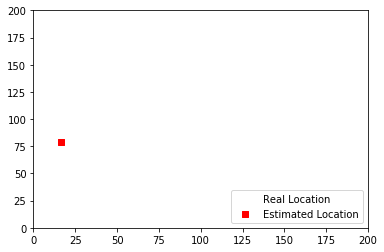

723
infered loc:
[16.5 78.5]
real loc:
[nan nan]


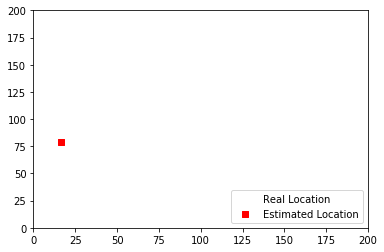

726
infered loc:
[16.5 78.5]
real loc:
[14.8 68. ]


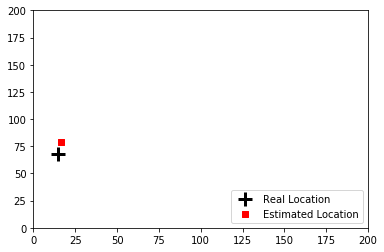

727
infered loc:
[16.5 78.5]
real loc:
[19.7 69. ]


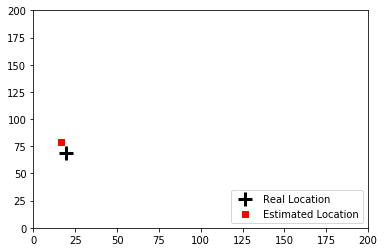

728
infered loc:
[16.5 78.5]
real loc:
[nan nan]


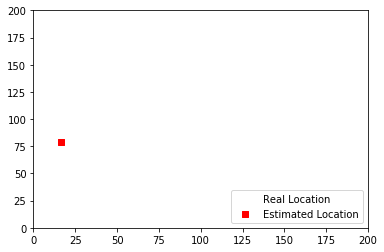

729
infered loc:
[16.5 78.5]
real loc:
[nan nan]


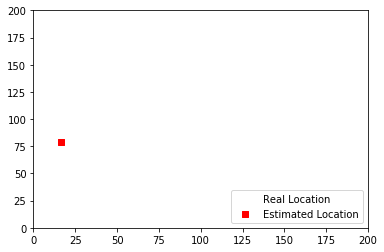

730
infered loc:
[16.5 78.5]
real loc:
[nan nan]


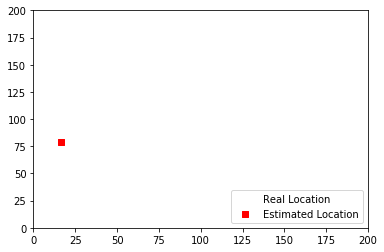

731
infered loc:
[16.5 78.5]
real loc:
[nan nan]


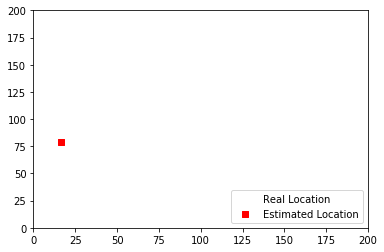

732
infered loc:
[16.5 78.5]
real loc:
[nan nan]


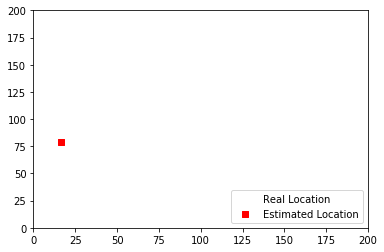

733
infered loc:
[16.5 78.5]
real loc:
[nan nan]


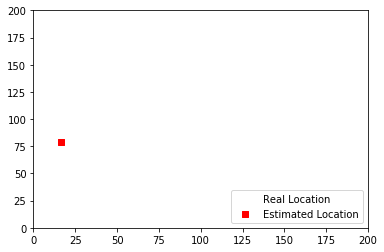

734
infered loc:
[16.5 78.5]
real loc:
[nan nan]


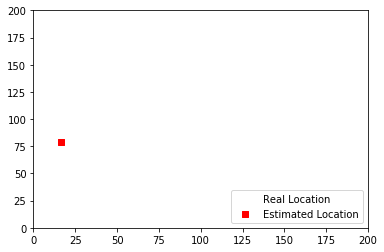

735
infered loc:
[16.5 78.5]
real loc:
[nan nan]


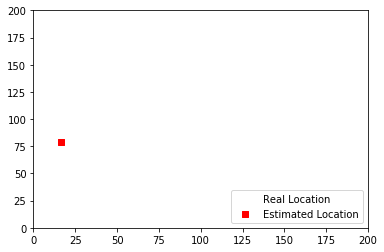

736
infered loc:
[16.5 78.5]
real loc:
[nan nan]


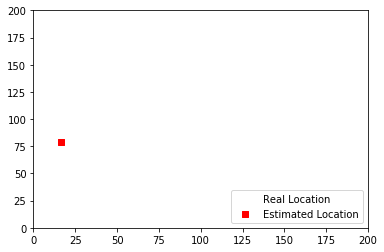

737
infered loc:
[16.5 78.5]
real loc:
[nan nan]


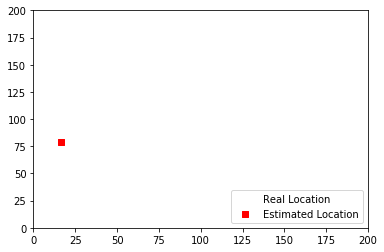

738
infered loc:
[16.5 78.5]
real loc:
[nan nan]


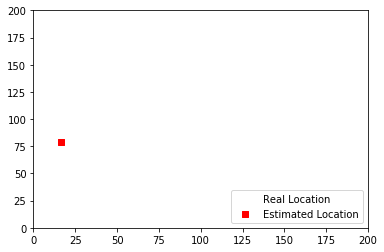

739
infered loc:
[16.5 78.5]
real loc:
[nan nan]


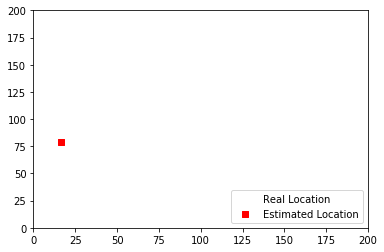

740
infered loc:
[16.5 78.5]
real loc:
[nan nan]


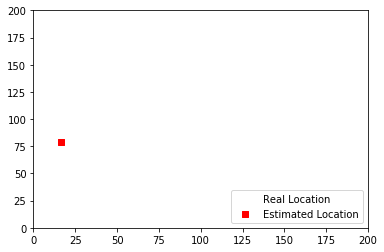

741
infered loc:
[16.5 78.5]
real loc:
[nan nan]


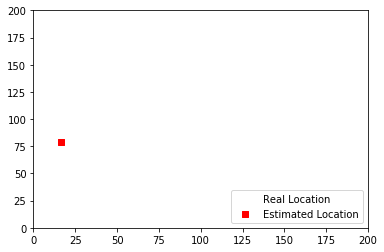

742
infered loc:
[16.5 78.5]
real loc:
[nan nan]


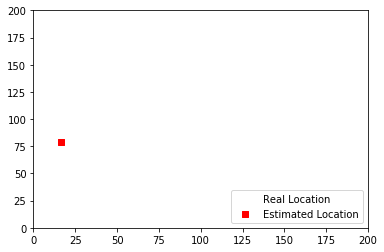

743
infered loc:
[16.5 78.5]
real loc:
[nan nan]


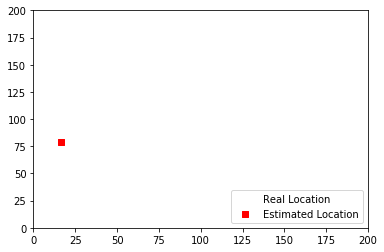

744
infered loc:
[16.5 78.5]
real loc:
[nan nan]


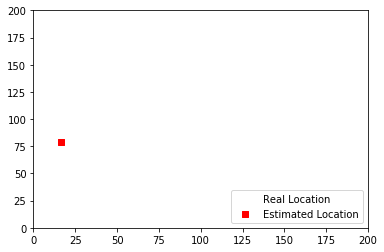

745
infered loc:
[16.5 78.5]
real loc:
[nan nan]


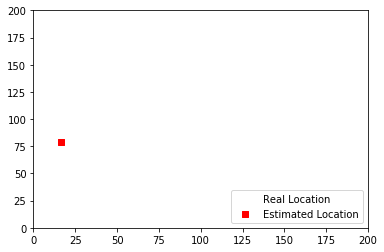

746
infered loc:
[16.5 78.5]
real loc:
[nan nan]


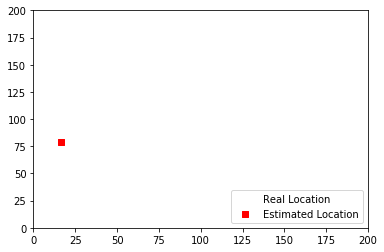

747
infered loc:
[16.5 78.5]
real loc:
[nan nan]


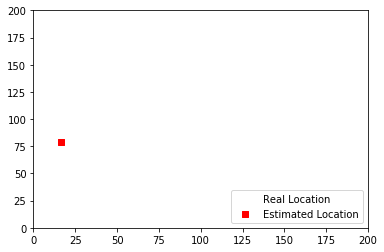

748
infered loc:
[16.5 78.5]
real loc:
[nan nan]


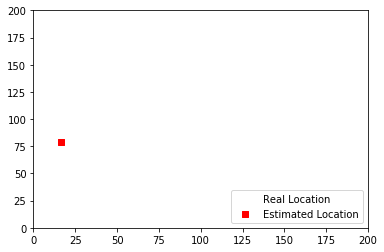

749
infered loc:
[16.5 78.5]
real loc:
[nan nan]


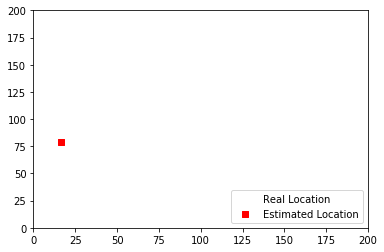

750
infered loc:
[16.5 78.5]
real loc:
[nan nan]


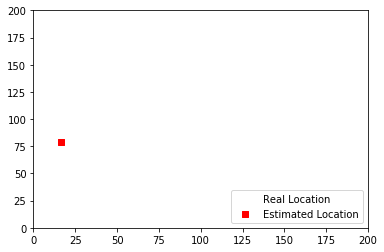

751
infered loc:
[16.5 78.5]
real loc:
[nan nan]


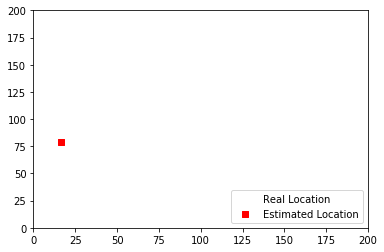

752
infered loc:
[16.5 78.5]
real loc:
[nan nan]


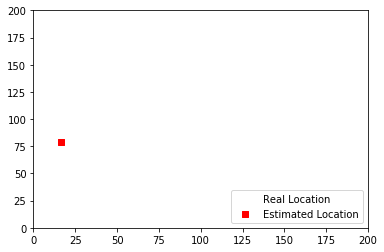

753
infered loc:
[16.5 78.5]
real loc:
[nan nan]


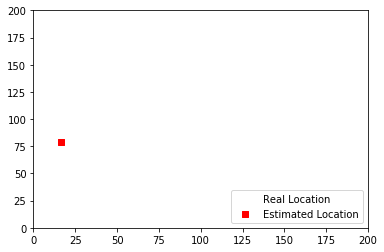

754
infered loc:
[16.5 78.5]
real loc:
[nan nan]


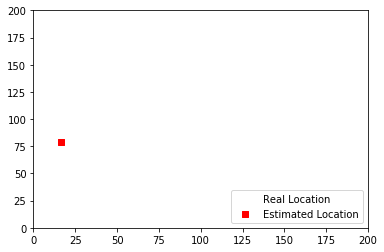

755
infered loc:
[16.5 78.5]
real loc:
[nan nan]


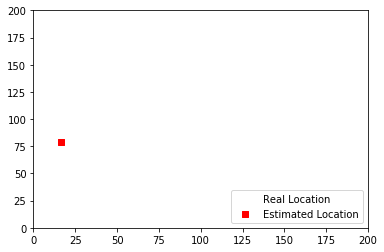

756
infered loc:
[16.5 78.5]
real loc:
[nan nan]


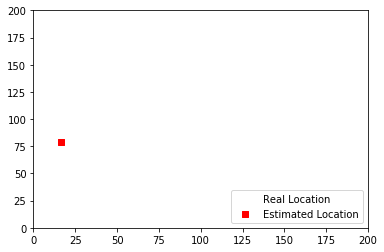

757
infered loc:
[16.5 78.5]
real loc:
[nan nan]


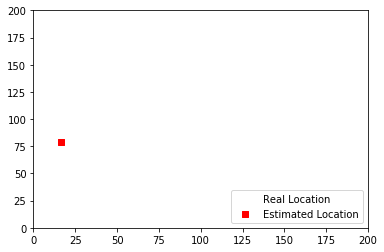

758
infered loc:
[16.5 78.5]
real loc:
[nan nan]


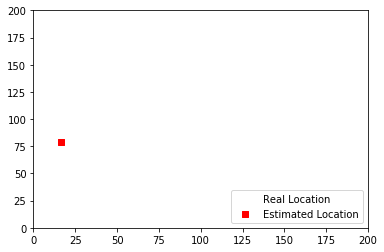

759
infered loc:
[16.5 78.5]
real loc:
[nan nan]


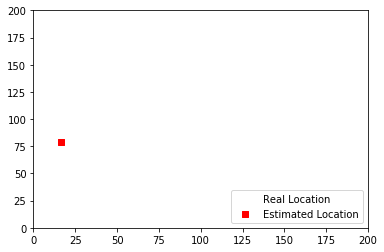

760
infered loc:
[16.5 78.5]
real loc:
[nan nan]


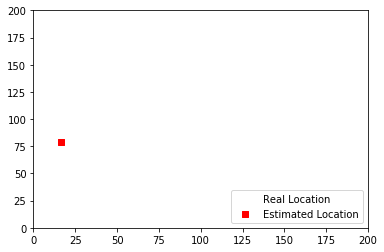

761
infered loc:
[16.5 78.5]
real loc:
[nan nan]


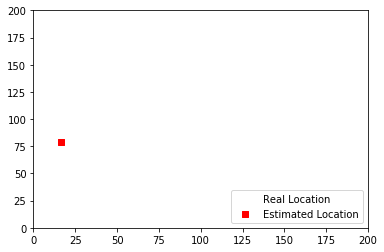

762
infered loc:
[16.5 78.5]
real loc:
[nan nan]


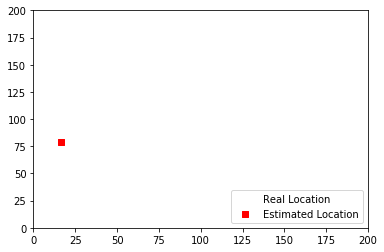

763
infered loc:
[16.5 78.5]
real loc:
[nan nan]


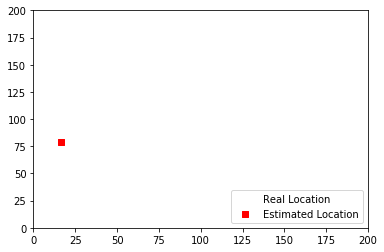

764
infered loc:
[16.5 78.5]
real loc:
[nan nan]


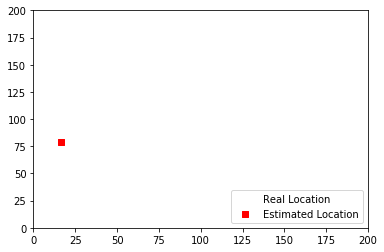

765
infered loc:
[16.5 78.5]
real loc:
[nan nan]


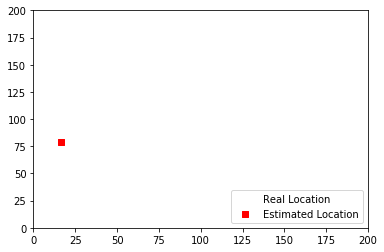

766
infered loc:
[16.5 78.5]
real loc:
[nan nan]


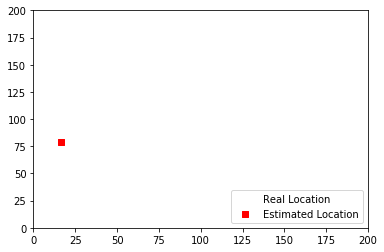

767
infered loc:
[24.         95.53146853]
real loc:
[ 18.98148 102.     ]


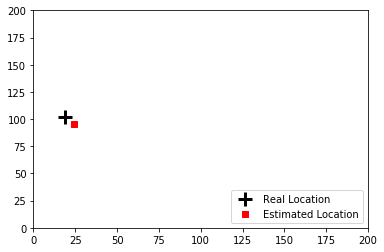

768
infered loc:
[24.         95.53146853]
real loc:
[ 20.42593 102.     ]


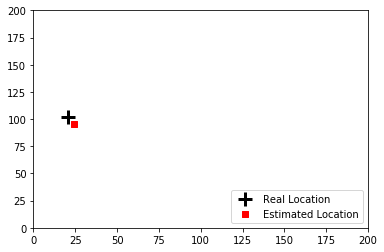

769
infered loc:
[24.         95.53146853]
real loc:
[ 21.14815 102.     ]


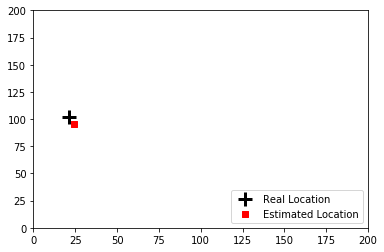

770
infered loc:
[24.         95.53146853]
real loc:
[ 21.87037 102.     ]


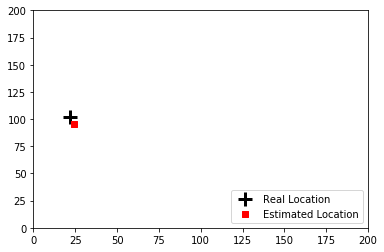

771
infered loc:
[24.         95.53146853]
real loc:
[ 22.59259 102.     ]


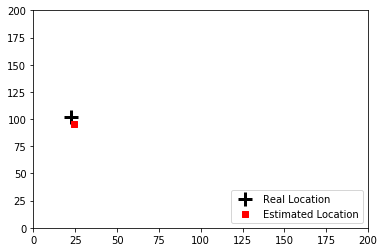

772
infered loc:
[24.         95.53146853]
real loc:
[ 23.31481 102.     ]


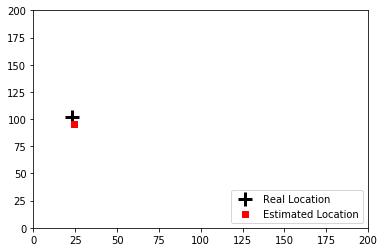

773
infered loc:
[24.         95.53146853]
real loc:
[ 24.03704 102.     ]


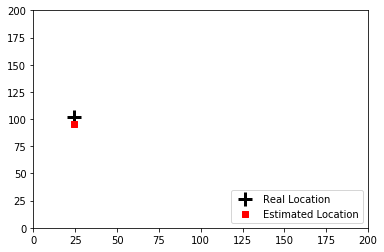

774
infered loc:
[18. 93.]
real loc:
[19.625 90.   ]


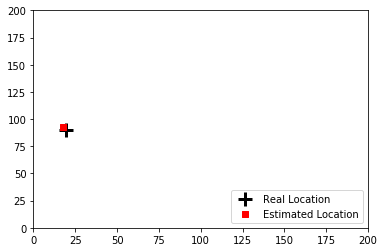

775
infered loc:
[19.47058824 64.05882353]
real loc:
[23. 54.]


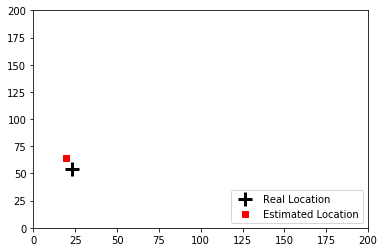

776
infered loc:
[18.         57.03246753]
real loc:
[nan nan]


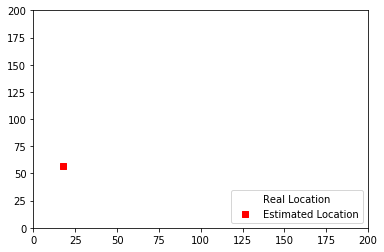

777
infered loc:
[18.         57.03246753]
real loc:
[nan nan]


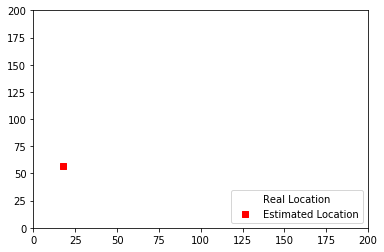

778
infered loc:
[18.         57.03246753]
real loc:
[nan nan]


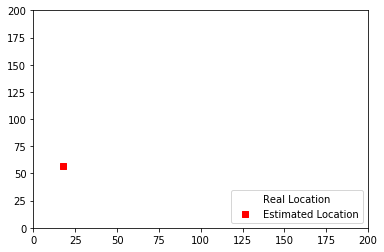

779
infered loc:
[19.47058824 64.05882353]
real loc:
[27.33333 65.33333]


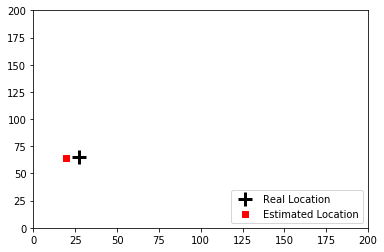

780
infered loc:
[19.47058824 64.05882353]
real loc:
[nan nan]


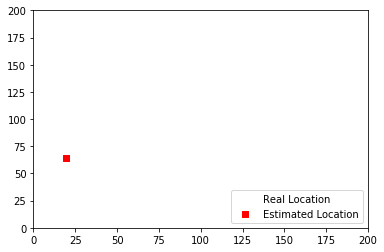

781
infered loc:
[19.47058824 64.05882353]
real loc:
[nan nan]


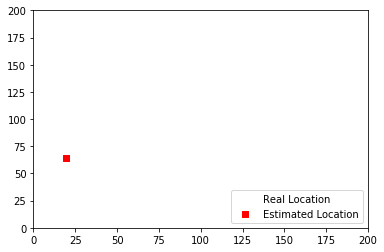

782
infered loc:
[19.47058824 64.05882353]
real loc:
[25.16667 59.66667]


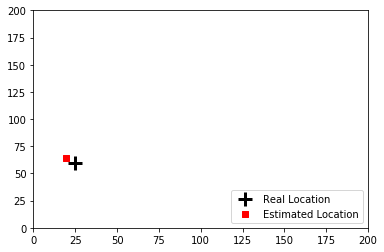

783
infered loc:
[19.47058824 64.05882353]
real loc:
[nan nan]


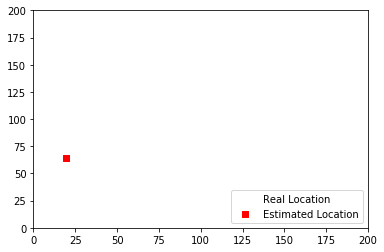

784
infered loc:
[19.47058824 64.05882353]
real loc:
[nan nan]


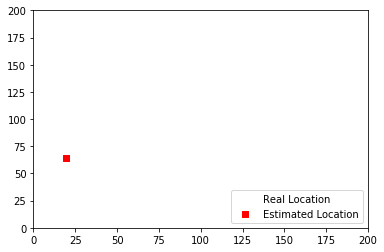

785
infered loc:
[19.47058824 64.05882353]
real loc:
[nan nan]


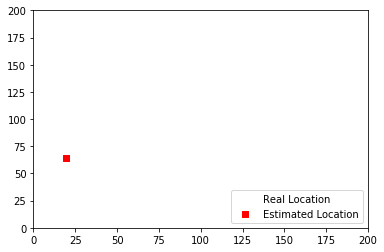

786
infered loc:
[19.47058824 64.05882353]
real loc:
[17. 58.]


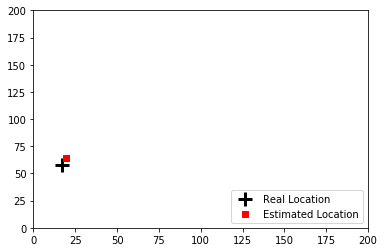

787
infered loc:
[19.47058824 64.05882353]
real loc:
[11. 62.]


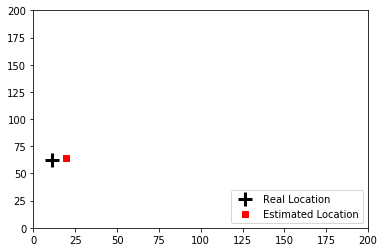

789
infered loc:
[19.47058824 64.05882353]
real loc:
[11.75 61.5 ]


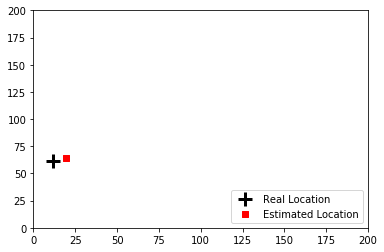

790
infered loc:
[19.47058824 64.05882353]
real loc:
[18.5 57. ]


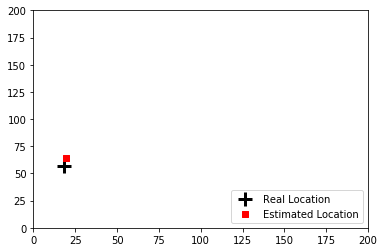

791
infered loc:
[19.47058824 64.05882353]
real loc:
[nan nan]


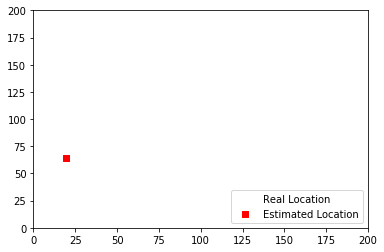

792
infered loc:
[19.47058824 64.05882353]
real loc:
[nan nan]


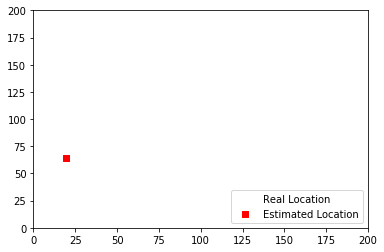

793
infered loc:
[19.47058824 64.05882353]
real loc:
[nan nan]


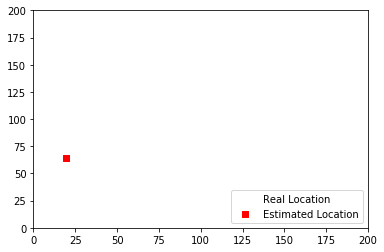

794
infered loc:
[19.47058824 64.05882353]
real loc:
[nan nan]


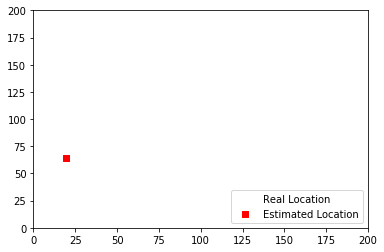

795
infered loc:
[19.47058824 64.05882353]
real loc:
[nan nan]


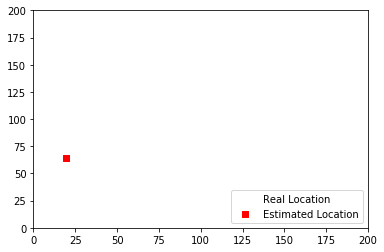

796
infered loc:
[19.47058824 64.05882353]
real loc:
[nan nan]


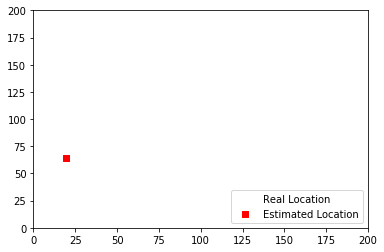

797
infered loc:
[19.47058824 64.05882353]
real loc:
[nan nan]


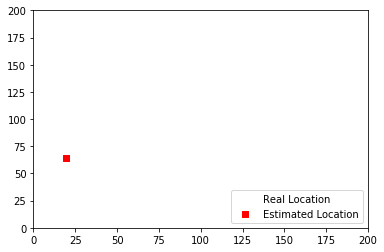

798
infered loc:
[19.47058824 64.05882353]
real loc:
[nan nan]


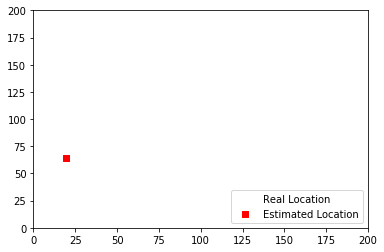

799
infered loc:
[19.47058824 64.05882353]
real loc:
[nan nan]


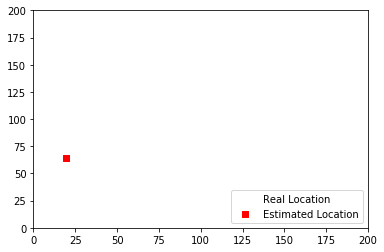

800
infered loc:
[19.47058824 64.05882353]
real loc:
[nan nan]


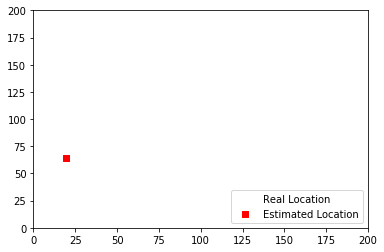

801
infered loc:
[19.47058824 64.05882353]
real loc:
[nan nan]


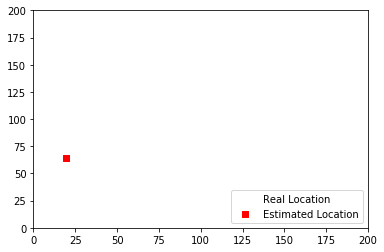

802
infered loc:
[19.47058824 64.05882353]
real loc:
[nan nan]


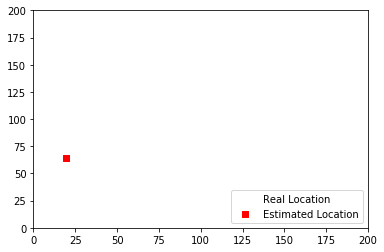

803
infered loc:
[19.47058824 64.05882353]
real loc:
[nan nan]


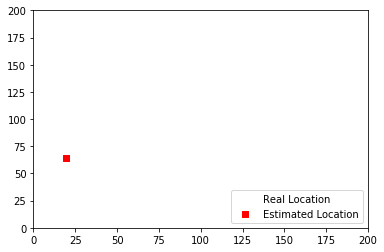

804
infered loc:
[19.47058824 64.05882353]
real loc:
[nan nan]


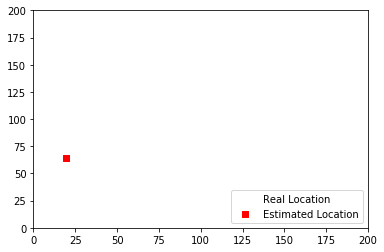

805
infered loc:
[19.47058824 64.05882353]
real loc:
[nan nan]


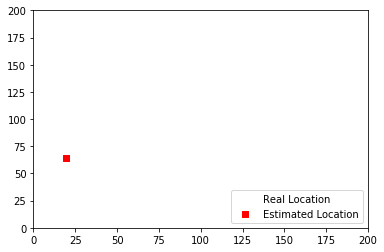

806
infered loc:
[19.47058824 64.05882353]
real loc:
[nan nan]


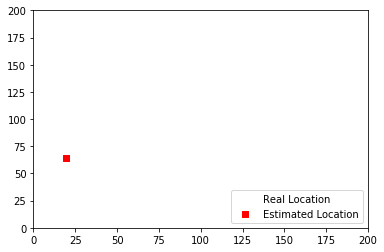

807
infered loc:
[19.47058824 64.05882353]
real loc:
[nan nan]


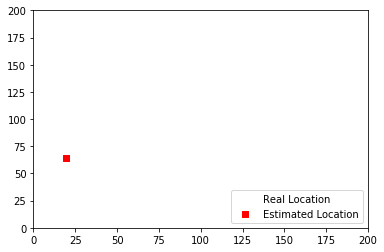

808
infered loc:
[19.47058824 64.05882353]
real loc:
[nan nan]


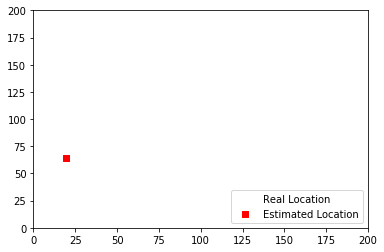

809
infered loc:
[19.47058824 64.05882353]
real loc:
[nan nan]


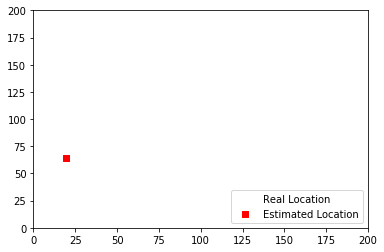

810
infered loc:
[19.47058824 64.05882353]
real loc:
[nan nan]


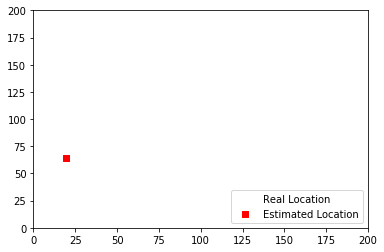

811
infered loc:
[19.47058824 64.05882353]
real loc:
[nan nan]


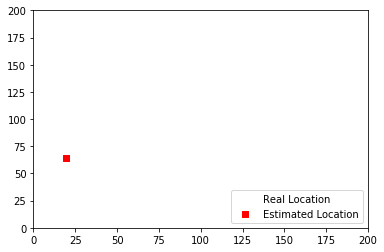

812
infered loc:
[19.47058824 64.05882353]
real loc:
[nan nan]


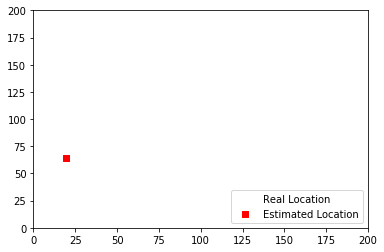

813
infered loc:
[19.47058824 64.05882353]
real loc:
[nan nan]


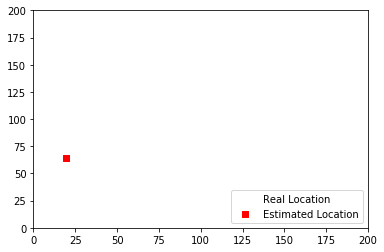

814
infered loc:
[19.47058824 64.05882353]
real loc:
[nan nan]


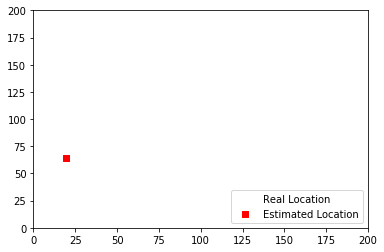

815
infered loc:
[19.47058824 64.05882353]
real loc:
[nan nan]


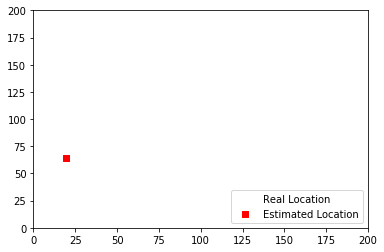

816
infered loc:
[19.47058824 64.05882353]
real loc:
[nan nan]


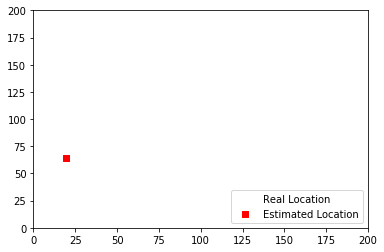

817
infered loc:
[19.47058824 64.05882353]
real loc:
[nan nan]


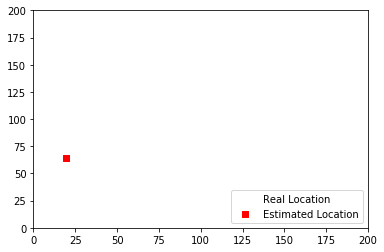

818
infered loc:
[19.47058824 64.05882353]
real loc:
[nan nan]


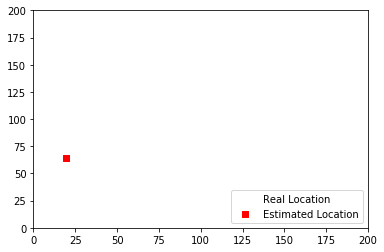

819
infered loc:
[19.47058824 64.05882353]
real loc:
[nan nan]


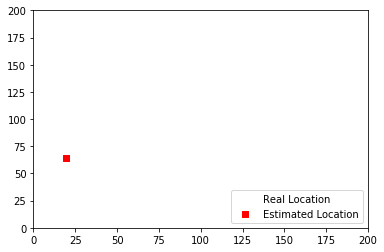

820
infered loc:
[19.47058824 64.05882353]
real loc:
[nan nan]


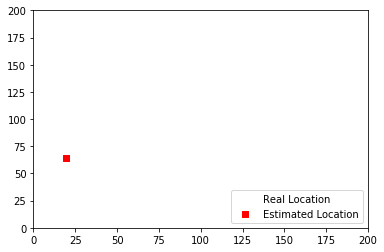

821
infered loc:
[19.47058824 64.05882353]
real loc:
[nan nan]


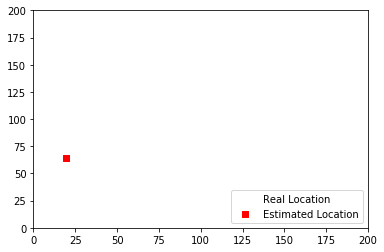

822
infered loc:
[19.47058824 64.05882353]
real loc:
[nan nan]


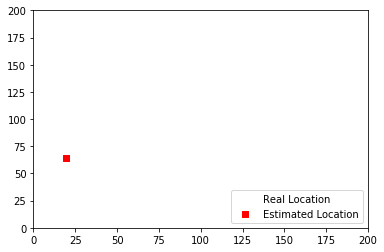

823
infered loc:
[19.47058824 64.05882353]
real loc:
[nan nan]


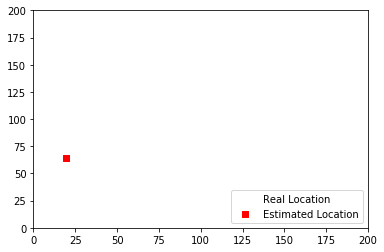

824
infered loc:
[19.47058824 64.05882353]
real loc:
[nan nan]


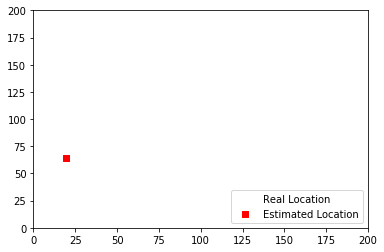

825
infered loc:
[19.47058824 64.05882353]
real loc:
[nan nan]


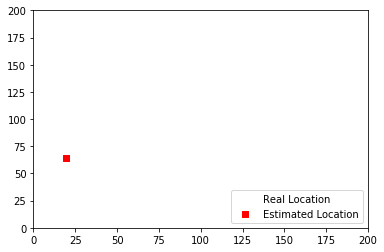

826
infered loc:
[19.47058824 64.05882353]
real loc:
[nan nan]


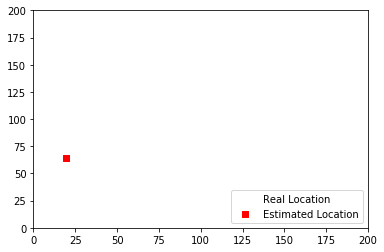

827
infered loc:
[19.47058824 64.05882353]
real loc:
[nan nan]


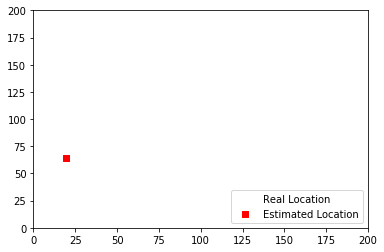

828
infered loc:
[19.47058824 64.05882353]
real loc:
[nan nan]


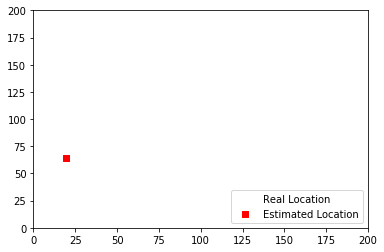

829
infered loc:
[19.47058824 64.05882353]
real loc:
[nan nan]


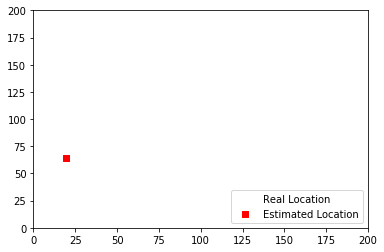

830
infered loc:
[19.47058824 64.05882353]
real loc:
[nan nan]


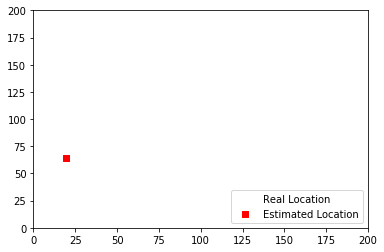

831
infered loc:
[19.47058824 64.05882353]
real loc:
[nan nan]


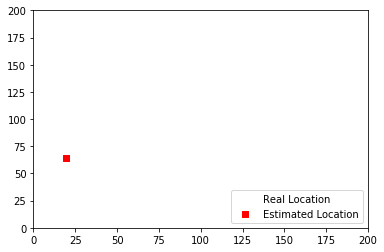

832
infered loc:
[19.47058824 64.05882353]
real loc:
[nan nan]


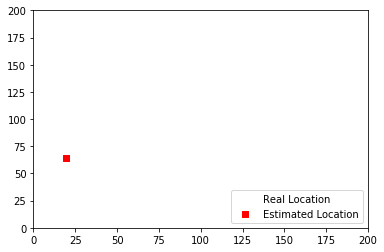

833
infered loc:
[19.47058824 64.05882353]
real loc:
[nan nan]


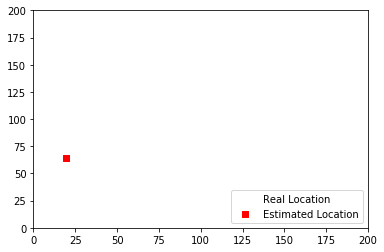

834
infered loc:
[19.47058824 64.05882353]
real loc:
[nan nan]


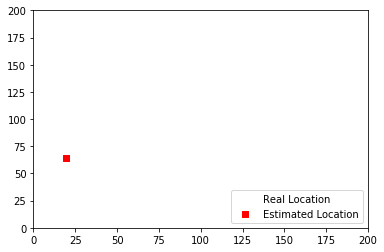

835
infered loc:
[19.47058824 64.05882353]
real loc:
[nan nan]


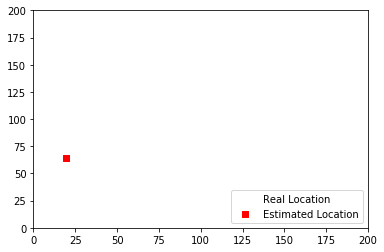

836
infered loc:
[19.47058824 64.05882353]
real loc:
[nan nan]


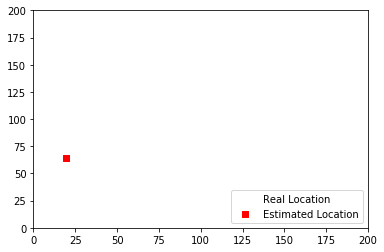

837
infered loc:
[19.47058824 64.05882353]
real loc:
[nan nan]


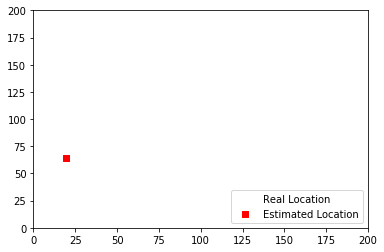

838
infered loc:
[19.47058824 64.05882353]
real loc:
[nan nan]


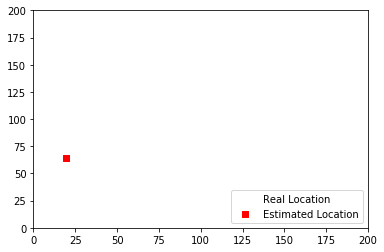

839
infered loc:
[19.47058824 64.05882353]
real loc:
[nan nan]


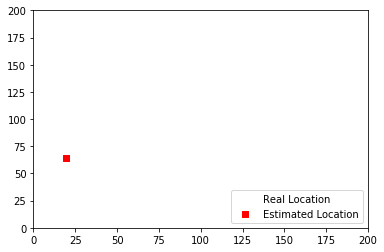

840
infered loc:
[19.47058824 64.05882353]
real loc:
[nan nan]


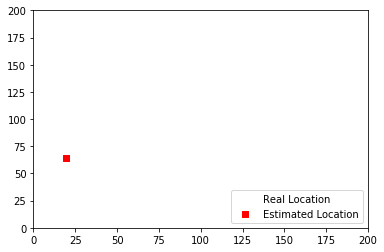

841
infered loc:
[19.47058824 64.05882353]
real loc:
[nan nan]


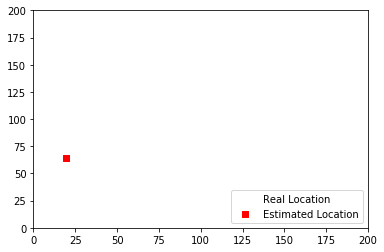

842
infered loc:
[19.47058824 64.05882353]
real loc:
[nan nan]


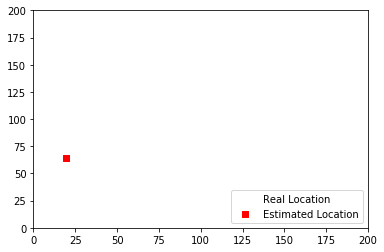

843
infered loc:
[19.47058824 64.05882353]
real loc:
[nan nan]


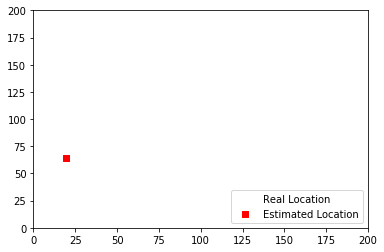

844
infered loc:
[19.47058824 64.05882353]
real loc:
[nan nan]


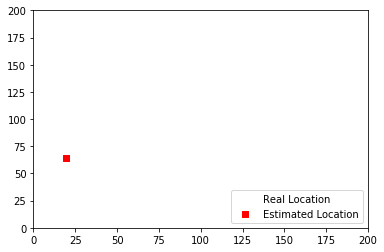

845
infered loc:
[19.47058824 64.05882353]
real loc:
[nan nan]


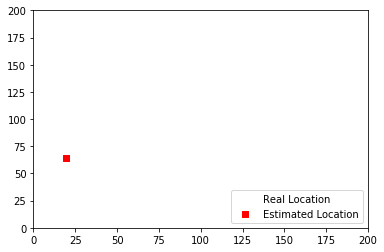

846
infered loc:
[19.47058824 64.05882353]
real loc:
[nan nan]


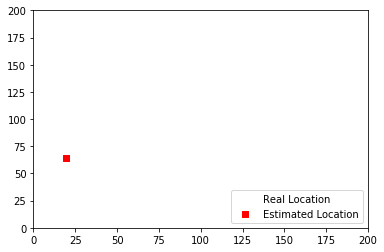

847
infered loc:
[19.47058824 64.05882353]
real loc:
[nan nan]


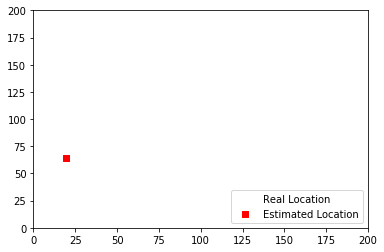

848
infered loc:
[19.47058824 64.05882353]
real loc:
[nan nan]


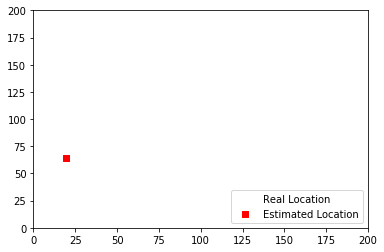

849
infered loc:
[19.47058824 64.05882353]
real loc:
[nan nan]


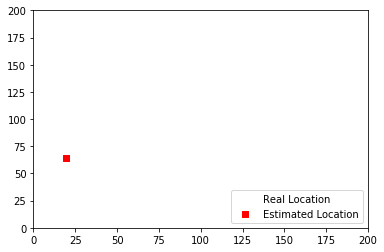

850
infered loc:
[19.47058824 64.05882353]
real loc:
[nan nan]


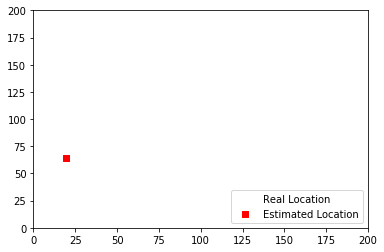

851
infered loc:
[19.47058824 64.05882353]
real loc:
[nan nan]


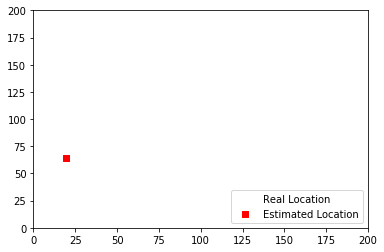

852
infered loc:
[19.47058824 64.05882353]
real loc:
[nan nan]


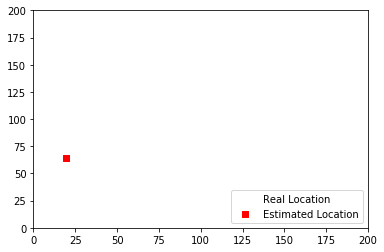

853
infered loc:
[19.47058824 64.05882353]
real loc:
[nan nan]


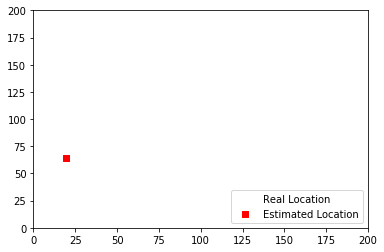

854
infered loc:
[19.47058824 64.05882353]
real loc:
[nan nan]


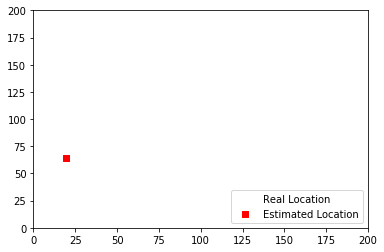

855
infered loc:
[19.47058824 64.05882353]
real loc:
[nan nan]


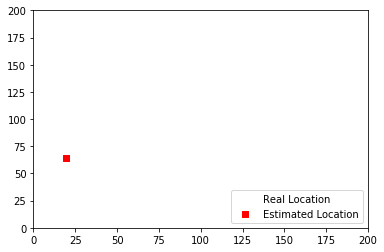

856
infered loc:
[19.47058824 64.05882353]
real loc:
[nan nan]


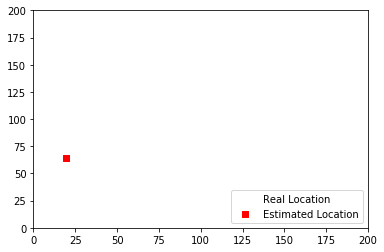

857
infered loc:
[19.47058824 64.05882353]
real loc:
[nan nan]


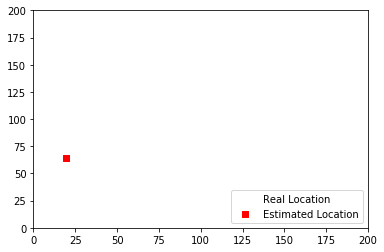

858
infered loc:
[19.47058824 64.05882353]
real loc:
[nan nan]


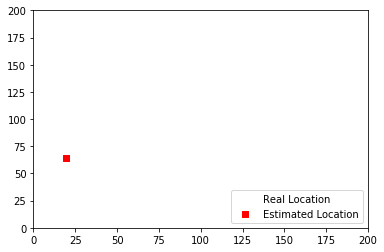

859
infered loc:
[19.47058824 64.05882353]
real loc:
[nan nan]


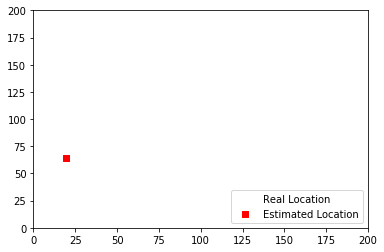

860
infered loc:
[19.47058824 64.05882353]
real loc:
[nan nan]


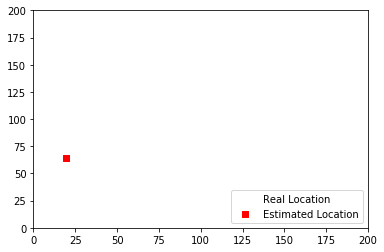

861
infered loc:
[19.47058824 64.05882353]
real loc:
[nan nan]


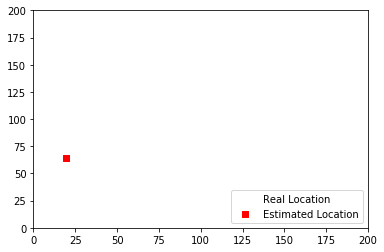

862
infered loc:
[19.47058824 64.05882353]
real loc:
[nan nan]


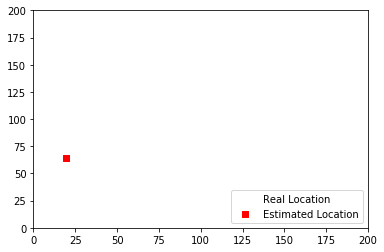

863
infered loc:
[19.47058824 64.05882353]
real loc:
[nan nan]


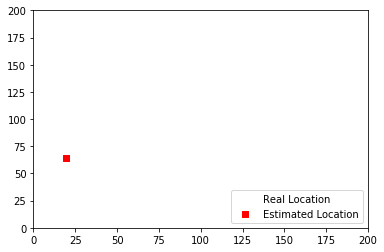

864
infered loc:
[19.47058824 64.05882353]
real loc:
[nan nan]


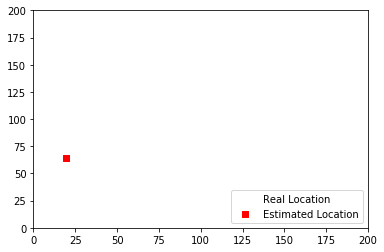

865
infered loc:
[19.47058824 64.05882353]
real loc:
[nan nan]


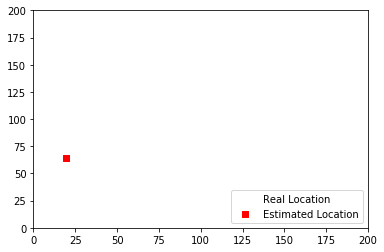

866
infered loc:
[19.47058824 64.05882353]
real loc:
[nan nan]


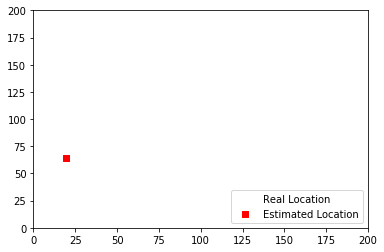

867
infered loc:
[19.47058824 64.05882353]
real loc:
[nan nan]


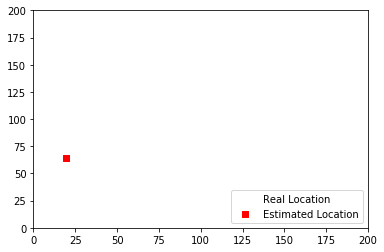

868
infered loc:
[19.47058824 64.05882353]
real loc:
[nan nan]


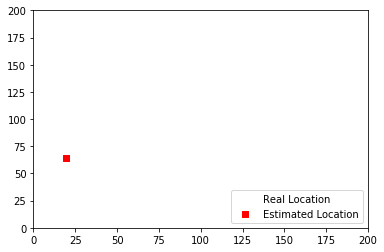

869
infered loc:
[19.47058824 64.05882353]
real loc:
[nan nan]


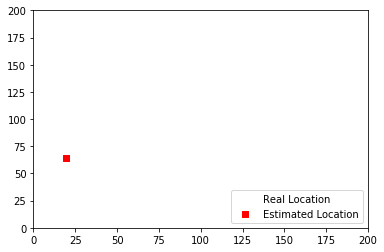

870
infered loc:
[19.47058824 64.05882353]
real loc:
[nan nan]


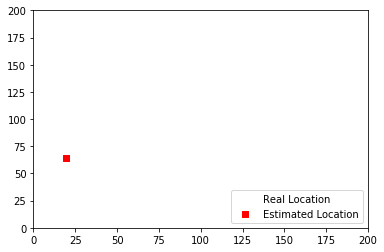

871
infered loc:
[19.47058824 64.05882353]
real loc:
[nan nan]


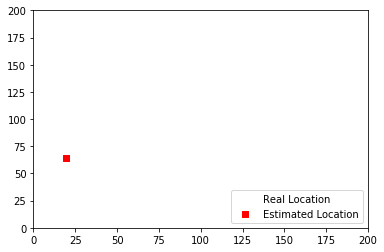

872
infered loc:
[19.47058824 64.05882353]
real loc:
[nan nan]


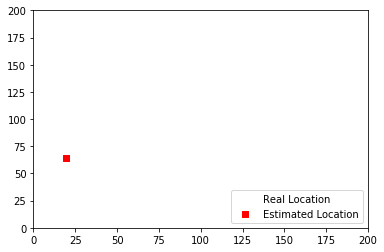

873
infered loc:
[19.47058824 64.05882353]
real loc:
[nan nan]


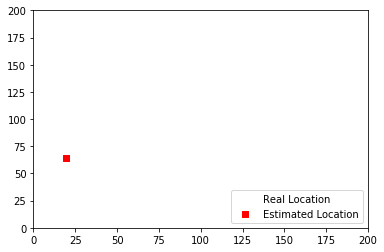

874
infered loc:
[19.47058824 64.05882353]
real loc:
[nan nan]


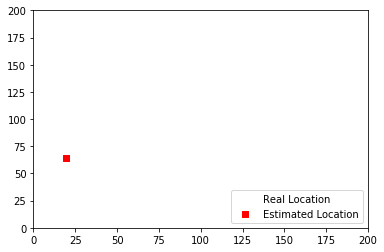

875
infered loc:
[19.47058824 64.05882353]
real loc:
[nan nan]


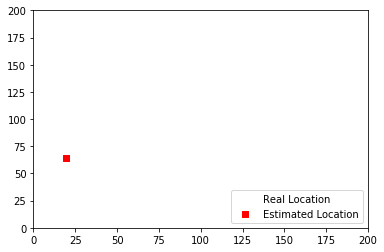

876
infered loc:
[19.47058824 64.05882353]
real loc:
[nan nan]


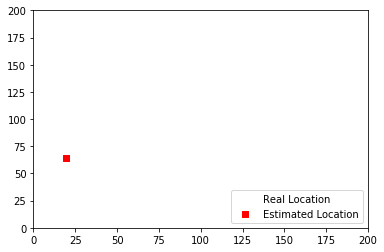

877
infered loc:
[19.47058824 64.05882353]
real loc:
[nan nan]


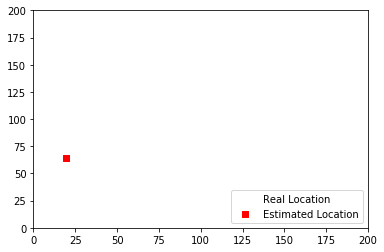

878
infered loc:
[19.47058824 64.05882353]
real loc:
[nan nan]


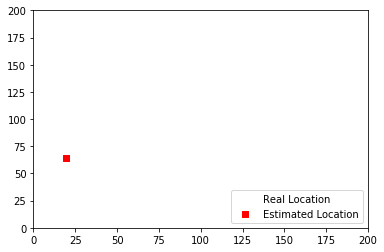

879
infered loc:
[19.47058824 64.05882353]
real loc:
[nan nan]


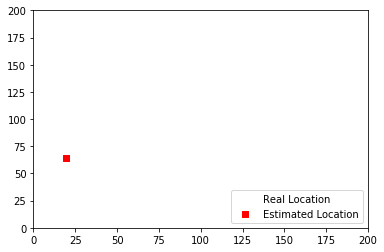

880
infered loc:
[19.47058824 64.05882353]
real loc:
[nan nan]


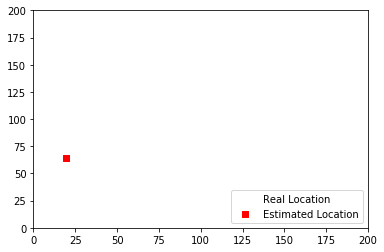

881
infered loc:
[19.47058824 64.05882353]
real loc:
[nan nan]


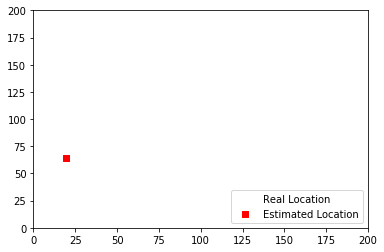

882
infered loc:
[19.47058824 64.05882353]
real loc:
[nan nan]


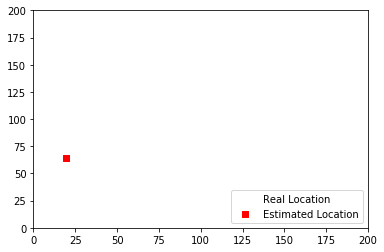

883
infered loc:
[19.47058824 64.05882353]
real loc:
[nan nan]


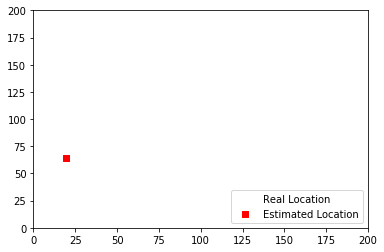

884
infered loc:
[19.47058824 64.05882353]
real loc:
[nan nan]


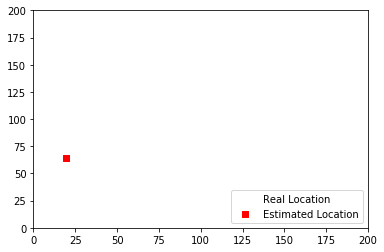

885
infered loc:
[19.47058824 64.05882353]
real loc:
[nan nan]


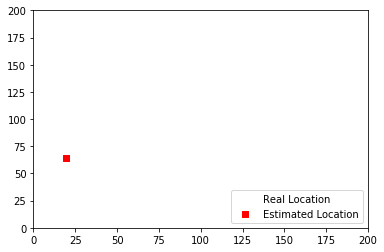

886
infered loc:
[19.47058824 64.05882353]
real loc:
[nan nan]


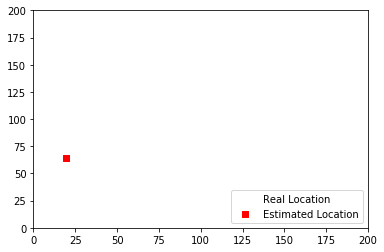

887
infered loc:
[19.47058824 64.05882353]
real loc:
[nan nan]


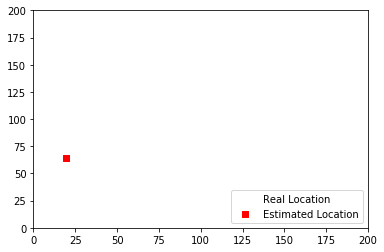

888
infered loc:
[19.47058824 64.05882353]
real loc:
[nan nan]


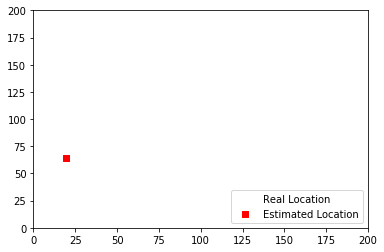

889
infered loc:
[19.47058824 64.05882353]
real loc:
[nan nan]


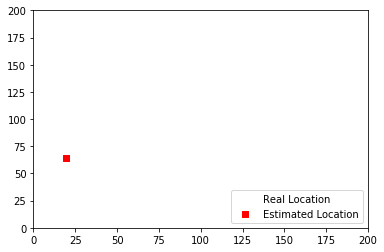

890
infered loc:
[19.47058824 64.05882353]
real loc:
[nan nan]


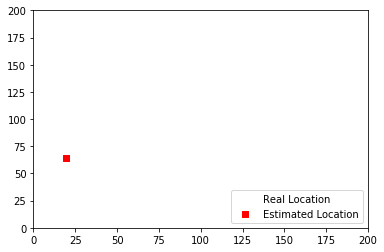

891
infered loc:
[19.47058824 64.05882353]
real loc:
[nan nan]


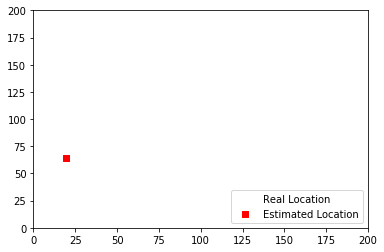

892
infered loc:
[19.47058824 64.05882353]
real loc:
[nan nan]


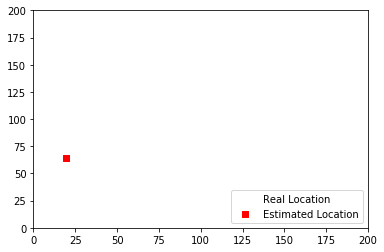

893
infered loc:
[19.47058824 64.05882353]
real loc:
[17.6 66. ]


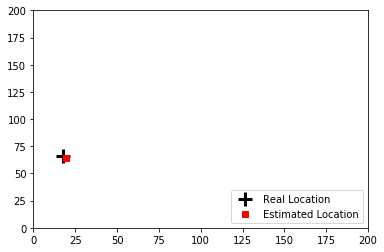

894
infered loc:
[19.47058824 64.05882353]
real loc:
[17.6 66. ]


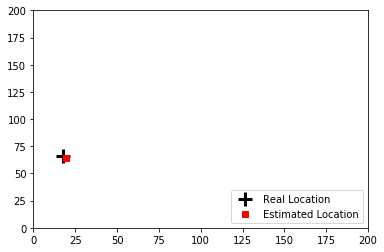

895
infered loc:
[16.5 78.5]
real loc:
[12.2 78. ]


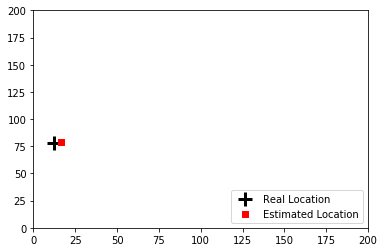

896
infered loc:
[16.5 78.5]
real loc:
[ 6.8 90. ]


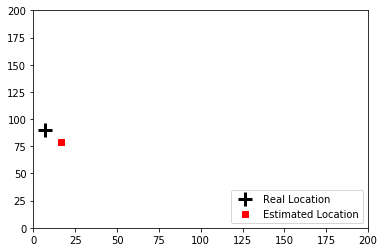

903
infered loc:
[16.5 78.5]
real loc:
[16.      81.33333]


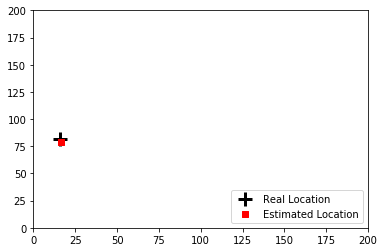

904
infered loc:
[16.5 78.5]
real loc:
[14.9 78.6]


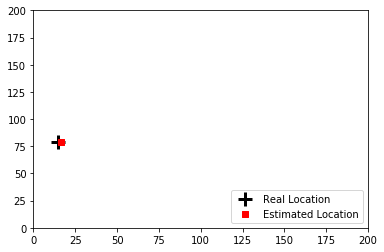

905
infered loc:
[16.5 78.5]
real loc:
[14.9 78.6]


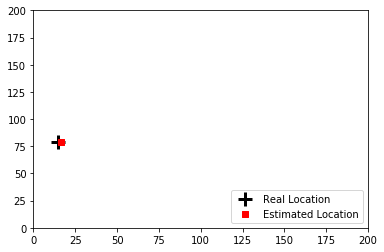

906
infered loc:
[16.5 78.5]
real loc:
[ 5. 84.]


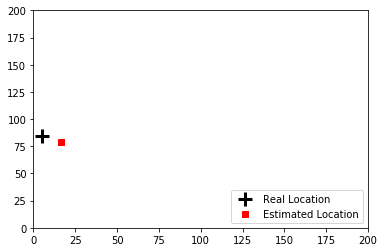

907
infered loc:
[16.5 78.5]
real loc:
[21.5 75. ]


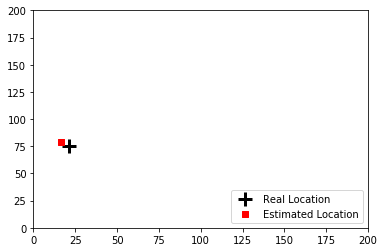

908
infered loc:
[16.5 78.5]
real loc:
[nan nan]


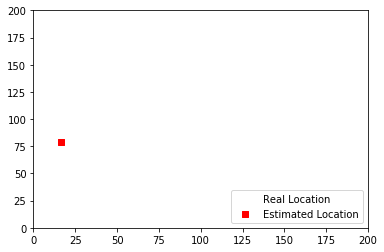

909
infered loc:
[16.5 78.5]
real loc:
[nan nan]


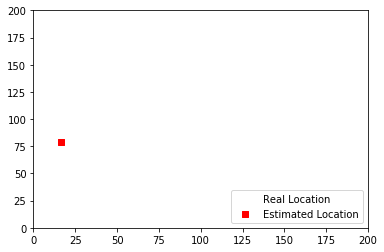

910
infered loc:
[16.5 78.5]
real loc:
[nan nan]


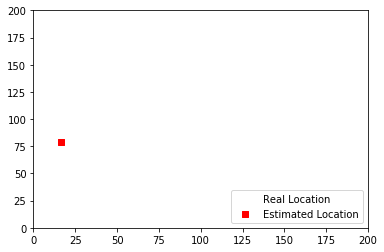

911
infered loc:
[16.5 78.5]
real loc:
[23.375 76.75 ]


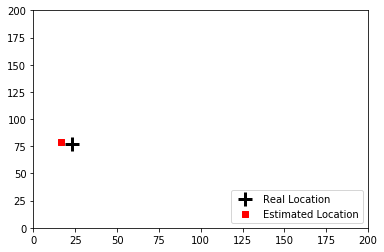

1047
infered loc:
[16.5 78.5]
real loc:
[ 8.6 86. ]


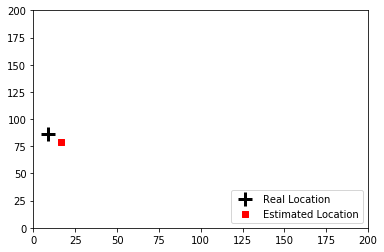

1048
infered loc:
[16.5 78.5]
real loc:
[nan nan]


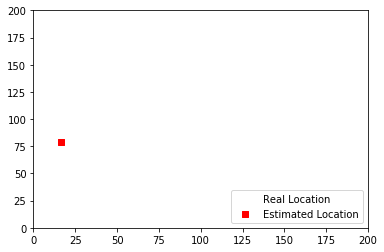

1049
infered loc:
[16.5 78.5]
real loc:
[15.8 70. ]


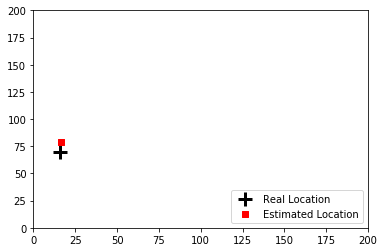

1050
infered loc:
[16.5 78.5]
real loc:
[19.4 62. ]


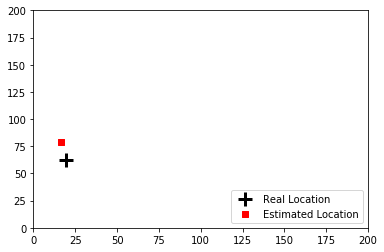

1051
infered loc:
[19.47058824 64.05882353]
real loc:
[19.4 62. ]


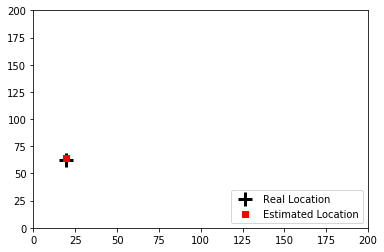

1052
infered loc:
[19.47058824 64.05882353]
real loc:
[nan nan]


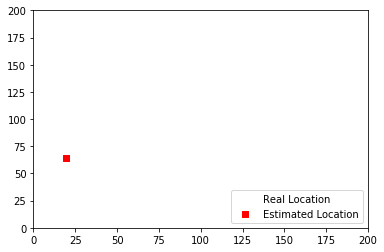

1055
infered loc:
[46.         89.03246753]
real loc:
[53.1 86.2]


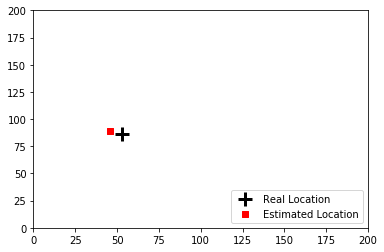

1059
infered loc:
[19.47058824 64.05882353]
real loc:
[nan nan]


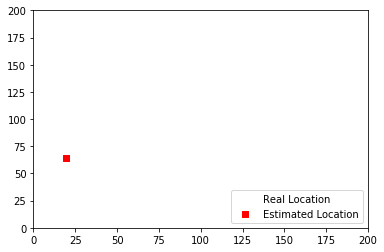

1060
infered loc:
[19.47058824 64.05882353]
real loc:
[30.03571 69.5    ]


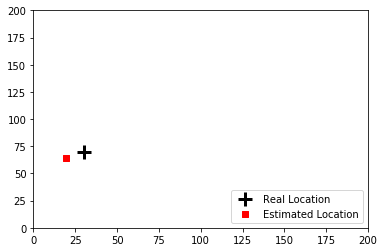

1062
infered loc:
[42.         62.03246753]
real loc:
[32.17857 63.5    ]


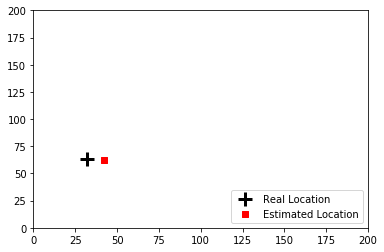

1063
infered loc:
[42.         62.03246753]
real loc:
[32.71429 62.     ]


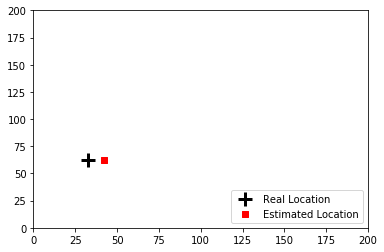

1064
infered loc:
[42.         62.03246753]
real loc:
[33.25 60.5 ]


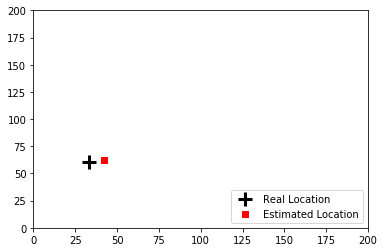

1065
infered loc:
[42.         62.03246753]
real loc:
[33.78571 59.     ]


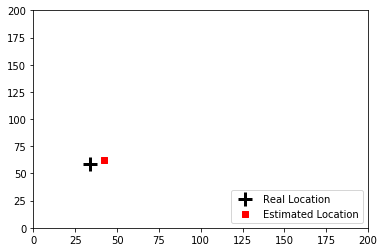

1066
infered loc:
[42.         62.03246753]
real loc:
[34.32143 57.5    ]


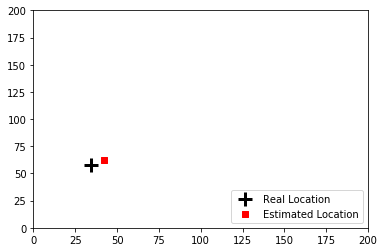

1067
infered loc:
[42.         62.03246753]
real loc:
[34.85714 56.     ]


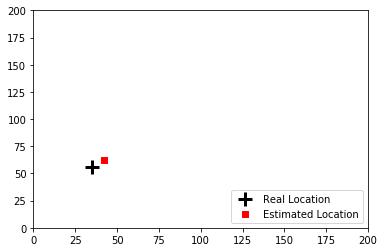

1068
infered loc:
[42.         62.03246753]
real loc:
[35.39286 54.5    ]


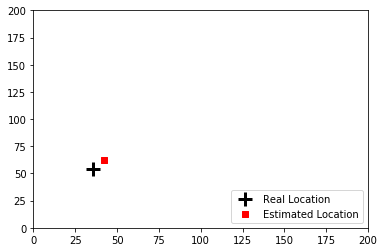

1072
infered loc:
[21.         71.03246753]
real loc:
[12.78571 66.71429]


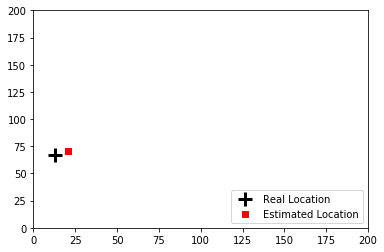

1074
infered loc:
[49.5 57. ]
real loc:
[56.05 45.8 ]


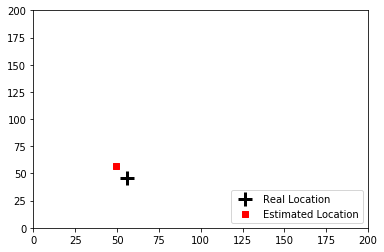

1110
infered loc:
[16.5 78.5]
real loc:
[nan nan]


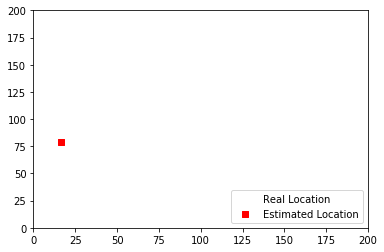

1111
infered loc:
[16.5 78.5]
real loc:
[nan nan]


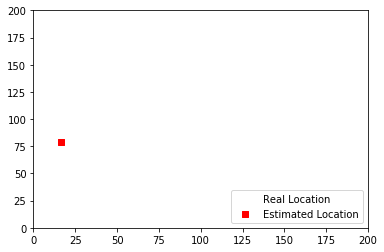

1112
infered loc:
[16.5 78.5]
real loc:
[nan nan]


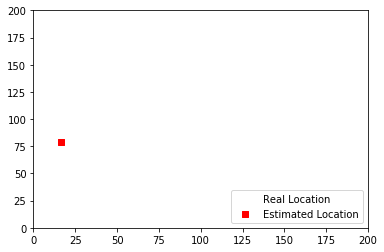

1113
infered loc:
[16.5 78.5]
real loc:
[nan nan]


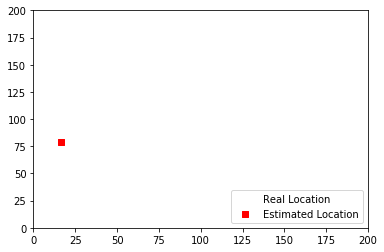

1124
infered loc:
[16.5 78.5]
real loc:
[nan nan]


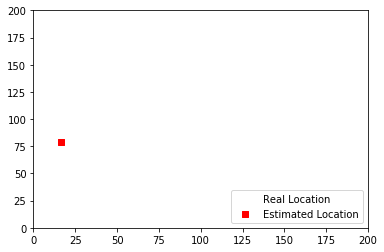

1125
infered loc:
[16.5 78.5]
real loc:
[nan nan]


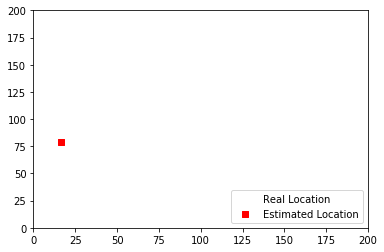

1126
infered loc:
[16.5 78.5]
real loc:
[nan nan]


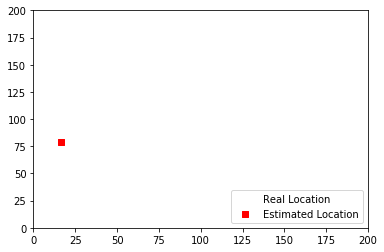

1127
infered loc:
[12.         86.03246753]
real loc:
[nan nan]


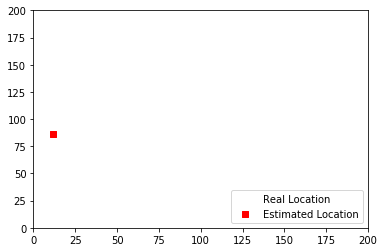

1128
infered loc:
[12.         86.03246753]
real loc:
[nan nan]


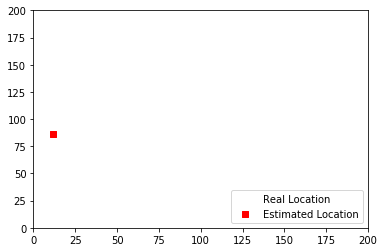

1129
infered loc:
[12.         86.03246753]
real loc:
[nan nan]


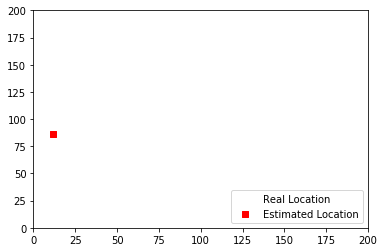

1130
infered loc:
[12.         86.03246753]
real loc:
[nan nan]


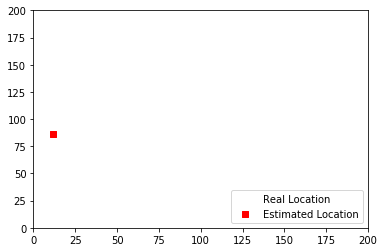

1131
infered loc:
[12.         86.03246753]
real loc:
[nan nan]


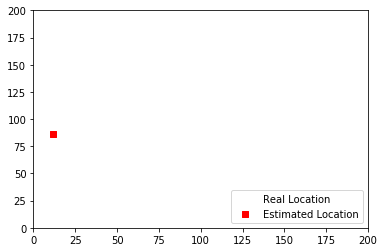

1132
infered loc:
[12.         86.03246753]
real loc:
[nan nan]


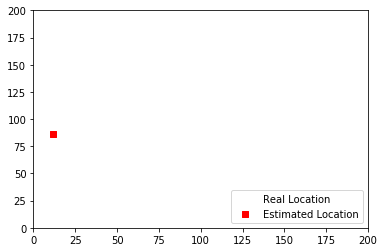

1133
infered loc:
[12.         86.03246753]
real loc:
[nan nan]


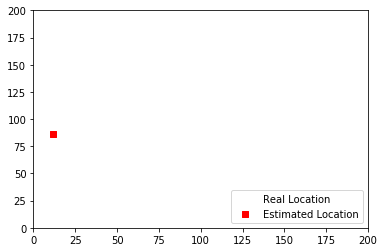

1134
infered loc:
[12.         86.03246753]
real loc:
[nan nan]


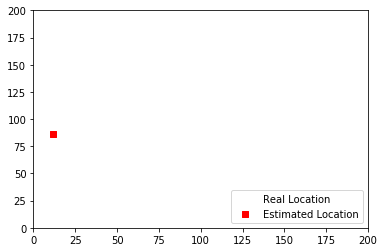

1135
infered loc:
[12.         86.03246753]
real loc:
[nan nan]


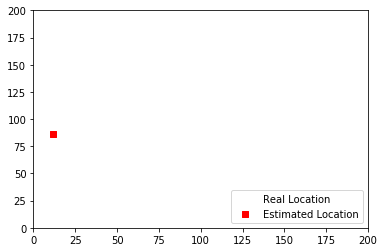

1136
infered loc:
[12.         86.03246753]
real loc:
[nan nan]


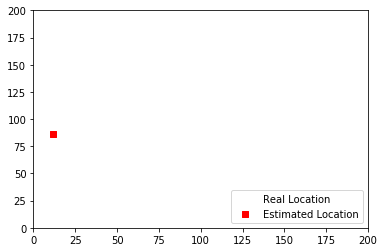

1137
infered loc:
[12.         86.03246753]
real loc:
[nan nan]


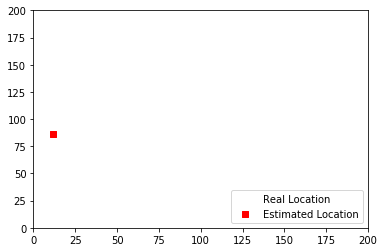

1138
infered loc:
[12.         86.03246753]
real loc:
[nan nan]


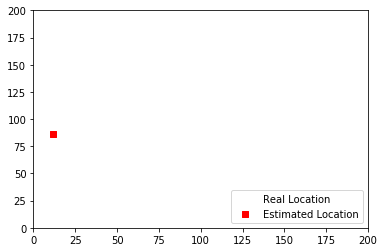

1139
infered loc:
[12.         86.03246753]
real loc:
[nan nan]


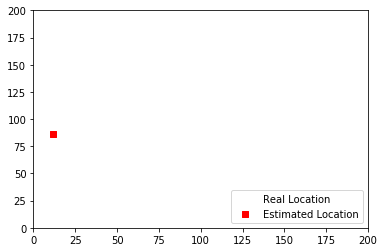

1140
infered loc:
[12.         86.03246753]
real loc:
[nan nan]


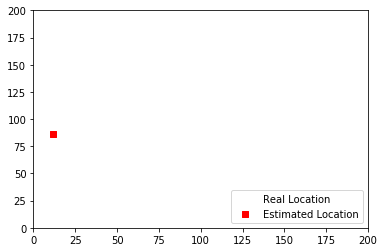

1141
infered loc:
[12.         86.03246753]
real loc:
[nan nan]


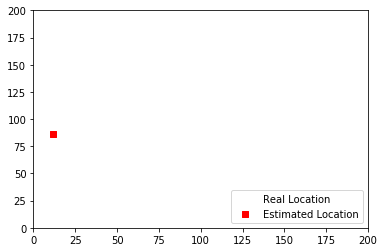

1142
infered loc:
[12.         86.03246753]
real loc:
[nan nan]


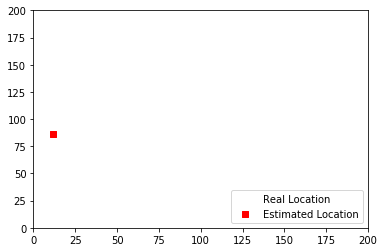

1143
infered loc:
[12.         86.03246753]
real loc:
[nan nan]


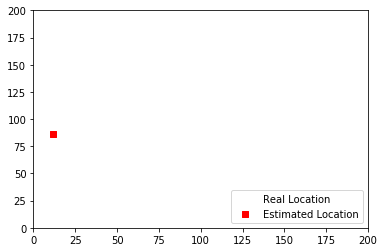

1144
infered loc:
[12.         86.03246753]
real loc:
[nan nan]


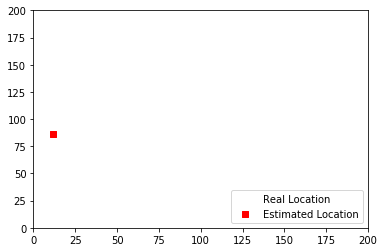

1145
infered loc:
[12.         86.03246753]
real loc:
[nan nan]


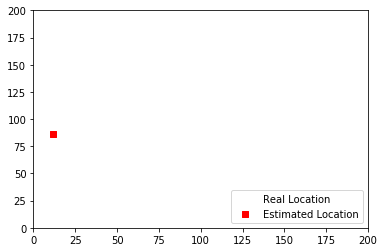

1146
infered loc:
[12.         86.03246753]
real loc:
[nan nan]


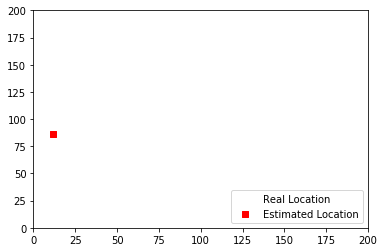

1147
infered loc:
[12.         86.03246753]
real loc:
[nan nan]


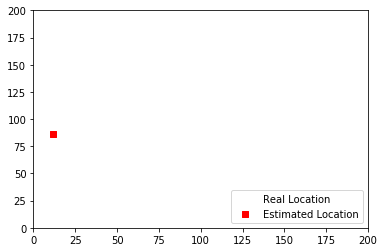

1148
infered loc:
[12.         86.03246753]
real loc:
[nan nan]


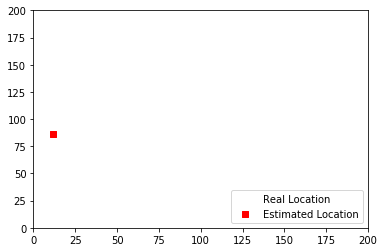

1149
infered loc:
[12.         86.03246753]
real loc:
[nan nan]


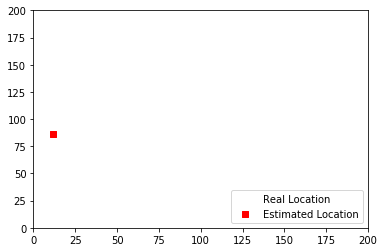

1150
infered loc:
[12.         86.03246753]
real loc:
[nan nan]


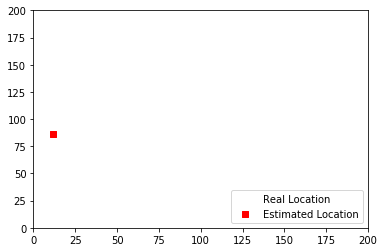

1151
infered loc:
[12.         86.03246753]
real loc:
[nan nan]


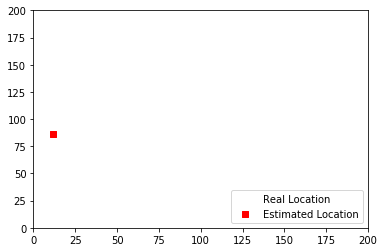

1152
infered loc:
[12.         86.03246753]
real loc:
[nan nan]


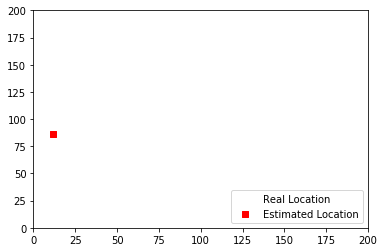

1153
infered loc:
[12.         86.03246753]
real loc:
[nan nan]


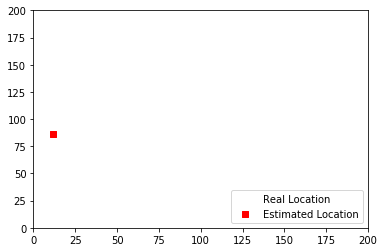

1154
infered loc:
[12.         86.03246753]
real loc:
[nan nan]


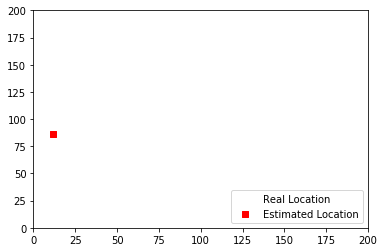

1155
infered loc:
[12.         86.03246753]
real loc:
[nan nan]


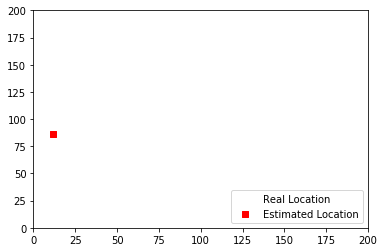

1156
infered loc:
[12.         86.03246753]
real loc:
[nan nan]


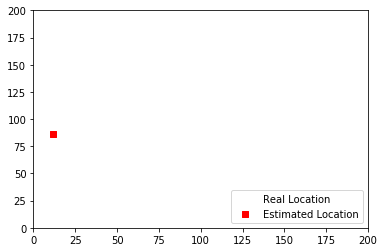

1157
infered loc:
[12.         86.03246753]
real loc:
[nan nan]


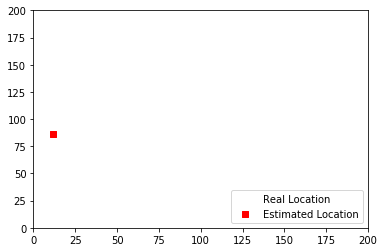

1158
infered loc:
[12.         86.03246753]
real loc:
[nan nan]


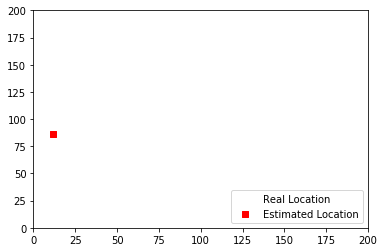

1159
infered loc:
[12.         86.03246753]
real loc:
[nan nan]


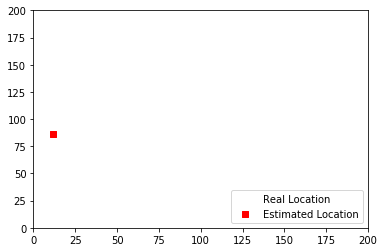

1160
infered loc:
[12.         86.03246753]
real loc:
[nan nan]


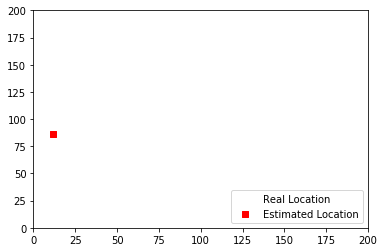

1161
infered loc:
[12.         86.03246753]
real loc:
[nan nan]


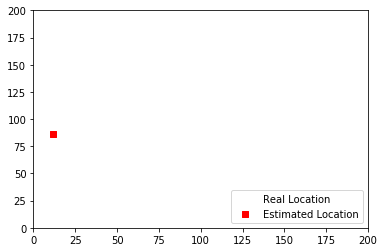

1162
infered loc:
[12.         86.03246753]
real loc:
[nan nan]


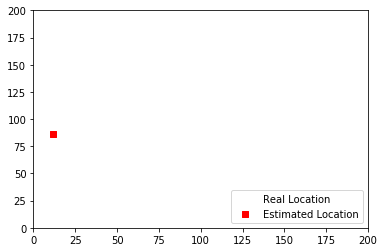

1163
infered loc:
[12.         86.03246753]
real loc:
[nan nan]


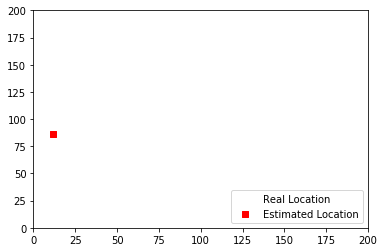

1164
infered loc:
[12.         86.03246753]
real loc:
[nan nan]


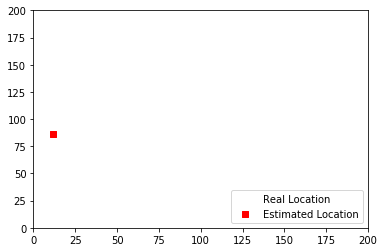

1165
infered loc:
[12.         86.03246753]
real loc:
[nan nan]


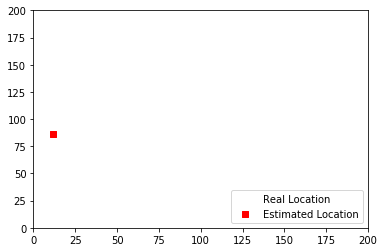

1166
infered loc:
[12.         86.03246753]
real loc:
[nan nan]


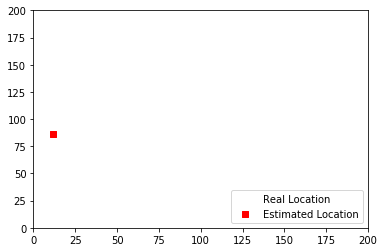

1167
infered loc:
[12.         86.03246753]
real loc:
[nan nan]


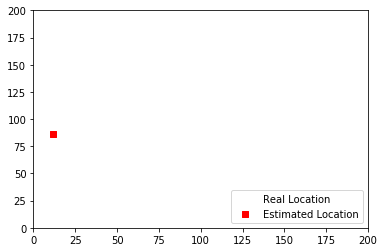

1168
infered loc:
[12.         86.03246753]
real loc:
[nan nan]


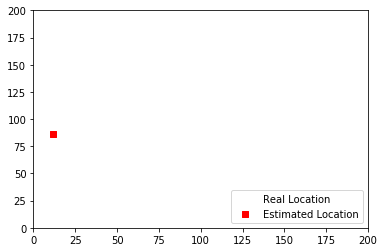

1169
infered loc:
[12.         86.03246753]
real loc:
[nan nan]


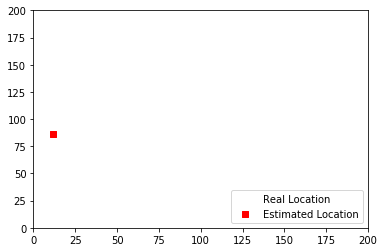

1170
infered loc:
[12.         86.03246753]
real loc:
[nan nan]


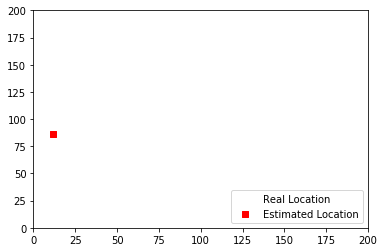

1171
infered loc:
[12.         86.03246753]
real loc:
[nan nan]


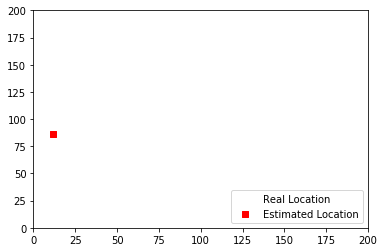

1172
infered loc:
[12.         86.03246753]
real loc:
[nan nan]


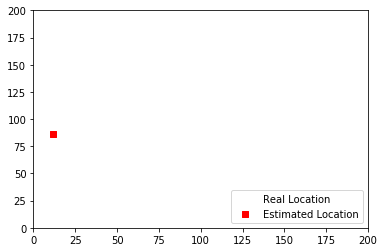

1173
infered loc:
[12.         86.03246753]
real loc:
[nan nan]


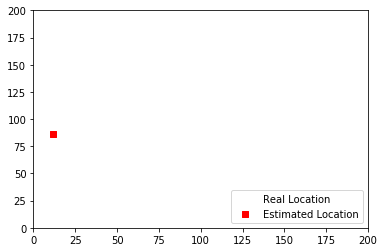

1174
infered loc:
[12.         86.03246753]
real loc:
[nan nan]


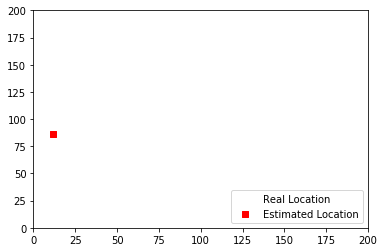

1175
infered loc:
[12.         86.03246753]
real loc:
[nan nan]


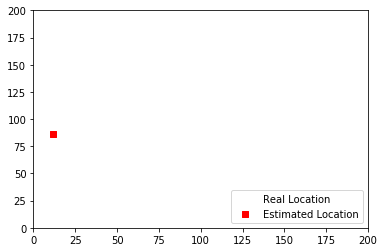

1176
infered loc:
[12.         86.03246753]
real loc:
[nan nan]


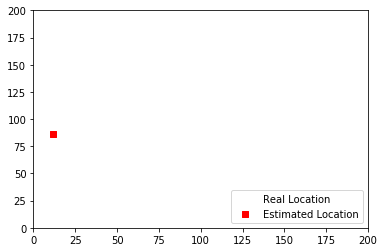

1177
infered loc:
[12.         86.03246753]
real loc:
[nan nan]


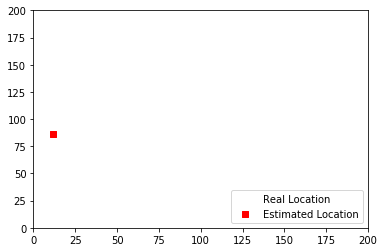

1178
infered loc:
[12.         86.03246753]
real loc:
[nan nan]


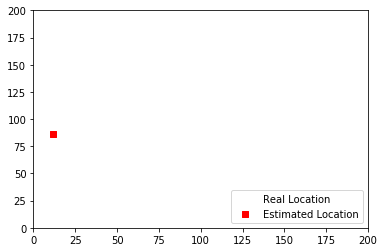

1179
infered loc:
[12.         86.03246753]
real loc:
[nan nan]


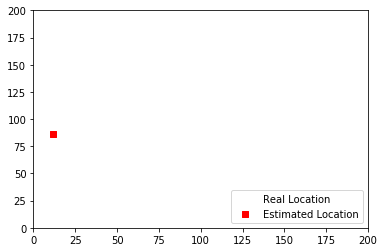

1180
infered loc:
[12.         86.03246753]
real loc:
[nan nan]


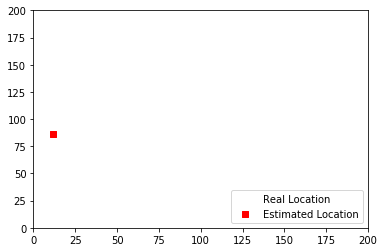

1181
infered loc:
[12.         86.03246753]
real loc:
[nan nan]


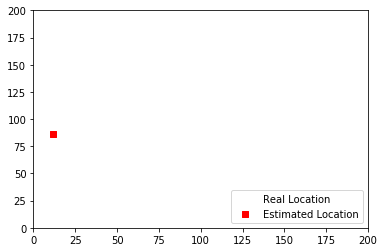

1182
infered loc:
[12.         86.03246753]
real loc:
[nan nan]


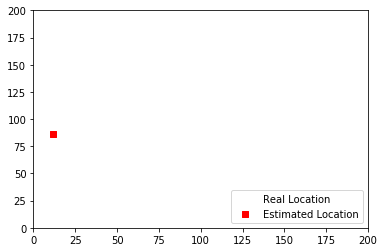

1183
infered loc:
[12.         86.03246753]
real loc:
[nan nan]


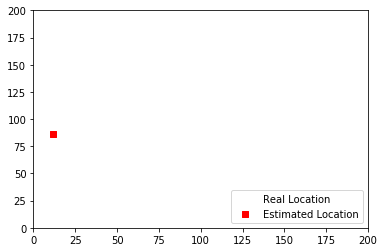

1184
infered loc:
[12.         86.03246753]
real loc:
[nan nan]


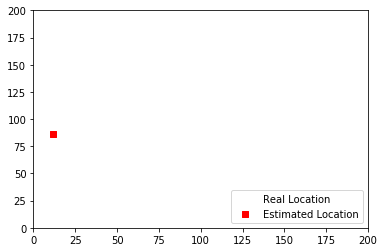

1185
infered loc:
[12.         86.03246753]
real loc:
[nan nan]


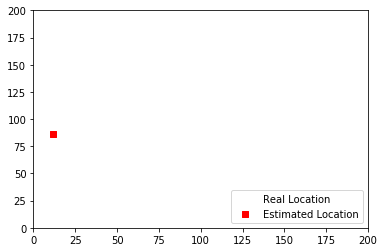

1186
infered loc:
[12.         86.03246753]
real loc:
[nan nan]


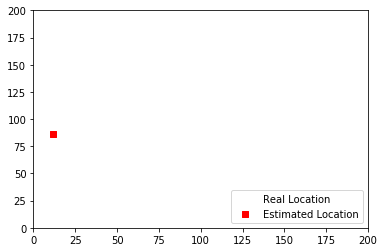

1187
infered loc:
[12.         86.03246753]
real loc:
[nan nan]


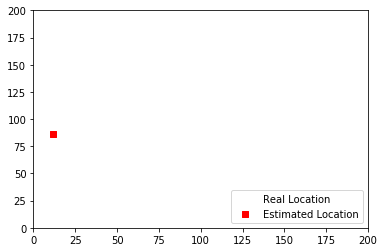

1188
infered loc:
[12.         86.03246753]
real loc:
[nan nan]


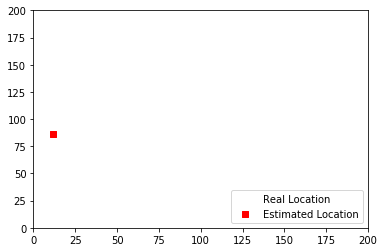

1189
infered loc:
[12.         86.03246753]
real loc:
[nan nan]


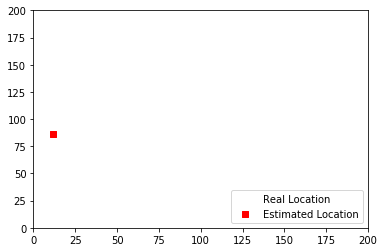

1190
infered loc:
[12.         86.03246753]
real loc:
[nan nan]


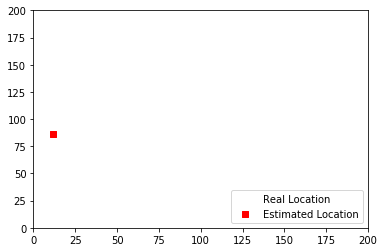

1191
infered loc:
[12.         86.03246753]
real loc:
[nan nan]


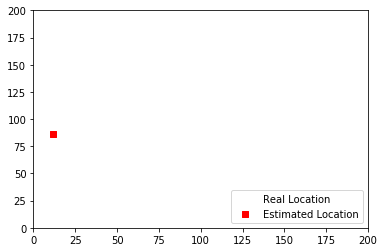

1192
infered loc:
[12.         86.03246753]
real loc:
[nan nan]


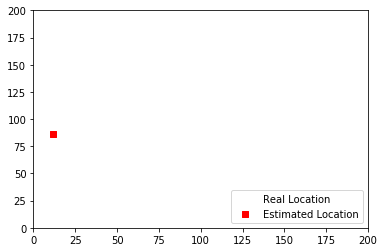

1193
infered loc:
[12.         86.03246753]
real loc:
[nan nan]


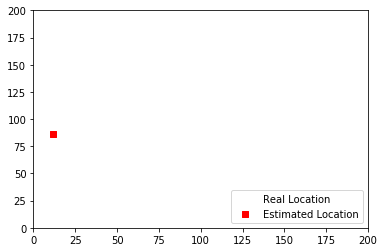

1194
infered loc:
[12.         86.03246753]
real loc:
[nan nan]


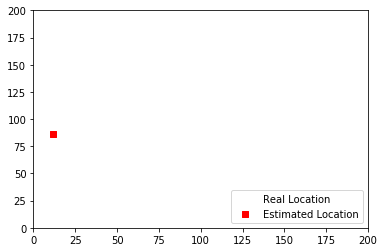

1195
infered loc:
[12.         86.03246753]
real loc:
[nan nan]


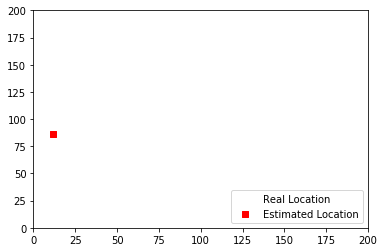

1196
infered loc:
[12.         86.03246753]
real loc:
[nan nan]


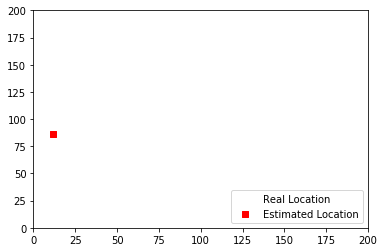

1197
infered loc:
[12.         86.03246753]
real loc:
[nan nan]


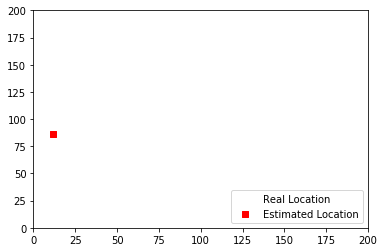

1198
infered loc:
[12.         86.03246753]
real loc:
[nan nan]


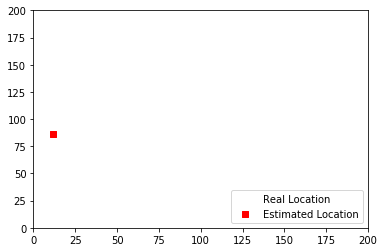

1199
infered loc:
[12.         86.03246753]
real loc:
[nan nan]


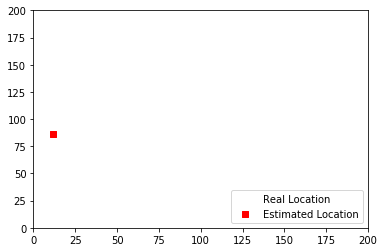

1200
infered loc:
[12.         86.03246753]
real loc:
[nan nan]


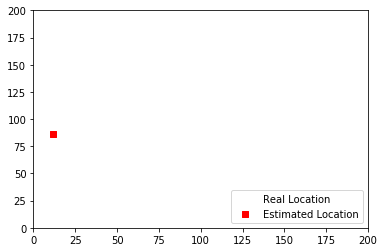

1201
infered loc:
[12.         86.03246753]
real loc:
[nan nan]


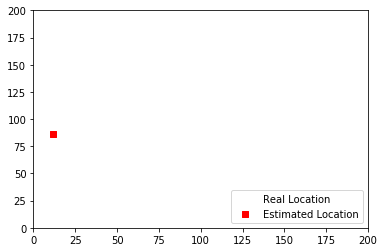

1202
infered loc:
[12.         86.03246753]
real loc:
[nan nan]


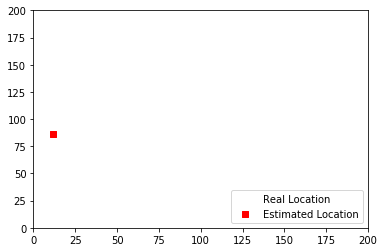

1203
infered loc:
[12.         86.03246753]
real loc:
[nan nan]


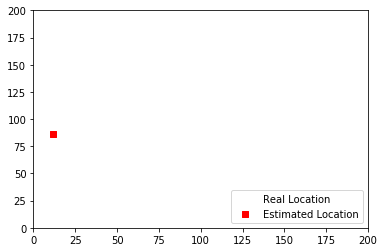

1204
infered loc:
[12.         86.03246753]
real loc:
[nan nan]


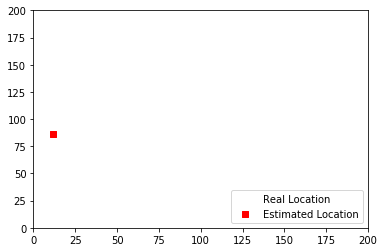

1205
infered loc:
[12.         86.03246753]
real loc:
[nan nan]


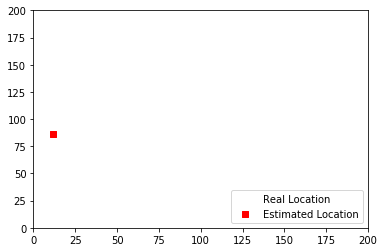

1206
infered loc:
[12.         86.03246753]
real loc:
[nan nan]


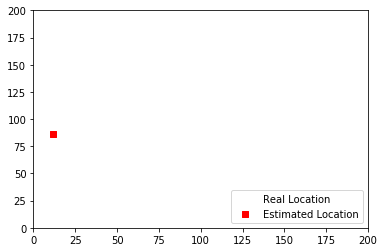

1207
infered loc:
[12.         86.03246753]
real loc:
[nan nan]


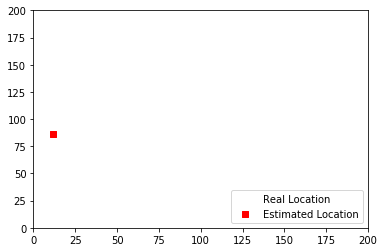

1208
infered loc:
[12.         86.03246753]
real loc:
[nan nan]


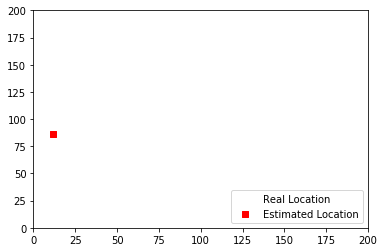

1209
infered loc:
[12.         86.03246753]
real loc:
[nan nan]


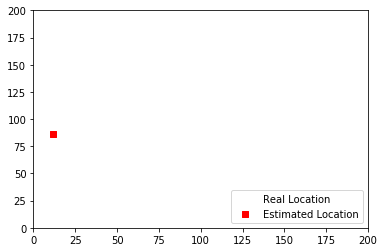

1210
infered loc:
[12.         86.03246753]
real loc:
[nan nan]


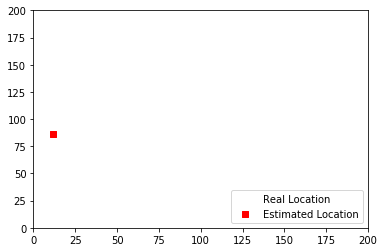

1211
infered loc:
[12.         86.03246753]
real loc:
[nan nan]


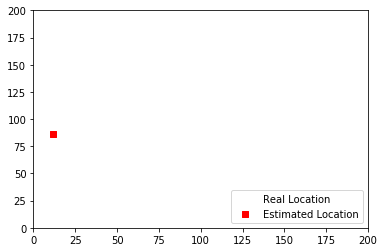

1212
infered loc:
[12.         86.03246753]
real loc:
[nan nan]


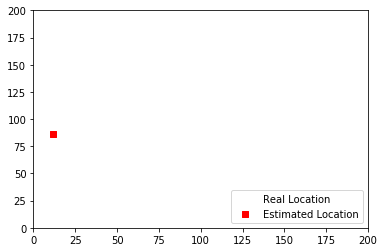

1213
infered loc:
[12.         86.03246753]
real loc:
[nan nan]


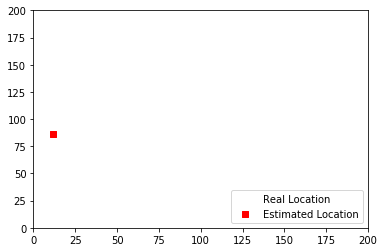

1214
infered loc:
[12.         86.03246753]
real loc:
[nan nan]


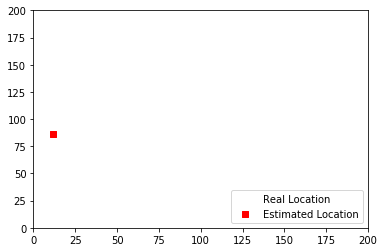

1215
infered loc:
[12.         86.03246753]
real loc:
[nan nan]


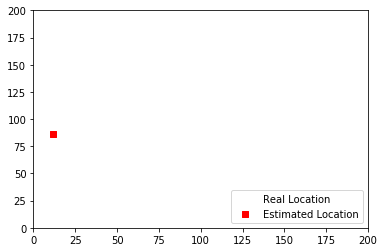

1216
infered loc:
[12.         86.03246753]
real loc:
[nan nan]


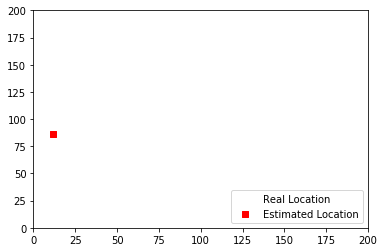

1217
infered loc:
[12.         86.03246753]
real loc:
[nan nan]


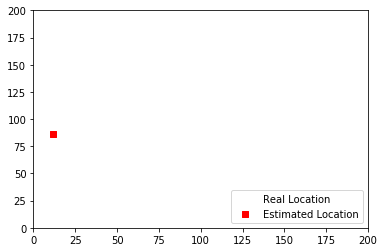

1218
infered loc:
[12.         86.03246753]
real loc:
[nan nan]


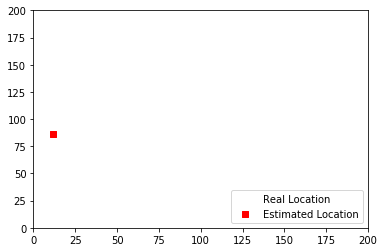

1219
infered loc:
[12.         86.03246753]
real loc:
[nan nan]


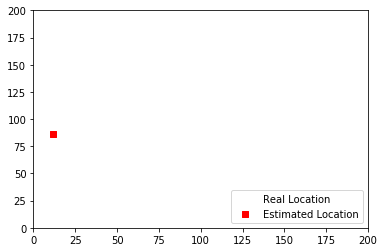

1220
infered loc:
[12.         86.03246753]
real loc:
[13.66667 84.83333]


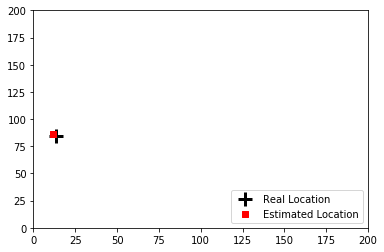

1221
infered loc:
[46.         89.03246753]
real loc:
[39.66667 87.33333]


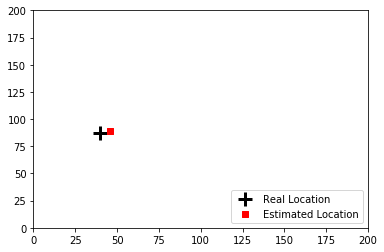

1230
infered loc:
[12.         86.03246753]
real loc:
[nan nan]


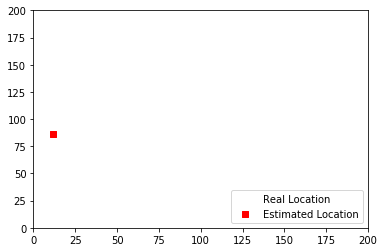

1231
infered loc:
[12.         86.03246753]
real loc:
[nan nan]


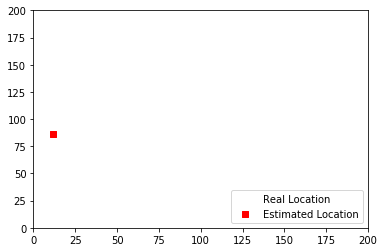

1232
infered loc:
[12.         86.03246753]
real loc:
[nan nan]


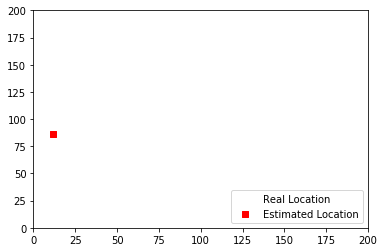

1233
infered loc:
[12.         86.03246753]
real loc:
[nan nan]


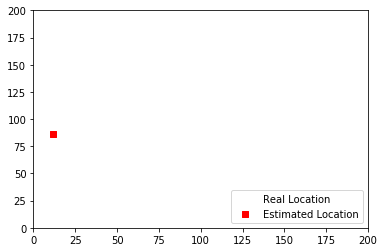

1234
infered loc:
[12.         86.03246753]
real loc:
[nan nan]


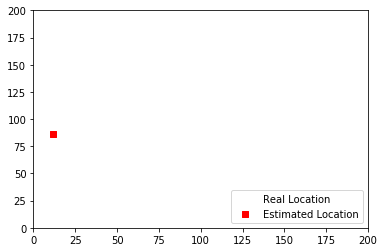

1235
infered loc:
[12.         86.03246753]
real loc:
[nan nan]


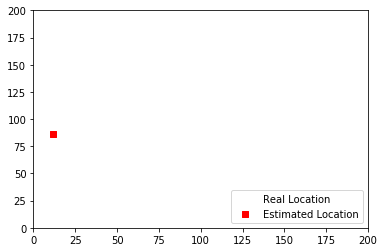

1236
infered loc:
[12.         86.03246753]
real loc:
[nan nan]


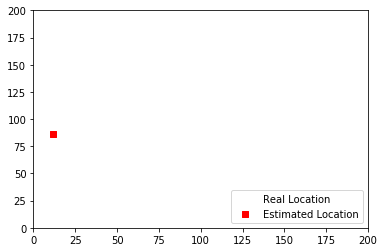

1237
infered loc:
[12.         86.03246753]
real loc:
[nan nan]


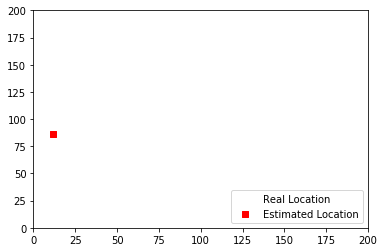

1238
infered loc:
[12.         86.03246753]
real loc:
[nan nan]


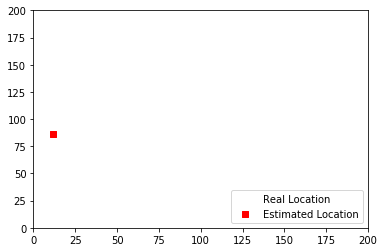

1240
infered loc:
[12.         86.03246753]
real loc:
[nan nan]


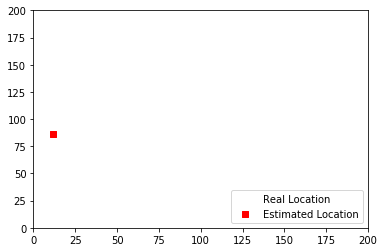

1241
infered loc:
[12.         86.03246753]
real loc:
[nan nan]


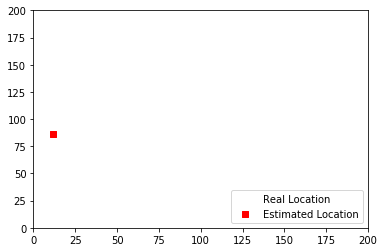

1242
infered loc:
[12.         86.03246753]
real loc:
[nan nan]


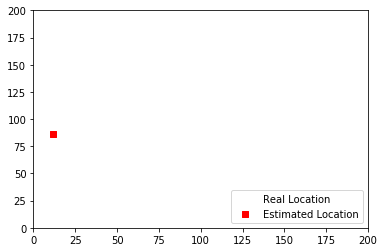

1243
infered loc:
[18.         57.03246753]
real loc:
[nan nan]


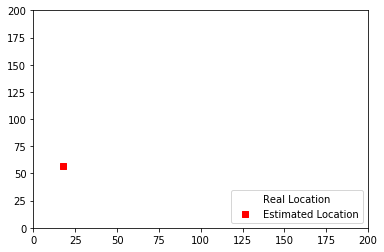

1244
infered loc:
[18.         57.03246753]
real loc:
[nan nan]


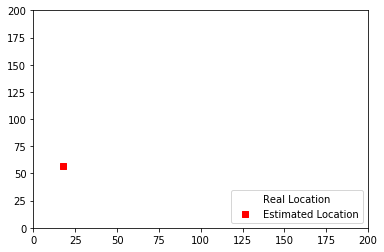

1245
infered loc:
[18.         57.03246753]
real loc:
[nan nan]


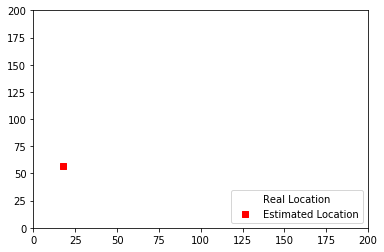

1246
infered loc:
[18.         57.03246753]
real loc:
[nan nan]


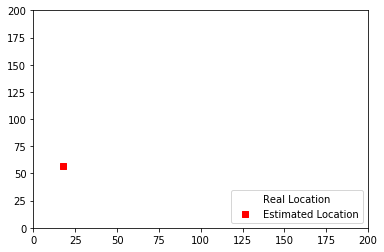

1247
infered loc:
[18.         57.03246753]
real loc:
[nan nan]


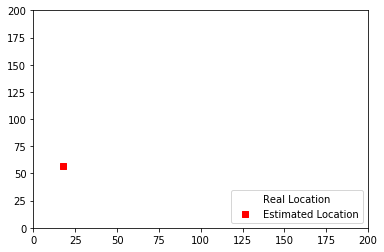

1248
infered loc:
[18.         57.03246753]
real loc:
[nan nan]


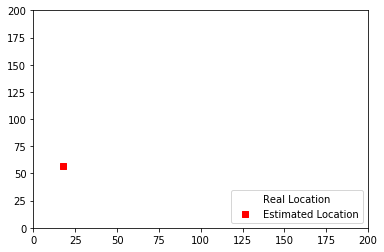

1249
infered loc:
[18.         57.03246753]
real loc:
[nan nan]


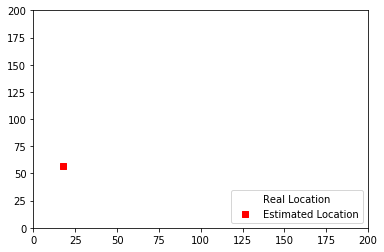

1250
infered loc:
[18.         57.03246753]
real loc:
[nan nan]


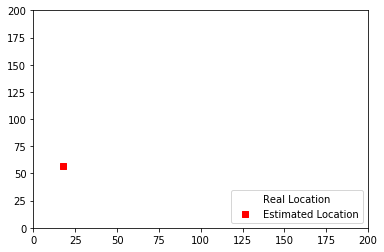

1251
infered loc:
[18.         57.03246753]
real loc:
[nan nan]


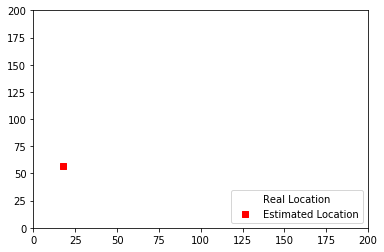

1252
infered loc:
[18.         57.03246753]
real loc:
[nan nan]


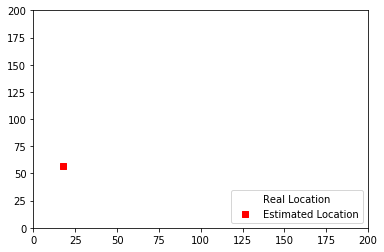

1253
infered loc:
[18.         57.03246753]
real loc:
[nan nan]


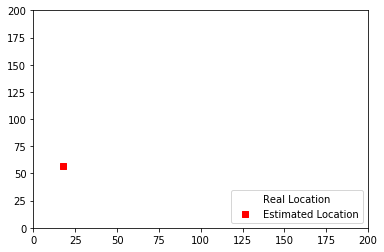

1254
infered loc:
[18.         57.03246753]
real loc:
[nan nan]


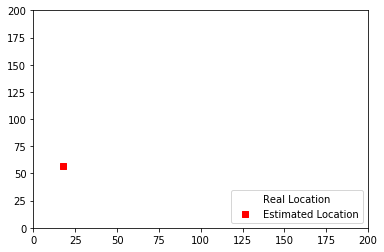

1255
infered loc:
[18.         57.03246753]
real loc:
[nan nan]


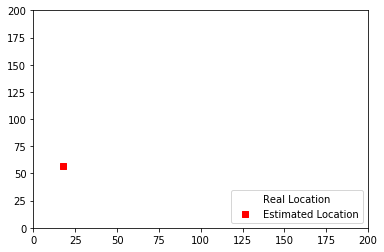

1256


In [ ]:
%matplotlib inline
plt.figure()
readFileCSV()

In [ ]:
len(simulated_sensor_readings)

In [ ]:
completed_dataset = ['time', 'gt(x)', 'gt(y)', 'gt_motion_readings', 'sim_motion_readings']
for i in range(0, len(simulated_sensor_readings)):
    completed_dataset.append((dataset[i + 1], simulated_sensor_readings[i]))

In [ ]:
import pandas as pd

indices_to_keep = [0, 1, 2, 3, 4, 5, 11, 15, 16, 17, 18, 19, 20, 21]

templist = [[0] * 14]
for i in range(0, len(dataset[1:, 3])):
    numlist = [int(s) for s in dataset[1:, 3][i] if s.isdigit()]
    numlist = [numlist[j] for j in range(0, len(numlist)) if j in indices_to_keep]
    templist.append(numlist)
    
templist_modified = [[0] * 14]
for row in range(1, len(templist)):
    history = templist_modified[row - 1]
    row_modified = [0] * 14
    for i in range(len(history)):    
        if (templist[row][i] == 0 and history[i] == 1):
            row_modified[i] = 1
        
        elif (templist[row][i] == 0 and history[i] == 0):
            row_modified[i] = 0
        
        elif (templist[row][i] == 1 and history[i] == 1):
            row_modified[i] = 0
            
        elif (templist[row][i] == 1 and history[i] == 0):
            row_modified[i] = 1
        
    templist_modified.append(row_modified)

del templist_modified[0]    

    
columns = ['time', 'gt(x)', 'gt(y)', 'gt_motion_readings', 'sim_motion_readings']
index = range(0, len(simulated_sensor_readings))

df = pd.DataFrame(index = index, columns = columns)

datadict = {'time' : dataset[1:, 0], 'gt(x)' : dataset[1:, 1], 'gt(y)' : dataset[1:, 2], 
            'gt_motion_readings' : templist_modified, 'sim_motion_readings' : simulated_sensor_readings}

df = pd.DataFrame(datadict)

In [ ]:
templist

In [ ]:
df

In [ ]:
row

In [ ]:
gt_readings = {}

for sensor in range(0, 14):
    gt_readings[sensor] = []
    for i in range(0, len(df['gt_motion_readings'])):
        gt_readings[sensor].append(df['gt_motion_readings'][i][sensor])
        
        
sim_readings = {}

for sensor in range(0, 14):
    sim_readings[sensor] = []
    for i in range(0, len(df['sim_motion_readings'])):
        sim_readings[sensor].append(df['sim_motion_readings'][i][sensor])

In [ ]:
import matplotlib.pyplot as plt

for i in range(len(gt_readings)):
    plt.plot(list(range(0,len(gt_readings[i]))), gt_readings[i])
    plt.show()

In [ ]:
import matplotlib.pyplot as plt

for i in range(len(sim_readings)):
    plt.plot(list(range(0,len(sim_readings[i]))), sim_readings[i])
    plt.show()

In [ ]:
print("please start simulation in casi now.")

In [ ]:
aa = [[0.8, 0], [0, 0]]
print(aa)
# print(*np.where(aa == np.max(aa)))
print(list(zip(*np.where(aa == np.max(aa)))))
np.mean(list(zip(*np.where(aa == np.max(aa)))), axis = 0)

In [ ]:
from random import shuffle
x = [i for i in range(8)]
shuffle(x)
print(x)

In [ ]:
x